# Illustrations

In [208]:
# Standard library imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import yaml
import torch
import os
import pprint

from einops import rearrange
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# JAX related imports
import jax
import jax.numpy as jnp
import jax.random as random

# Orbax related imports
import orbax
import orbax.checkpoint

# Local 
import functions
import functions.vae as vae_module
from functions.prior import LatentPrior
from functions.synthetic.data_jax import SyntheticDataGenerator, dataset_loader
from functions.synthetic.distributions import Gaussian, Gaussian_jax, RandInt, RandInt_jax, SignedUniform, SignedUniform_jax, Uniform, Uniform_jax
from functions.synthetic.graph import ErdosRenyi, ScaleFree, ErdosRenyi_jax, ScaleFree_jax
from functions.utils import parse_config
from functions.train import reconstruction, kl_divergence

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
def load_model(config_file, model, num_sdec_samples=10):
    
    with open(config_file, 'r') as config_file_:
        config = yaml.safe_load(config_file_)

    vae_params = parse_config(config, config_key='VAE_params')
    vae_params['num_sdec_samples'] = num_sdec_samples
    vae_class = getattr(vae_module, model)
    
    vae = vae_class(**vae_params)

    return vae


In [4]:
def empirical_latent_prior(seed, num_samples, config_file=None, weights_distr=None, biases_distr=None, graph_distr=None, noise_scale_distr=None, graph=None, num_variables=2, num_observations=100, num_observations_int=0):
    
    rng = jax.random.PRNGKey(seed)
    rng, subrng = jax.random.split(rng)
    rng_np = np.random.default_rng(np.random.SeedSequence(entropy=seed))
    
    if config_file is not None:
        
        with open(config_file, 'r') as config_file_:
            config = yaml.safe_load(config_file_)
        
        mechanism = 'linearGBN'
        mechanism_params = parse_config(config['linear_additive_params'], config_key='mechanism_params')
        technical_noise_params = parse_config(config['linear_additive_params'], config_key='technical_noise_params')
        graph_distr = parse_config(config, config_key='graph')['graph_distr']
        add_technical_noise_params = None
        graph=None
        
        dataset_params = parse_config(config, config_key='dataset_params')
        dataset_params['rng_np'] = rng_np
    else:
        mechanism = 'linearGBN'
        mechanism_params={}
        mechanism_params['noise_distr'] = Gaussian()
        
        technical_noise_params = {}
        technical_noise_params['additional_noise_distr'] = Gaussian_jax()
        technical_noise_params['additional_noise_std_distr'] = Uniform_jax(0.5,2)
        
        dataset_params = {}
        dataset_params['num_variables'] = num_variables
        dataset_params['num_observations'] = num_observations
        dataset_params['num_observations_int'] = num_observations_int 
        dataset_params['rng_np'] = rng_np
    
    
    if weights_distr is not None:
        mechanism_params['weights_distr'] = weights_distr
    
    if biases_distr is not None:    
        mechanism_params['biases_distr'] = biases_distr
    
    if config_file is None and noise_scale_distr is None:
        mechanism_params['noise_scale_distr'] = Uniform(1,1) 
    elif config_file is None and noise_scale_distr is not None:      
        mechanism_params['noise_scale_distr'] = noise_scale_distr 
    
    if graph_distr is not None:
        graph_distr = graph_distr
        
    if graph is not None:
        graph = graph
    
    
    ### 

    print(f'\nmechanism_params:\n{pprint.pformat(mechanism_params, depth=1)}')
    print(f'\ntechnical_noise_params:\n{pprint.pformat(technical_noise_params, depth=1)}')
    print(f'\ngraph_distr:\n{pprint.pformat(graph_distr, depth=1)}')
    print(f'\ndataset_params:\n{pprint.pformat(dataset_params, depth=1)}')
    
    data_generator = SyntheticDataGenerator(mechanism, mechanism_params, technical_noise_params, graph_distr, add_technical_noise_params=None, graph=graph)
    
    train_loader = dataset_loader(subrng, data_generator, dataset_params=dataset_params, meta_size=num_samples, batch_size=num_samples)
    
    for b in train_loader:
        batch = b[0]
        batch_signal = b[1]
        batch_dataset = b[2]
        
        batch_G = jnp.stack([dataset.G for dataset in batch_dataset])
        # print(batch_G)
    
    return batch_signal

In [6]:
def get_one_dataset(index, seed, config_file, num_obs=None, num_vars=None, w_distr=None, b_distr=None, additional_noise_distr=None, additional_noise_std_distr=None, graph=None, normalize=False):        
    
    with open(config_file, 'r') as config_file_:
        config = yaml.safe_load(config_file_)
        
    rng = jax.random.PRNGKey(seed)
    rng, subrng = jax.random.split(rng)
    
    rng_np = np.random.default_rng(np.random.SeedSequence(entropy=seed))

    mechanism = config['dataset_generator']['mechanism']
    print(f'mechanism: {mechanism}')

    if mechanism == 'linearGBN':
        mechanism_params = parse_config(config['linear_additive_params'], config_key='mechanism_params')
        technical_noise_params = parse_config(config['linear_additive_params'], config_key='technical_noise_params')
        graph_distr = parse_config(config, config_key='graph')['graph_distr']
        add_technical_noise_params = None

    if mechanism == 'grn_sergio':
        mechanism_params = parse_config(config['grn_sergio_params'], config_key='mechanism_params')
        technical_noise_params = parse_config(config['grn_sergio_params'], config_key='technical_noise_params')
        graph_distr = parse_config(config, config_key='graph')['graph_distr']
        add_technical_noise_params = None

    if mechanism == 'dual':
        mechanism_params = parse_config(config['grn_sergio_params'], config_key='mechanism_params')
        technical_noise_params = parse_config(config['grn_sergio_params'], config_key='technical_noise_params')
        graph_distr = parse_config(config, config_key='graph')['graph_distr']
        add_technical_noise_params = parse_config(config['linear_additive_params'], config_key='technical_noise_params')

    
    dataset_params = parse_config(config, config_key='dataset_params')
    dataset_params['rng_np'] = rng_np
    
    dataset_params['num_observations'] = num_obs if num_obs is not None else dataset_params['num_observations']
    dataset_params['num_variables'] = num_vars if num_vars is not None else dataset_params['num_variables']
    
    mechanism_params['weights_distr'] = w_distr if w_distr is not None else mechanism_params['weights_distr']
    mechanism_params['biases_distr'] = b_distr if b_distr is not None else mechanism_params['biases_distr']
    
    technical_noise_params['additional_noise_distr'] = additional_noise_distr if additional_noise_distr is not None else technical_noise_params['additional_noise_distr']
    technical_noise_params['additional_noise_std_distr'] = additional_noise_std_distr if additional_noise_std_distr is not None else technical_noise_params['additional_noise_std_distr']
    
    #-------- define dataset generator
    data_generator = SyntheticDataGenerator(mechanism, mechanism_params, technical_noise_params, graph_distr, add_technical_noise_params=add_technical_noise_params, graph=graph)        
    
    #-------- get dataset
    for i in range(index):
        rng, subrng = jax.random.split(rng)
        dataset = data_generator(subrng, **dataset_params)
        print(f'w_ij in dataset {i+1}: {0 if ( ((dataset.W * dataset.G) != 0).sum().item() == 0 ) else (  (dataset.W * dataset.G)[(dataset.W * dataset.G) != 0].item()  ) }')
        # print(f'b_j in dataset {i+1}: {dataset.b}')
        print(f'{dataset.G} - graph in dataset {i+1}')
    
    return dataset

In [7]:
def get_outputs_jax(dataset, vae, prior, confidence, sample_index, restored_state):
    num_s_samples=11

    rng = random.PRNGKey(0)
    rng, z_rng, dropout_rng = random.split(rng, 3)

    N = dataset.get_noisy().shape[0]
    data_noisy = dataset.get_noisy()
    batch = jnp.expand_dims(data_noisy, axis=-3) # shape [b N d ] where b=1 - batch size (here just one dataset)
    # print(f'{batch.shape} - batch shape')
    
    ############
    mu, sigma, C, enc_output = vae.apply({'params': restored_state['params']}, batch, z_rng, train=False, rngs={'dropout': dropout_rng})
    
    rec = reconstruction(batch, enc_output, C)
    kl, _, _, _, _, _ = kl_divergence(mu, sigma, z_rng, num_s_samples, prior)
    loss = rec + kl
    
    enc_output = enc_output # enc_output: [sdec b N d]
    C = C # dec_output: [b d d]
    
    # print(f'{enc_output.shape} - enc_output')
    # print(f'{C.shape} - C')
    
    i = sample_index
    N = enc_output.shape[-2]
    num_sdec_samples = enc_output.shape[-4]
    
    # getting S
    S_learned = enc_output[i:(i+10)]
    
    # print(f'{S_learned.shape} - S_learned')
    
    # gettind D
    S_learned_i = enc_output[i]        # shape [b N d]
    C_i = C                            # shape [b d d]
    C_i = jnp.expand_dims(C_i, -3)    
    C_i = jnp.repeat(C_i, N, axis=-3)  # shape [b N d d]
    
    shape = (num_sdec_samples,) + S_learned_i.shape[:-1]
    
    # print(shape)
    # print(S_learned_i.shape)
    # print(C_i.shape)
    
    key = jax.random.PRNGKey(0)
    D_decoded = jax.random.multivariate_normal(key, mean=S_learned_i, cov=C_i, shape=shape)
    # print(f'{D_decoded.shape} - D_decoded')
    ############
    
    S_learned_1 = jnp.squeeze(enc_output[i]) 
    S_learned_all = rearrange(jnp.squeeze(S_learned), 's N d -> (s N) d')
    S_learned_1.df = pd.DataFrame(S_learned_1, columns=['s1', 's2'])
    S_learned_all.df = pd.DataFrame(S_learned_all, columns=['s1', 's2'])
    
    D_decoded_1 = jnp.squeeze(D_decoded[i])
    D_decoded_all = rearrange(jnp.squeeze(D_decoded), 's N d -> (s N) d')
    D_decoded_1.df = pd.DataFrame(D_decoded_1, columns=['x1', 'x2'])
    D_decoded_all.df = pd.DataFrame(D_decoded_all, columns=['x1', 'x2'])
    
    
    
    
    # mu, sigma, enc_output, dec_output = vae.apply({'params': restored_state['params']}, batch, z_rng, train=False, rngs={'dropout': dropout_rng})

    # rec = reconstruction(batch, enc_output, dec_output)
    # kl = kl_divergence(mu, sigma, z_rng, num_s_samples, prior)
    # loss = rec + kl


    # enc_output = torch.tensor(np.asarray(enc_output)) # enc_output: torch.Size([10, 1, 500, 2]) for [sdec b N d]
    # dec_output = torch.tensor(np.asarray(dec_output)) # dec_output: torch.Size([10, 1, 2, 2]) for [sdec b d d]
    
    
    # i = sample_index
    # S_learned_1 = enc_output[i].squeeze()
    # S_learned_all = rearrange(enc_output[i:(i+10)].squeeze(), 's N d -> (s N) d')
    # S_learned_1.df = pd.DataFrame(S_learned_1.numpy(), columns=['s1', 's2'])
    # S_learned_all.df = pd.DataFrame(S_learned_all.numpy(), columns=['s1', 's2'])

    # C = dec_output
    # print(f'Cov from VAE.dec: \n{C[0][0]}, {C.shape}')

    # i = sample_index
    # C_1_ = C[i][0]
    # C_1 = C_1_.repeat(N,1,1)


    # #--- getting samples from p(D|S)    
    # p_D = torch.distributions.MultivariateNormal(S_learned_1, C_1) # MVN mean: [N d], cov: [N d d]
    # D_decoded = p_D.sample((10,))
    # i = 0
    # D_decoded_1 = D_decoded[i]
    # D_decoded_all = rearrange(D_decoded, 's N d -> (s N) d')

    # D_decoded_1.df = pd.DataFrame(D_decoded_1.numpy(), columns=['x1', 'x2'])
    # D_decoded_all.df = pd.DataFrame(D_decoded_all.numpy(), columns=['x1', 'x2'])


    # #--- getting CI data
    # C = C.squeeze()
    # var_1 = C[:,0,0]
    # var_2 = C[:,1,1]
    # cov_ij = C[:,1,0]

    # l3, u3 = get_CI(var_1, confidence=confidence)
    # l4, u4 = get_CI(var_2, confidence=confidence)
    # l5, u5 = get_CI(cov_ij, confidence=confidence)

    # CI_var1 = [l3.item(), u3.item()]
    # CI_var2 = [l4.item(), u4.item()]
    # CI_cov = [l5.item(), u5.item()]

    CI_var1 = 0
    CI_var2 = 0
    CI_cov = 0
    
    return rec, C, S_learned_1, S_learned_all, D_decoded_1, D_decoded_all, CI_var1, CI_var2, CI_cov

In [8]:
def get_predictions_VAE2(vae, restored_state, config_file, seed, num_obs, num_vars, batch_size, sample_index=0, additional_noise_std_distr=None):

    with open(f'{config_file}', 'r') as config_file:
        config = yaml.safe_load(config_file)

    rng = jax.random.PRNGKey(seed)
    rng, subrng = jax.random.split(rng)
    rng_np = np.random.default_rng(np.random.SeedSequence(entropy=seed))

    mechanism = config['dataset_generator']['mechanism']

    if mechanism == 'linearGBN':
        mechanism_params = parse_config(config['linear_additive_params'], config_key='mechanism_params')
        technical_noise_params = parse_config(config['linear_additive_params'], config_key='technical_noise_params')
        graph_distr = parse_config(config, config_key='graph')['graph_distr']

    if additional_noise_std_distr is not None:
        technical_noise_params['additional_noise_std_distr'] = additional_noise_std_distr
    
    data_generator = SyntheticDataGenerator(mechanism, mechanism_params, technical_noise_params, graph_distr)

    dataset_params = parse_config(config, config_key='dataset_params')
    dataset_params['num_observations'] = num_obs
    dataset_params['num_variables'] = num_vars
    dataset_params['rng_np'] = rng_np

    train_loader = dataset_loader(subrng, data_generator, dataset_params=dataset_params, meta_size=config['data_loader']['meta_size'], batch_size=config['data_loader']['batch_size'])
    
    dataset_index = batch_size-1
    
    for b in train_loader:
        batch = b[0][dataset_index]
        batch_signal = b[1][dataset_index]
        datasets = b[2][dataset_index]
        
        batch = jnp.expand_dims(batch, -3)
        batch_signal = jnp.expand_dims(batch_signal, -3)
    
    S_true = batch_signal
    
    rng, z_rng, dropout_rng = random.split(rng, 3)
    mu, sigma, C, enc_output = vae.apply({'params': restored_state['params']}, batch, z_rng, train=False, rngs={'dropout': dropout_rng})
    
    enc_output = enc_output # enc_output: [sdec b N d]
    C = C # dec_output: [b d d]
    
    print(enc_output.shape)
    print(C.shape)
    
    i = sample_index
    N = enc_output.shape[-2]
    num_sdec_samples = enc_output.shape[-4]
    
    # getting S
    S_learned = enc_output[i:(i+10)]
    
    # gettind D
    S_learned_i = enc_output[i]        # shape [b N d]
    C_i = C                            # shape [b d d]
    C_i = jnp.expand_dims(C_i, -3)    
    C_i = jnp.repeat(C_i, N, axis=-3)  # shape [b N d d]
    
    shape = (num_sdec_samples,) + S_learned_i.shape[:-1]
    
    # print(shape)
    # print(S_learned_i.shape)
    # print(C_i.shape)
    
    rng, subrng = jax.random.split(rng)
    D_decoded = jax.random.multivariate_normal(subrng, mean=S_learned_i, cov=C_i, shape=shape)
    # D_decoded - for ith sample form learned q(S) we predict num_sdec_samples number of samples
    
    return S_true, S_learned, D_decoded, datasets, C # S_true of shape [b N d], both others of shape [sdec b N d]

In [9]:
def plot_pca(S_true, S_learned, D_decoded, dataset, Cov, axis_lim):
    print(f'{(dataset.C)} - true covariance matrix for additional noise')
    print(f'\n{Cov} - predicted covariance matrix for additional noise (for ith sample S)')
    
    ds_pca = torch.tensor(np.asarray(S_true))
    k = 2
    U,S,V = torch.pca_lowrank(ds_pca, q=None, center=True, niter=3)
    
    points_noisy_pca = torch.matmul(torch.tensor(np.asarray(dataset.get_noisy())), V[:, :k])
    points_true_pca = torch.matmul(torch.tensor(np.asarray(S_true)), V[:, :k])
    points_learned_pca = torch.matmul(torch.tensor(np.asarray(S_learned)), V[:, :k])
    points_decoded_pca = torch.matmul(torch.tensor(np.asarray(D_decoded)), V[:, :k])

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5*3, 5))
    l_lim, u_lim = axis_lim[0], axis_lim[1]

    ax1.scatter(points_true_pca[:, 0], points_true_pca[:, 1], s=10, alpha=0.7, c='mediumseagreen', marker="o", label='signal')
    ax1.scatter(points_noisy_pca[:, 0], points_noisy_pca[:, 1], s=10, alpha=0.7, c='darkgreen', marker="o", label='noisy data')
    sns.kdeplot(x=points_true_pca[:, 0], y=points_true_pca[:, 1], color='limegreen', levels=[0.05], label=f'0.95 contours', alpha=1.0, ax=ax1)
    sns.kdeplot(x=points_noisy_pca[:, 0], y=points_noisy_pca[:, 1], color='darkgreen', levels=[0.05], label=f'0.95 contours', alpha=1.0, ax=ax1)
    ax1.legend(loc='upper left')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_xlim(l_lim, u_lim)
    ax1.set_ylim(l_lim, u_lim)

    ax2.scatter(points_true_pca[:, 0], points_true_pca[:, 1], s=10, c='mediumseagreen', marker="o", label='signal')
    ax2.scatter(points_learned_pca[:, 0], points_learned_pca[:, 1], s=10, c='royalblue', marker="o", label='learned signal')
    sns.kdeplot(x=points_true_pca[:, 0], y=points_true_pca[:, 1], color='limegreen', levels=[0.05], label=f'0.95 contours', alpha=1.0, ax=ax2)
    sns.kdeplot(x=points_learned_pca[:, 0], y=points_learned_pca[:, 1], color='royalblue', levels=[0.05], label=f'0.95 contours', alpha=1.0, ax=ax2)
    ax2.legend(loc='upper left')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_xlim(l_lim, u_lim)
    ax2.set_ylim(l_lim, u_lim)

    ax3.scatter(points_noisy_pca[:, 0], points_noisy_pca[:, 1], s=10, c='darkgreen', marker="o", label='noisy data')
    ax3.scatter(points_decoded_pca[:, 0], points_decoded_pca[:, 1], s=10, c='darkblue', marker="o", label='decoded data')
    sns.kdeplot(x=points_noisy_pca[:, 0], y=points_noisy_pca[:, 1], color='darkgreen', levels=[0.05], label=f'0.95 contours', alpha=1.0, ax=ax3)
    sns.kdeplot(x=points_decoded_pca[:, 0], y=points_decoded_pca[:, 1], color='darkblue', levels=[0.05], label=f'0.95 contours', alpha=1.0, ax=ax3)
    ax3.legend(loc='upper left')
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC2')
    ax3.set_xlim(l_lim, u_lim)
    ax3.set_ylim(l_lim, u_lim)

    plt.show()

In [10]:
def visualize_pairplot_custom(dataset_1, dataset_2, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    # levels = [0.01, 0.05, 0.25, 0.5, 0.75]
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            # Extract the data for x and y from the DataFrames
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            # Extract the data for x and y from the DataFrames
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]
    

            # If it's a diagonal, plot a KDE
            if i == j:
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
                
                # To overlay the second KDE, we need to create a twin axis:
                ax2 = ax.twinx()
                sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
                
                # Ensure the twin axis doesn't show ticks and remove the label "Density"
                ax2.set_yticks([])
                ax.set_ylabel('')
                ax2.set_ylabel('')
                
                ax2.set_xlim(axis_lim)

            # Off-diagonal scatter plots
            else:
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # Set axis limits and ticks
                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                
                # Use automatic ticks for the off-diagonal plots
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # Label the x-axes with variable names
            if i == n_vars - 1:
                ax.set_xlabel(f"s{j+1}")
            # Label the y-axes with variable names only for the first column
            if j == 0 and i != j:
                ax.set_ylabel(f"s{i+1}")

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
    plt.tight_layout()
    plt.show()



# ---- linear GBN ----

# PRIOR d=2

### bias=0, W ~ SignedUniform(0.5,3)

In [12]:
w_distr = SignedUniform(0.5,3)
b_distr = Uniform(0,0)
num_samples=100
num_vars=2
num_obs=500 
seed=6

G1 = np.array([[0,1],[0,0]])
G2 = np.array([[0,0],[1,0]])
G3 = np.array([[0,0],[0,0]])
g_distr = ErdosRenyi(edges_per_var=2)
print(f'{G1} - G1 --> w_12=a (parent of x2 is x1)')
print(f'{G2} - G2 --> w_21=b (parent of x1 is x2)')
print(f'{G3} - G3')

S_samples_G1_bunif_Wunif = empirical_latent_prior(seed, num_samples, num_variables=num_vars, num_observations=num_obs, weights_distr=w_distr, biases_distr=b_distr, graph=G1)
S_samples_G2_bunif_Wunif = empirical_latent_prior(seed, num_samples, num_variables=num_vars, num_observations=num_obs, weights_distr=w_distr, biases_distr=b_distr, graph=G2)
S_samples_G3_bunif_Wunif = empirical_latent_prior(seed, num_samples, num_variables=num_vars, num_observations=num_obs, weights_distr=w_distr, biases_distr=b_distr, graph=G3)
S_samples_Gall_bunif_Wunif_100 = empirical_latent_prior(seed, num_samples, num_variables=num_vars, num_observations=num_obs, weights_distr=w_distr, biases_distr=b_distr, graph_distr=g_distr)

[[0 1]
 [0 0]] - G1 --> w_12=a (parent of x2 is x1)
[[0 0]
 [1 0]] - G2 --> w_21=b (parent of x1 is x2)
[[0 0]
 [0 0]] - G3

mechanism_params:
{'biases_distr': <Uniform at 0x2a02e7250: low=0 high=0>,
 'noise_distr': <Gaussian at 0x29f053550: mean=0.0 scale=1.0>,
 'noise_scale_distr': <Uniform at 0x2a08f6910: low=1 high=1>,
 'weights_distr': <SignedUniform at 0x2a02e76d0: low=0.5 high=3>}

technical_noise_params:
{'additional_noise_distr': <Gaussian_jax at 0x177dcb190: mean=0.0 scale=1.0>,
 'additional_noise_std_distr': <Uniform_jax at 0x2838d9250: low=0.5 high=2>}

graph_distr:
None

dataset_params:
{'num_observations': 500,
 'num_observations_int': 0,
 'num_variables': 2,
 'rng_np': Generator(PCG64) at 0x2A0883CA0}

mechanism_params:
{'biases_distr': <Uniform at 0x2a02e7250: low=0 high=0>,
 'noise_distr': <Gaussian at 0x2a3bc4250: mean=0.0 scale=1.0>,
 'noise_scale_distr': <Uniform at 0x29fd0bed0: low=1 high=1>,
 'weights_distr': <SignedUniform at 0x2a02e76d0: low=0.5 high=3>}

techni

## Figure 5.1

In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

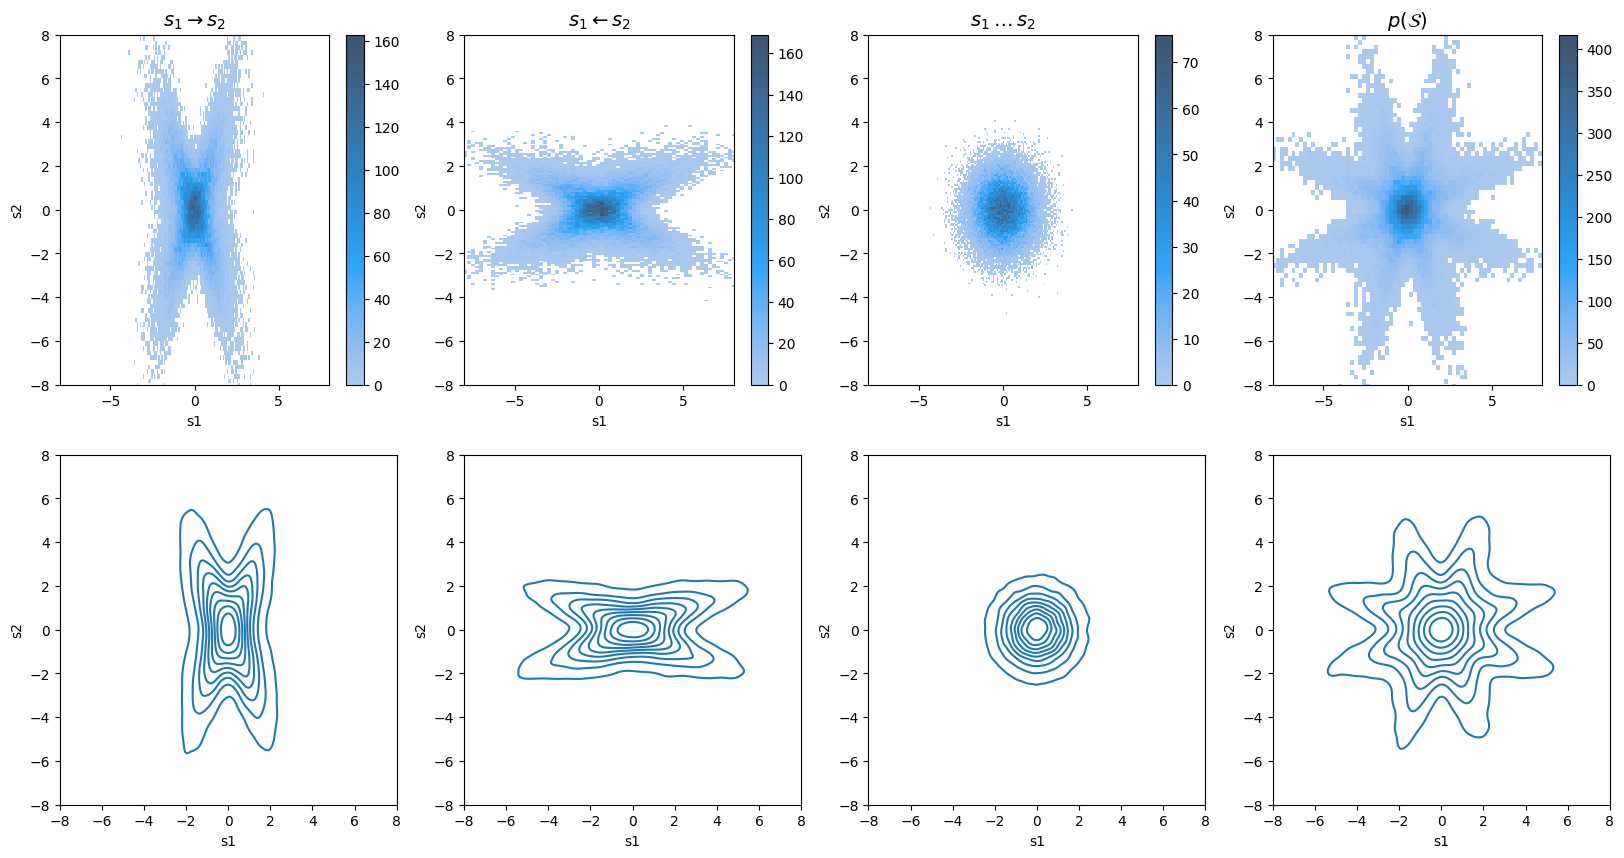

In [14]:
S_samples_G1_df = pd.DataFrame(np.array(S_samples_G1_bunif_Wunif).reshape(-1,2), columns=['s1', 's2'])
S_samples_G2_df = pd.DataFrame(np.array(S_samples_G2_bunif_Wunif).reshape(-1,2), columns=['s1', 's2'])
S_samples_G3_df = pd.DataFrame(np.array(S_samples_G3_bunif_Wunif).reshape(-1,2), columns=['s1', 's2'])
S_samples_Gall_100_df_b0_Wsunif = pd.DataFrame(np.array(S_samples_Gall_bunif_Wunif_100).reshape(-1,2), columns=['s1', 's2'])

ax_lim = (-8,8)

plt.rc('axes', titlesize=14)

fig, axes = plt.subplots(2, 4, figsize=(5*4, 5*2))

sns.histplot(S_samples_G1_df, x='s1', y='s2', bins=100, cbar=True, ax=axes[0,0], legend=False)
sns.kdeplot(S_samples_G1_df, x='s1', y='s2', thresh=0.05, ax=axes[1,0])
# axes[0,0].set_title(f's1 → s2')
axes[0,0].set_title(r'$s_1 \rightarrow s_2$')

sns.histplot(S_samples_G2_df, x='s1', y='s2', bins=100, cbar=True, ax=axes[0,1], legend=False)
sns.kdeplot(S_samples_G2_df, x='s1', y='s2', thresh=0.05, ax=axes[1,1])
axes[0,1].set_title(r'$s_1 \leftarrow s_2$')

sns.histplot(S_samples_G3_df, x='s1', y='s2', bins=100, cbar=True, ax=axes[0,2], legend=False)
sns.kdeplot(S_samples_G3_df, x='s1', y='s2', thresh=0.05, ax=axes[1,2])
axes[0,2].set_title(r'$s_1 \dots s_2$')

sns.histplot(S_samples_Gall_100_df_b0_Wsunif, x='s1', y='s2', bins=100, cbar=True, ax=axes[0,3], legend=False)
sns.kdeplot(S_samples_Gall_100_df_b0_Wsunif, x='s1', y='s2', thresh=0.05, ax=axes[1,3])
axes[0,3].set_title(r'$p(\mathcal{S})$')

for ax in axes.ravel():
    ax.set_xlim(ax_lim)
    ax.set_ylim(ax_lim)

plt.show()
# plt.savefig('results/figures/d2_prior.png', transparent=False, dpi=300)

# RESULTS d=2

In [15]:
# [tested] cool-gorge-1076 - tag: VAEjax2_meta20_b20_s11_sdec11_MC1000_N500_d2_bias0_lamb09_wd1e2_lr1e3_SMALLenc_cov_morenoise_signedunif3_kaimingunif_CORRECT_8
# [not used] ancient-energy-1099 - tag: VAEjax2_meta20_b20_s11_sdec11_MC1000_N500_d2_bias0_lamb09_wd1e2_lr1e3_LARGEenc_AVICIcov_morenoise_signedunif3_loss1_CORRECT_18

tag = 'VAEjax2_meta20_b20_s11_sdec11_MC1000_N500_d2_bias0_lamb09_wd1e2_lr1e3_SMALLenc_cov_morenoise_signedunif3_kaimingunif_CORRECT_8'
epoch = 2000

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
restored_state = orbax_checkpointer.restore(f'results/trained_models/{tag}/{epoch}/default/')
config_file = f'results/trained_models/config_run_vae_train_{tag}.yaml'

VAE_d2 = load_model(config_file, model='VAE2')

In [16]:
seed = 0
num_samples=200

S_samples = empirical_latent_prior(seed, num_samples, config_file)
S_samples = rearrange(S_samples, 's N d -> (s N) d')
S_samples_df = pd.DataFrame(np.asarray(S_samples), columns=['s1', 's2'])


mechanism_params:
{'biases_distr': <Uniform at 0x104133e10: low=0.0 high=0.0>,
 'noise_distr': <Gaussian at 0x2a74f6510: mean=0.0 scale=1.0>,
 'noise_scale_distr': <Uniform at 0x2a3c492d0: low=1.0 high=1.0>,
 'weights_distr': <SignedUniform at 0x2a49cf410: low=0.5 high=3.0>}

technical_noise_params:
{'additional_noise_distr': <Gaussian_jax at 0x2a4b619d0: mean=0.0 scale=1.0>,
 'additional_noise_std_distr': <Uniform_jax at 0x2a75e5e90: low=0.5 high=2.0>}

graph_distr:
<ErdosRenyi at 0x2a4b61dd0: edges_per_var=2.0>

dataset_params:
{'num_observations': 500,
 'num_observations_int': 0,
 'num_variables': 2,
 'rng_np': Generator(PCG64) at 0x2A7686DC0}


In [17]:
with open(config_file, 'r') as config_file_:
    config = yaml.safe_load(config_file_)

prior_kwargs = parse_config(config, config_key='prior')
prior = LatentPrior(**prior_kwargs)

## other plots

In [18]:
def visualize_results_jax_custom4(dataset, vae, prior, latent_prior_samples, restored_state, title): # for VAEtjax
    
    # plt.rc('axes', labelsize=12)
    # plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=12) 
    
    size_medium = 16
    plt.rc('axes', titlesize=size_medium)
    plt.rc('axes', labelsize=size_medium)
    plt.rc('xtick', labelsize=size_medium)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size_medium)    # fontsize of the tick labels
    plt.rc('legend', fontsize=size_medium)

    data = dataset.get_original()

    if dataset.get_noisy() is not None:
        data_noisy = dataset.get_noisy()
    else:
        data_noisy = dataset.get_original()
        print(f'dataset.get_noisy(): {dataset.get_noisy()} so using add-noise free original data')
    
    # l_lim = min((data_noisy[:, 0].min() - 3),(data_noisy[:, 1].min() - 3)).item()
    # u_lim = max((data_noisy[:, 0].max() + 3),(data_noisy[:, 1].max() + 3)).item()
    
    l_lim, u_lim = -12, 12

    x_lin = torch.linspace(l_lim, u_lim, 100)
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(6*5, 6))
    fig.subplots_adjust(top=0.8)

    
    #-------------------------------------------------------------------------
    
    w_fix = (dataset.G * dataset.W)[(dataset.G * dataset.W) != 0]
    bias_fix_1 = dataset.b[0].item()
    bias_fix_2 = dataset.b[1].item()
    
    if dataset.G[0,1] == 1: # s1 --> s2
        # print(f's1 --> s2')
        # print(f'w_fix: {w_fix}')
        slope, intercept = np.polyfit(data[:, 0], data[:, 1], deg=1)
        graph = f's1 --> s2'
        label_true =      f's2|s1 = {w_fix.item():.2f}*s1 + {bias_fix_2:.2f} + e2   - true       '
        label_empirical = f's2|s1 = {slope:.2f}*s1 + {intercept:.2f} + e2   - empirical'
    elif dataset.G[1,0] == 1: # s1 <-- s2
        # print(f's1 <-- s2')
        # print(f'w_fix: {w_fix}')
        slope, intercept = np.polyfit(data[:, 1], data[:, 0], deg=1)
        graph = f's1 <-- s2'
        label_true =      f's1|s2 = {w_fix.item():.2f}*s2 + {bias_fix_2:.2f} + e1   - true       '
        label_empirical = f's1|s2 = {slope:.2f}*s2 + {intercept:.2f} + e1   - empirical'
    elif (dataset.G[1,0] == 0).all():
        slope, intercept = np.polyfit(data[:, 1], data[:, 0], deg=1)
        graph = f's1 ... s2'
        label_true =      f's1|s2 = 0*s2 + {bias_fix_2:.2f} + e1         - true      '
        label_empirical = f's1|s2 = {slope:.2f}*s2 + {intercept:.2f} + e1   - empirical'
    
    slope_plot, intercept_plot = np.polyfit(data[:, 0], data[:, 1], deg=1)
    label_fitted = f'fitted slope: {slope_plot.item():.2f}, intercept: {intercept_plot.item():.2f}'
    
    data_df = pd.DataFrame(data, columns=['s1', 's2'])
    data_noisy_df = pd.DataFrame(data_noisy, columns=['x1', 'x2'])
    
    confidence = 0.95
    sample_index = 2 # vae.enc produces s=num_s_samples samples from learned q(S) so sample_index defines which one of these S(1)...S(100) samples we'll use further
    rec, C_1, S_learned_1, S_learned_all, D_decoded_1, D_decoded_all, CI_var1, CI_var2, CI_cov = get_outputs_jax(dataset, vae, prior, confidence, sample_index, restored_state)
    
    slope1, intercept1 = np.polyfit(S_learned_all[:, 0], S_learned_all[:, 1], deg=1)
    slope2, intercept2 = np.polyfit(D_decoded_all[:, 0], D_decoded_all[:, 1], deg=1)
    slope3, intercept3 = np.polyfit(data_noisy[:, 0], data_noisy[:, 1], deg=1)
    
    #
    ax1.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', marker="o", label='true signal')
    # ax1.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'{label_fitted}')
    ax1.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'slope')
    # ax1.legend(loc='upper left')
    ax1.set_xlabel('s1')
    ax1.set_ylabel('s2')
    # ax1.set_title(f'{graph} \n{label_true} \n{label_empirical}')
    ax1.set_title(f'true signal \n{graph}')
    ax1.set_xlim(l_lim, u_lim)
    ax1.set_ylim(l_lim, u_lim)
    
    #
    ax2.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', alpha=1, marker="o", label='true signal')
    ax2.scatter(data_noisy[:, 0], data_noisy[:, 1], s=10, c='darkgreen', marker="o", label='noisy dataset')
    sns.kdeplot(data_df, x='s1', y='s2', color='mediumseagreen', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax2)
    sns.kdeplot(data_noisy_df, x='x1', y='x2', color='darkgreen', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax2)
    ax2.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'slope')
    # ax2.set_title(f'cov matrix of additional noise distr: \n{np.around(dataset.C,2)}')
    ax2.set_title(f'noisy dataset \ntechnical noise covariance matrix: \n{np.around(dataset.C,2)}')
    # ax2.legend(loc='upper left')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_xlim(l_lim, u_lim)
    ax2.set_ylim(l_lim, u_lim)
    
    #
    ax3.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', marker="o", label='true signal')              # one true S dataset 
    ax3.scatter(S_learned_1[:, 0], S_learned_1[:, 1], s=10, c='royalblue', marker="o", label='learned signal')  # one predicted S dataset corresponding to D
    ax3.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'true slope') # one true S dataset - fitted slope
    ax3.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue', label=f'learned slope')          # 10 predicted S datasets form learned q(S) - fitted slope
    sns.kdeplot(data_df, x='s1', y='s2', color='mediumseagreen', levels=[0.05], alpha=1, ax=ax3)                # one true S dataset - contours
    sns.kdeplot(S_learned_all.df, x='s1', y='s2', color='royalblue', levels=[0.05], alpha=1, ax=ax3)            # 10 predicted S datasets form learned q(S) - contours
    sns.kdeplot(latent_prior_samples, x='s1', y='s2', color='grey', levels=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75], ax=ax3, label=f'contours of the signal prior')
    ax3.set_title(f'true signal vs. learned signal')
    # ax3.legend(loc='upper left')
    ax3.set_xlabel('s1')
    ax3.set_ylabel('s2')
    ax3.set_xlim(l_lim, u_lim)
    ax3.set_ylim(l_lim, u_lim)
    
    #
    ax4.scatter(D_decoded_1[:, 0], D_decoded_1[:, 1], s=10, c='darkblue', marker="o", label='decoded dataset')             # scatter of one sample D from p_D = torch.distributions.MultivariateNormal(S_learned, C)
    ax4.scatter(S_learned_1[:, 0], S_learned_1[:, 1], s=10, c='royalblue', marker="o", label='learned signal')    # scatter of mean=S_learned of p_D = torch.distributions.MultivariateNormal(S_learned, C)
    # ax4.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'fitted line')
    # ax4.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue', label=f'fitted line')
    sns.kdeplot(D_decoded_all.df, x='x1', y='x2', color='darkblue', levels=[0.05], label=f'0.95 contours', alpha=0.8, ax=ax4) # contours of 10 samples D1...D10 from p_D = torch.distributions.MultivariateNormal(S_learned, C)
    sns.kdeplot(S_learned_1.df, x='s1', y='s2', color='royalblue', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax4)    # contours of mean=S_learned of p_D = torch.distributions.MultivariateNormal(S_learned, C)
    ax4.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue', label=f'learned slope')
    # ax4.legend(loc='upper left')
    ax4.set_xlabel('x1')
    ax4.set_ylabel('x2')
    # ax4.set_title(f'\npredicted cov matrix C of additional noise distr: \n{np.around(C_1,1)}')
    # ax4.set_title(f'decoded dataset \npredicted technical noise covariance matrix: \n{np.around(C_1[0],2)}')
    ax4.set_title(f'decoded dataset \npredicted technical noise covariance matrix: \n{np.array([[2.15,1.85],[1.85,1.60]])}')
    ax4.set_xlim(l_lim, u_lim)
    ax4.set_ylim(l_lim, u_lim)
       
    #
    ax5.scatter(data_noisy[:, 0], data_noisy[:, 1], s=10, c='darkgreen', marker="o", label='noisy dataset')
    ax5.scatter(D_decoded_1[:, 0], D_decoded_1[:, 1], s=10, c='darkblue', marker="o", label='decoded dataset')
    # ax5.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'fitted line')
    ax5.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue', label=f'learned slope')
    # ax5.plot(x_lin, x_lin*slope3+intercept3, ls="--", color='darkgreen', linewidth=1, label=f'fitted line')
    sns.kdeplot(data_noisy_df, x='x1', y='x2', color='darkgreen', levels=[0.05], label=f'0.95 contours', alpha=0.8, ax=ax5)
    sns.kdeplot(D_decoded_all.df, x='x1', y='x2', color='darkblue', levels=[0.05], label=f'0.95 contours', alpha=0.8, ax=ax5)
    ax5.set_title(f'noisy dataset vs. decoded dataset')
    # ax5.legend(loc='upper left')
    ax5.set_xlabel('x1')
    ax5.set_ylabel('x2')
    # ax5.set_title(f'data: given & decoded \nrec loss: {rec:.3f} \n{(confidence*100):.0f}% CI for E[var_1]:  CI=[{CI_var1[0]:.3f},{CI_var1[1]:.3f}], width: {(CI_var1[1]-CI_var1[0]):.3f} \n{(confidence*100):.0f}% CI for E[var_2]:  CI=[{CI_var2[0]:.3f},{CI_var2[1]:.3f}], width: {(CI_var2[1]-CI_var2[0]):.3f} \n{(confidence*100):.0f}% CI for E[cov_ij]: CI=[{CI_cov[0]:.3f},{CI_cov[1]:.3f}], width: {(CI_cov[1]-CI_cov[0]):.3f}')
    ax5.set_xlim(l_lim, u_lim)
    ax5.set_ylim(l_lim, u_lim)
    
    if title is not None:
        fig.suptitle(title, fontsize='x-large', weight='bold', y=0.98)
    else:
        pass
    
    m = -0.09
    ax1.yaxis.set_label_coords(m, 0.5)
    ax2.yaxis.set_label_coords(m, 0.5)  # Adjust the -0.1 value as needed
    ax3.yaxis.set_label_coords(m, 0.5)  # Adjust the -0.1 value as needed
    ax4.yaxis.set_label_coords(m, 0.5)  # Adjust the -0.1 value as needed
    ax5.yaxis.set_label_coords(m, 0.5) 
    
    # ax2.set_yticks([])
    # ax3.set_yticks([])
    # ax4.set_yticks([])
    # ax5.set_yticks([])
    
    plt.show()
    
    # plt.savefig('results/figures/d2_VAE_results_4.png', transparent=False, dpi=300)

mechanism: linearGBN
w_ij in dataset 1: -3.0
[[0 1]
 [0 0]] - graph in dataset 1
---VAE: encoder
x shape into encoder layer: (1, 500, 2) 	 continue: False
x shape into encoder sublayer: (1, 500, 2, 32)
x shape into encoder sublayer: (1, 2, 500, 32)
x shape into encoder sublayer: (1, 500, 2, 32)
x shape into encoder sublayer: (1, 2, 500, 32)
x shape out from encoder layer: (1, 500, 2, 32) - for [b N d k] or [s b N d k]
---VAE: reparameterize
----- reconstruction (NLL) -----
(1, 2, 2) - C initial shape
10 - srec
(10, 1, 500, 2, 2) - C
(10, 1, 500, 2) - enc_output = S
(10, 1, 500) - log_probs
----- KL divergence -----
(1, 500, 2) - mu shape
(1, 500, 2) - mu
-------------------------
mu: (11, 1, 1000, 500, 2)
noise_std: (1, 1000, 500, 2)
sig: (11, 1, 1000, 500, 2)


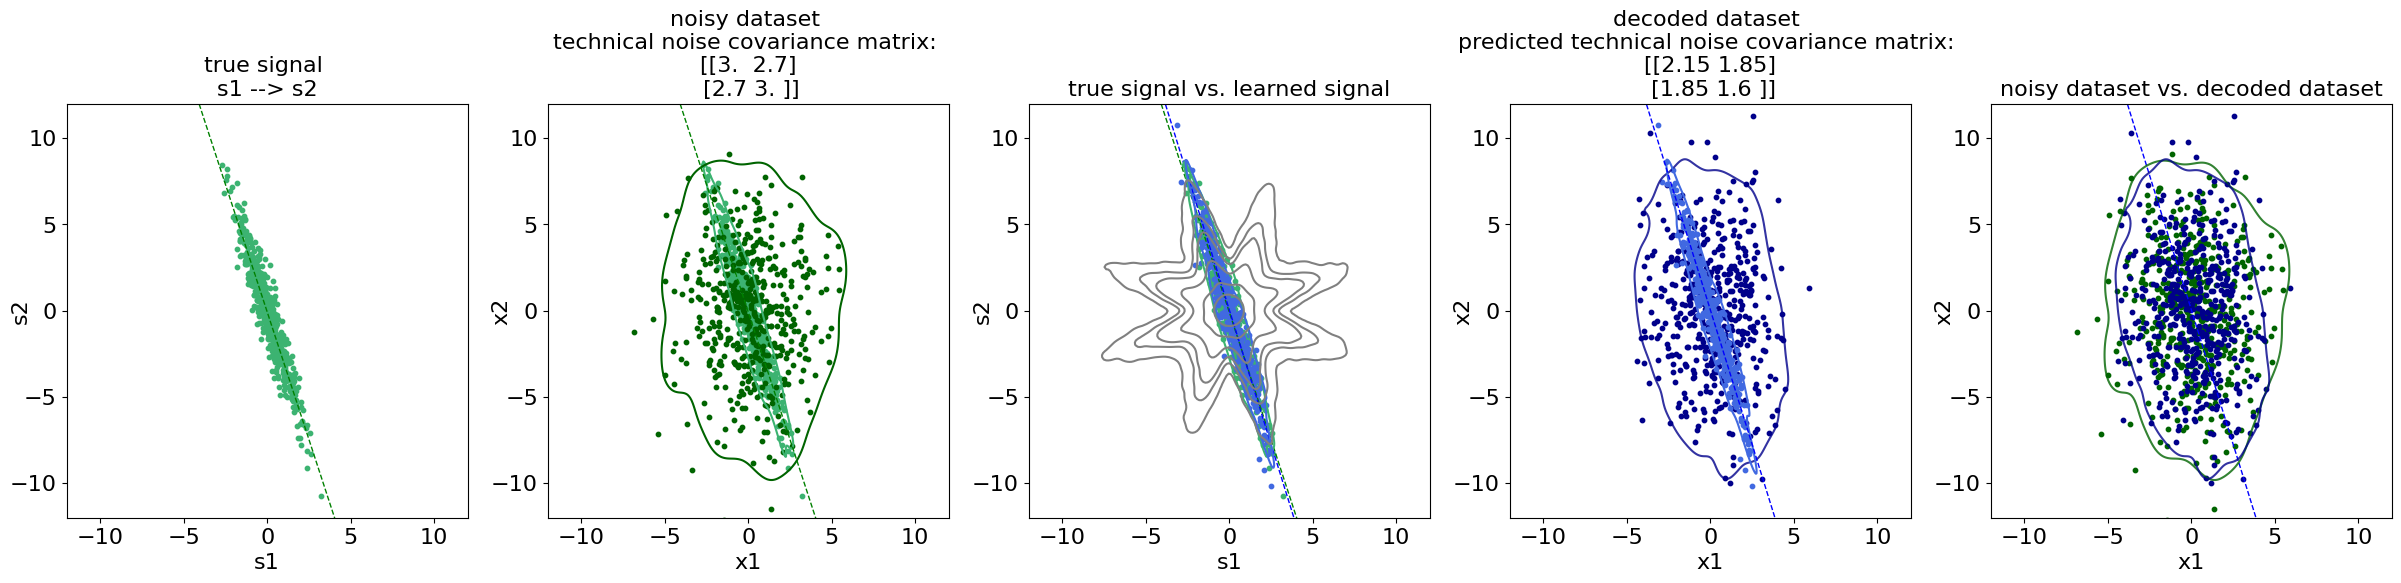

In [19]:
w_distr = Uniform(-3,-3)
b_distr = Uniform(0,0)
additional_noise_distr = Gaussian()
additional_noise_std_distr = Uniform_jax(np.sqrt(3),np.sqrt(3))

graph = np.array([[0,1],[0,0]]) # s1 -> s2
# graph = np.array([[0,0],[1,0]]) # s1 <- s2
# graph = np.array([[0,0],[0,0]]) # s1  s2
# graph = None


index=1
seed=8
dataset = get_one_dataset(index, seed, config_file, w_distr=w_distr, b_distr=b_distr, additional_noise_distr=additional_noise_distr, additional_noise_std_distr=additional_noise_std_distr, graph=graph)

visualize_results_jax_custom4(dataset, VAE_d2, prior, S_samples_df, restored_state, title=None)

## Figure 5.2

In [20]:
def visualize_results_jax(dataset, vae, prior, latent_prior_samples, restored_state, title): # for VAEtjax

    sz=18
    plt.rc('axes', titlesize=sz)
    plt.rc('axes', labelsize=sz)
    plt.rc('xtick', labelsize=sz)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sz)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sz)
    
    data = dataset.get_original()

    if dataset.get_noisy() is not None:
        data_noisy = dataset.get_noisy()
    else:
        data_noisy = dataset.get_original()
        print(f'dataset.get_noisy(): {dataset.get_noisy()} so using add-noise free original data')
    
    # l_lim = min((data_noisy[:, 0].min() - 3),(data_noisy[:, 1].min() - 3)).item()
    # u_lim = max((data_noisy[:, 0].max() + 3),(data_noisy[:, 1].max() + 3)).item()
    
    l_lim, u_lim = -12, 12

    x_lin = torch.linspace(l_lim, u_lim, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
    fig.subplots_adjust(top=0.8)
    
    #-------------------------------------------------------------------------
    
    w_fix = (dataset.G * dataset.W)[(dataset.G * dataset.W) != 0]
    bias_fix_1 = dataset.b[0].item()
    bias_fix_2 = dataset.b[1].item()
    
    if dataset.G[0,1] == 1: # s1 --> s2
        # print(f's1 --> s2')
        # print(f'w_fix: {w_fix}')
        slope, intercept = np.polyfit(data[:, 0], data[:, 1], deg=1)
        graph = f's1 --> s2'
        label_true =      f's2|s1 = {w_fix.item():.2f}*s1 + {bias_fix_2:.2f} + e2   - true       '
        label_empirical = f's2|s1 = {slope:.2f}*s1 + {intercept:.2f} + e2   - empirical'
    elif dataset.G[1,0] == 1: # s1 <-- s2
        # print(f's1 <-- s2')
        # print(f'w_fix: {w_fix}')
        slope, intercept = np.polyfit(data[:, 1], data[:, 0], deg=1)
        graph = f's1 <-- s2'
        label_true =      f's1|s2 = {w_fix.item():.2f}*s2 + {bias_fix_2:.2f} + e1   - true       '
        label_empirical = f's1|s2 = {slope:.2f}*s2 + {intercept:.2f} + e1   - empirical'
    elif (dataset.G[1,0] == 0).all():
        slope, intercept = np.polyfit(data[:, 1], data[:, 0], deg=1)
        graph = f's1 ... s2'
        label_true =      f's1|s2 = 0*s2 + {bias_fix_2:.2f} + e1         - true      '
        label_empirical = f's1|s2 = {slope:.2f}*s2 + {intercept:.2f} + e1   - empirical'
    
    slope_plot, intercept_plot = np.polyfit(data[:, 0], data[:, 1], deg=1)
    label_fitted = f'fitted slope: {slope_plot.item():.2f}, intercept: {intercept_plot.item():.2f}'
    
    data_df = pd.DataFrame(data, columns=['s1', 's2'])
    data_noisy_df = pd.DataFrame(data_noisy, columns=['x1', 'x2'])
    
    confidence = 0.95
    sample_index = 2 # vae.enc produces s=num_s_samples samples from learned q(S) so sample_index defines which one of these S(1)...S(100) samples we'll use further
    # rec, C_1, S_learned_1, S_learned_all, D_decoded_1, D_decoded_all, CI_var1, CI_var2, CI_cov = get_outputs_jax(dataset, vae, prior, confidence, sample_index, restored_state)
    
    # slope1, intercept1 = np.polyfit(S_learned_all[:, 0], S_learned_all[:, 1], deg=1)
    # slope2, intercept2 = np.polyfit(D_decoded_all[:, 0], D_decoded_all[:, 1], deg=1)
    # slope3, intercept3 = np.polyfit(data_noisy[:, 0], data_noisy[:, 1], deg=1)
    slope4, intercept4 = np.polyfit(data_noisy[:, 0], data_noisy[:, 1], deg=1)
    
    #
    ax1.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', marker="o", label='true signal')
    ax1.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=3, color='mediumseagreen', label=f'slope (signal)') # label=r'$s_2=3 s_1 + \epsilon$'
    sns.kdeplot(latent_prior_samples, x='s1', y='s2', color='grey', levels=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75], label='contours of prior p(S)', ax=ax1)
    # ax1.legend(loc='upper left')
    ax1.set_xlabel('s1')
    ax1.set_ylabel('s2')
    # ax1.set_title(f'{graph} \n{label_true} \n{label_empirical}')
    # ax1.set_title(r'$\mathcal{S} = \{ \mathbf{s}^{(i)} \}_{i=1}^N$')
    # ax1.set_title('signal')
    ax1.set_title(f'true signal \n{graph}')
    ax1.set_xlim(l_lim, u_lim)
    ax1.set_ylim(l_lim, u_lim)
    
    #
    ax2.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', alpha=1, marker="o", label=r'$\text{true signal }\mathbf{s}$')
    ax2.scatter(data_noisy[:, 0], data_noisy[:, 1], s=10, c='darkgreen', marker="o", label=r'$\text{noisy observation }\mathbf{x}$')
    sns.kdeplot(data_df, x='s1', y='s2', color='mediumseagreen', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax2)
    sns.kdeplot(data_noisy_df, x='x1', y='x2', color='darkgreen', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax2)
    ax2.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=3, color='mediumseagreen', label=f'slope (signal)')
    ax2.plot(x_lin, x_lin*slope4+intercept4, ls="--", linewidth=3, color='darkgreen', label=f'slope (noisy)')
    # ax2.set_title(f'cov matrix of additional noise distr: \n{np.around(dataset.C,2)}')
    ax2.set_title(f'noisy dataset \ntechnical noise covariance: \n{np.around(dataset.C,2)}')
    # ax2.set_title(f'noisy data')
    # ax2.legend(loc='upper left')
    # ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_xlim(l_lim, u_lim)
    ax2.set_ylim(l_lim, u_lim)

    
    if title is not None:
        fig.suptitle(title, fontsize='x-large', weight='bold', y=0.98)
    else:
        pass
    
    kde_line = mlines.Line2D([], [], color='grey', label=r'$\text{contours of the prior }p(\mathcal{S})$')
    handles, labels = [], []
    for ax in [ax2]:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            handles.append(handle)
            labels.append(label)
    handles.append(kde_line)
    labels.append(r'$\text{contours of the prior }p(\mathcal{S})$')
    
    #
    kde_line1 = mlines.Line2D([], [], color='mediumseagreen')
    handles.append(kde_line1)
    labels.append(r'$\text{contours of the true }\mathcal{S}$')
    
    kde_line2 = mlines.Line2D([], [], color='darkgreen')
    handles.append(kde_line2)
    labels.append(r'$\text{contours of the noisy }\mathcal{D}$')
    
    ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 0.7), borderaxespad=0.)
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.8) 
    plt.show()
    
    # plt.savefig('results/figures/d2_signal_noise_bigger.png', transparent=False, dpi=500)

In [21]:
#--- uncomment for saving images
# plt.rcParams['figure.dpi'] = 500 

#--- uncomment to reset to default params
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

mechanism: linearGBN
w_ij in dataset 1: -3.0
[[0 1]
 [0 0]] - graph in dataset 1


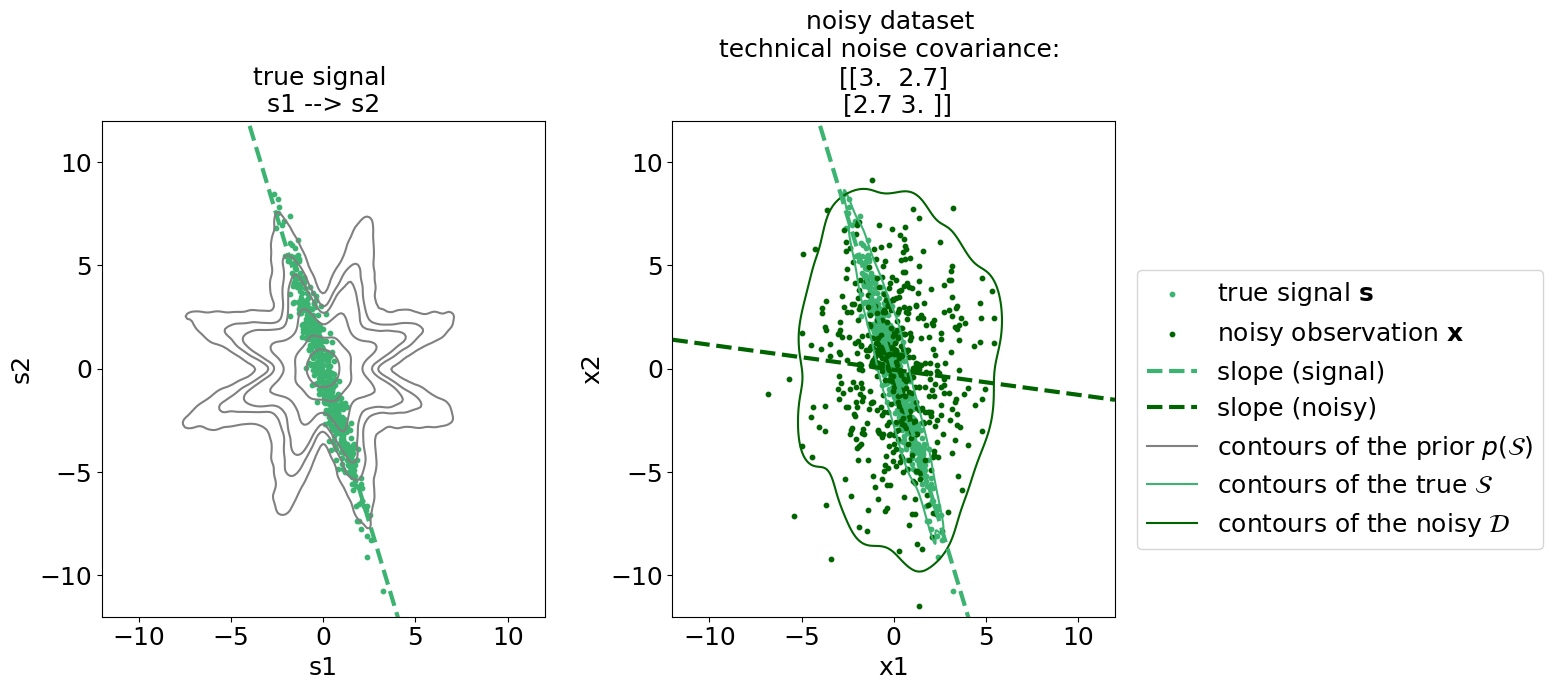

In [22]:
w_distr = Uniform(-3,-3)
b_distr = Uniform(0,0)
additional_noise_distr = Gaussian()
additional_noise_std_distr = Uniform_jax(np.sqrt(3),np.sqrt(3))

graph = np.array([[0,1],[0,0]]) # s1 -> s2
# graph = np.array([[0,0],[1,0]]) # s1 <- s2
# graph = np.array([[0,0],[0,0]]) # s1  s2
# graph = None


index=1
seed=8
dataset = get_one_dataset(index, seed, config_file, w_distr=w_distr, b_distr=b_distr, additional_noise_distr=additional_noise_distr, additional_noise_std_distr=additional_noise_std_distr, graph=graph)

visualize_results_jax(dataset, VAE_d2, prior, S_samples_df, restored_state, title=None)

## Figure 5.3

In [23]:
def visualize_results_jax_custom2(dataset, vae, prior, latent_prior_samples, restored_state, title): # for VAEtjax
    
    # plt.rc('axes', labelsize=12)
    # plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=12) 
    
    size_medium = 16
    plt.rc('axes', titlesize=size_medium)
    plt.rc('axes', labelsize=size_medium)
    plt.rc('xtick', labelsize=size_medium)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size_medium)    # fontsize of the tick labels
    plt.rc('legend', fontsize=size_medium-2)

    data = dataset.get_original()

    if dataset.get_noisy() is not None:
        data_noisy = dataset.get_noisy()
    else:
        data_noisy = dataset.get_original()
        print(f'dataset.get_noisy(): {dataset.get_noisy()} so using add-noise free original data')
    
    # l_lim = min((data_noisy[:, 0].min() - 3),(data_noisy[:, 1].min() - 3)).item()
    # u_lim = max((data_noisy[:, 0].max() + 3),(data_noisy[:, 1].max() + 3)).item()
    
    l_lim, u_lim = -12, 12

    x_lin = torch.linspace(l_lim, u_lim, 100)
    
    fig, ((ax1, ax2), (ax3, ax5)) = plt.subplots(2, 2, figsize=(6*2, 6*2))
    # fig.subplots_adjust(top=0.8)

    
    #-------------------------------------------------------------------------
    
    w_fix = (dataset.G * dataset.W)[(dataset.G * dataset.W) != 0]
    bias_fix_1 = dataset.b[0].item()
    bias_fix_2 = dataset.b[1].item()
    
    if dataset.G[0,1] == 1: # s1 --> s2
        # print(f's1 --> s2')
        # print(f'w_fix: {w_fix}')
        slope, intercept = np.polyfit(data[:, 0], data[:, 1], deg=1)
        graph = f's1 --> s2'
        label_true =      f's2|s1 = {w_fix.item():.2f}*s1 + {bias_fix_2:.2f} + e2   - true       '
        label_empirical = f's2|s1 = {slope:.2f}*s1 + {intercept:.2f} + e2   - empirical'
    elif dataset.G[1,0] == 1: # s1 <-- s2
        # print(f's1 <-- s2')
        # print(f'w_fix: {w_fix}')
        slope, intercept = np.polyfit(data[:, 1], data[:, 0], deg=1)
        graph = f's1 <-- s2'
        label_true =      f's1|s2 = {w_fix.item():.2f}*s2 + {bias_fix_2:.2f} + e1   - true       '
        label_empirical = f's1|s2 = {slope:.2f}*s2 + {intercept:.2f} + e1   - empirical'
    elif (dataset.G[1,0] == 0).all():
        slope, intercept = np.polyfit(data[:, 1], data[:, 0], deg=1)
        graph = f's1 ... s2'
        label_true =      f's1|s2 = 0*s2 + {bias_fix_2:.2f} + e1         - true      '
        label_empirical = f's1|s2 = {slope:.2f}*s2 + {intercept:.2f} + e1   - empirical'
    
    slope_plot, intercept_plot = np.polyfit(data[:, 0], data[:, 1], deg=1)
    label_fitted = f'fitted slope: {slope_plot.item():.2f}, intercept: {intercept_plot.item():.2f}'
    
    data_df = pd.DataFrame(data, columns=['s1', 's2'])
    data_noisy_df = pd.DataFrame(data_noisy, columns=['x1', 'x2'])
    
    confidence = 0.95
    sample_index = 2 # vae.enc produces s=num_s_samples samples from learned q(S) so sample_index defines which one of these S(1)...S(100) samples we'll use further
    rec, C_1, S_learned_1, S_learned_all, D_decoded_1, D_decoded_all, CI_var1, CI_var2, CI_cov = get_outputs_jax(dataset, vae, prior, confidence, sample_index, restored_state)
    
    slope1, intercept1 = np.polyfit(S_learned_all[:, 0], S_learned_all[:, 1], deg=1)
    slope2, intercept2 = np.polyfit(D_decoded_all[:, 0], D_decoded_all[:, 1], deg=1)
    slope3, intercept3 = np.polyfit(data_noisy[:, 0], data_noisy[:, 1], deg=1)
    
    #
    ax1.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', marker="o", label='true signal')
    # ax1.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'{label_fitted}')
    ax1.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'slope')
    # ax1.legend(loc='upper left')
    ax1.set_xlabel('s1')
    ax1.set_ylabel('s2')
    # ax1.set_title(f'{graph} \n{label_true} \n{label_empirical}')
    ax1.set_title(f'true signal \n{graph}')
    ax1.set_xlim(l_lim, u_lim)
    ax1.set_ylim(l_lim, u_lim)
    
    #
    ax2.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', alpha=1, marker="o", label='true signal')
    ax2.scatter(data_noisy[:, 0], data_noisy[:, 1], s=10, c='darkgreen', marker="o", label='noisy dataset')
    sns.kdeplot(data_df, x='s1', y='s2', color='mediumseagreen', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax2)
    sns.kdeplot(data_noisy_df, x='x1', y='x2', color='darkgreen', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax2)
    ax2.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'slope')
    # ax2.set_title(f'cov matrix of additional noise distr: \n{np.around(dataset.C,2)}')
    ax2.set_title(f'noisy dataset \ntechnical noise covariance: \n{np.around(dataset.C,2)}')
    # ax2.legend(loc='upper left')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_xlim(l_lim, u_lim)
    ax2.set_ylim(l_lim, u_lim)
    
    #
    ax3.scatter(data[:, 0], data[:, 1], s=10, c='mediumseagreen', marker="o", label=r'$\text{true signal }\mathbf{s}$')              # one true S dataset 
    ax3.scatter(S_learned_1[:, 0], S_learned_1[:, 1], s=10, c='royalblue', marker="o", label=r'$\text{learned signal }$')  # one predicted S dataset corresponding to D
    ax3.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'true slope') # one true S dataset - fitted slope
    ax3.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue', label=f'learned slope')          # 10 predicted S datasets form learned q(S) - fitted slope
    sns.kdeplot(data_df, x='s1', y='s2', color='mediumseagreen', levels=[0.05], alpha=1, ax=ax3)                # one true S dataset - contours
    sns.kdeplot(S_learned_all.df, x='s1', y='s2', color='royalblue', levels=[0.05], alpha=1, ax=ax3)            # 10 predicted S datasets form learned q(S) - contours
    # sns.kdeplot(latent_prior_samples, x='s1', y='s2', color='grey', levels=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75], ax=ax3, label=f'contours of the signal prior')
    sns.kdeplot(latent_prior_samples, x='s1', y='s2', color='grey', levels=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75], ax=ax3)
    ax3.set_title(f'true signal vs. learned signal')
    # ax3.legend(loc='upper left')
    ax3.set_xlabel('s1')
    ax3.set_ylabel('s2')
    ax3.set_xlim(l_lim, u_lim)
    ax3.set_ylim(l_lim, u_lim)
    
    #
    # ax4.scatter(D_decoded_1[:, 0], D_decoded_1[:, 1], s=10, c='darkblue', marker="o", label='decoded dataset')             # scatter of one sample D from p_D = torch.distributions.MultivariateNormal(S_learned, C)
    # ax4.scatter(S_learned_1[:, 0], S_learned_1[:, 1], s=10, c='royalblue', marker="o", label='learned signal')    # scatter of mean=S_learned of p_D = torch.distributions.MultivariateNormal(S_learned, C)
    # # ax4.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'fitted line')
    # # ax4.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue', label=f'fitted line')
    # sns.kdeplot(D_decoded_all.df, x='x1', y='x2', color='darkblue', levels=[0.05], label=f'0.95 contours', alpha=0.8, ax=ax4) # contours of 10 samples D1...D10 from p_D = torch.distributions.MultivariateNormal(S_learned, C)
    # sns.kdeplot(S_learned_1.df, x='s1', y='s2', color='royalblue', levels=[0.05], label=f'0.95 contours', alpha=1, ax=ax4)    # contours of mean=S_learned of p_D = torch.distributions.MultivariateNormal(S_learned, C)
    # ax4.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue', label=f'learned slope')
    # # ax4.legend(loc='upper left')
    # ax4.set_xlabel('x1')
    # ax4.set_ylabel('x2')
    # # ax4.set_title(f'\npredicted cov matrix C of additional noise distr: \n{np.around(C_1,1)}')
    # # ax4.set_title(f'decoded dataset \npredicted technical noise covariance matrix: \n{np.around(C_1[0],2)}')
    # ax4.set_title(f'decoded dataset \npredicted technical noise covariance matrix: \n{np.array([[2.15,1.85],[1.85,1.60]])}')
    # ax4.set_xlim(l_lim, u_lim)
    # ax4.set_ylim(l_lim, u_lim)
       
    #
    ax5.scatter(data_noisy[:, 0], data_noisy[:, 1], s=10, c='darkgreen', marker="o", label=r'$\text{noisy observation }\mathbf{x}$')
    ax5.scatter(D_decoded_1[:, 0], D_decoded_1[:, 1], s=10, c='darkblue', marker="o", label=r'$\text{decoded observation }$')
    # ax5.scatter(D_decoded_1[:, 0], D_decoded_1[:, 1], s=10, c='darkblue', marker="o", label=r'$\text{decoded observation }\mathbf{\hat{x}}$')
    # ax5.plot(x_lin, x_lin*slope_plot+intercept_plot, ls="--", linewidth=1, color='green', label=f'fitted line')
    ax5.plot(x_lin, x_lin*slope1+intercept1, ls="--", linewidth=1, color='blue')
    # ax5.plot(x_lin, x_lin*slope3+intercept3, ls="--", color='darkgreen', linewidth=1, label=f'fitted line')
    sns.kdeplot(data_noisy_df, x='x1', y='x2', color='darkgreen', levels=[0.05], label=f'0.95 contours', alpha=0.8, ax=ax5)
    sns.kdeplot(D_decoded_all.df, x='x1', y='x2', color='darkblue', levels=[0.05], label=f'0.95 contours', alpha=0.8, ax=ax5)
    # ax5.set_title(f'noisy dataset vs. decoded dataset')
    ax5.set_title(f'decoded dataset \npredicted technical noise covariance: \n{np.array([[2.15,1.85],[1.85,1.60]])}')
    # ax5.legend(loc='upper left')
    ax5.set_xlabel('x1')
    ax5.set_ylabel('x2')
    # ax5.set_title(f'data: given & decoded \nrec loss: {rec:.3f} \n{(confidence*100):.0f}% CI for E[var_1]:  CI=[{CI_var1[0]:.3f},{CI_var1[1]:.3f}], width: {(CI_var1[1]-CI_var1[0]):.3f} \n{(confidence*100):.0f}% CI for E[var_2]:  CI=[{CI_var2[0]:.3f},{CI_var2[1]:.3f}], width: {(CI_var2[1]-CI_var2[0]):.3f} \n{(confidence*100):.0f}% CI for E[cov_ij]: CI=[{CI_cov[0]:.3f},{CI_cov[1]:.3f}], width: {(CI_cov[1]-CI_cov[0]):.3f}')
    ax5.set_xlim(l_lim, u_lim)
    ax5.set_ylim(l_lim, u_lim)
    
    if title is not None:
        fig.suptitle(title, fontsize='x-large', weight='bold', y=0.98)
    else:
        pass
    
    m = -0.09
    ax1.yaxis.set_label_coords(m, 0.5)
    ax2.yaxis.set_label_coords(m, 0.5)  # Adjust the -0.1 value as needed
    ax3.yaxis.set_label_coords(m, 0.5)  # Adjust the -0.1 value as needed
    # ax4.yaxis.set_label_coords(m, 0.5)  # Adjust the -0.1 value as needed
    ax5.yaxis.set_label_coords(m, 0.5) 
    
    ax1.set_aspect('equal', adjustable='box')
    ax2.set_aspect('equal', adjustable='box')
    ax3.set_aspect('equal', adjustable='box')
    ax5.set_aspect('equal', adjustable='box')
    
    
    fig.subplots_adjust(hspace=0.8, wspace=-0.4)  # Adjust this value as needed
    
    # kde_patch = mpatches.Patch(color='grey', label='contours of the signal prior')
    kde_line = mlines.Line2D([], [], color='grey', label='contours of the signal prior')





    handles, labels = [], []
    for ax in [ax3, ax5]:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            handles.append(handle)
            labels.append(label)
    # handles.append(kde_patch)
    handles.append(kde_line)
    labels.append(r'$\text{contours of the prior }p(\mathcal{S})$')
    
    #
    kde_line1 = mlines.Line2D([], [], color='mediumseagreen')
    handles.append(kde_line1)
    labels.append(r'$\text{contours of the true }\mathcal{S}$')
    
    kde_line2 = mlines.Line2D([], [], color='darkgreen')
    handles.append(kde_line2)
    labels.append(r'$\text{contours of the noisy }\mathcal{D}$')
    
    kde_line3 = mlines.Line2D([], [], color='royalblue')
    handles.append(kde_line3)
    labels.append(r'$\text{contours of the learned }\mathcal{\hat{S}}$')
    
    kde_line4 = mlines.Line2D([], [], color='darkblue')
    handles.append(kde_line4)
    labels.append(r'$\text{contours of the decoded }\mathcal{\hat{D}}$')
    
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.91, 0.58), borderaxespad=0.)
    
    
    
    

    
    # original_handles, labels = [], []
    # for ax in [ax3, ax5]:
    #     handles, labels_ax = ax.get_legend_handles_labels()
    #     original_handles.extend(handles)
    #     labels.extend(labels_ax)

    # # Create new handles with larger markers
    # new_handles = []
    # for handle in original_handles:
    #     if hasattr(handle, 'set_markersize'):  # Check if the handle is a marker
    #         # Create a new handle with a larger marker size
    #         new_handle = mlines.Line2D([], [], color=handle.get_markerfacecolor(), 
    #                                 marker=handle.get_marker(), linestyle='None',
    #                                 markersize=20)  # Increase markersize as needed
    #         new_handles.append(new_handle)
    #     else:
    #         new_handles.append(handle)
            
    # new_handles.append(kde_line)
    # labels.append('contours of the signal prior')
    # fig.legend(new_handles, labels, loc='upper left', bbox_to_anchor=(0.93, 0.7), borderaxespad=0.)

    plt.tight_layout()
    fig.subplots_adjust(right=0.999)  
        
    plt.show()
    
    # plt.savefig('results/figures/d2_VAE_results_6.png', transparent=False, dpi=500)

In [24]:
#--- uncomment for saving images
# plt.rcParams['figure.dpi'] = 500 

#--- uncomment to reset to default params
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

mechanism: linearGBN
w_ij in dataset 1: -3.0
[[0 1]
 [0 0]] - graph in dataset 1
---VAE: encoder
x shape into encoder layer: (1, 500, 2) 	 continue: False
x shape into encoder sublayer: (1, 500, 2, 32)
x shape into encoder sublayer: (1, 2, 500, 32)
x shape into encoder sublayer: (1, 500, 2, 32)
x shape into encoder sublayer: (1, 2, 500, 32)
x shape out from encoder layer: (1, 500, 2, 32) - for [b N d k] or [s b N d k]
---VAE: reparameterize
----- reconstruction (NLL) -----
(1, 2, 2) - C initial shape
10 - srec
(10, 1, 500, 2, 2) - C
(10, 1, 500, 2) - enc_output = S
(10, 1, 500) - log_probs
----- KL divergence -----
(1, 500, 2) - mu shape
(1, 500, 2) - mu
-------------------------
mu: (11, 1, 1000, 500, 2)
noise_std: (1, 1000, 500, 2)
sig: (11, 1, 1000, 500, 2)


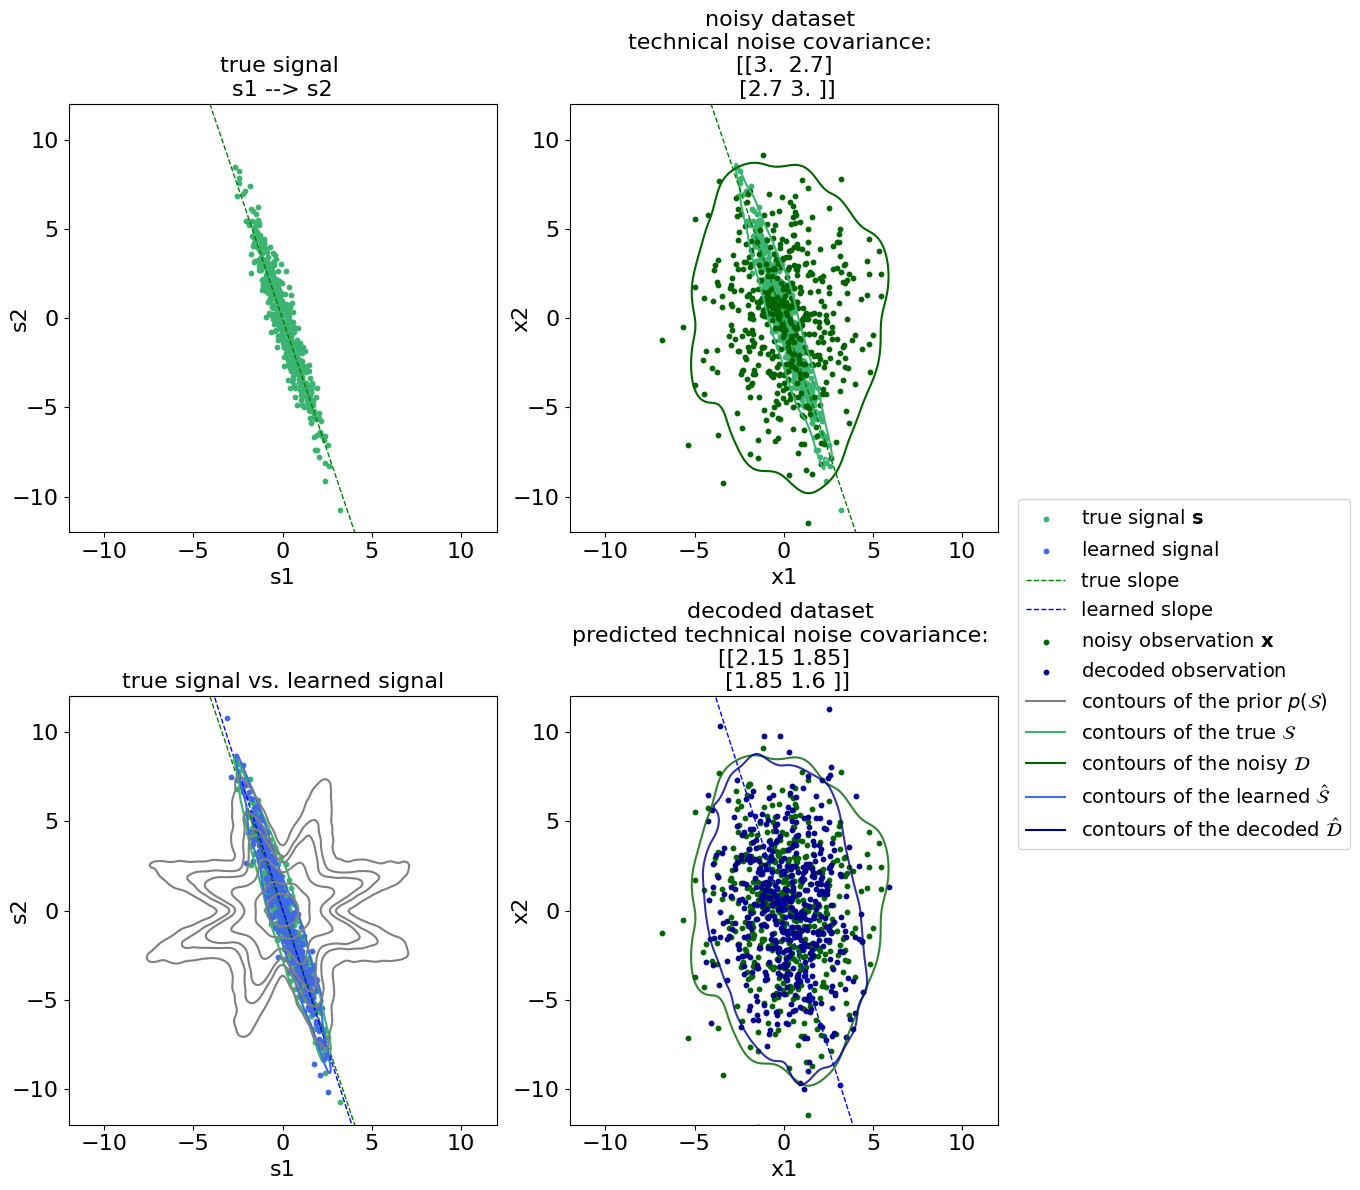

In [25]:
w_distr = Uniform(-3,-3)
b_distr = Uniform(0,0)
additional_noise_distr = Gaussian()
additional_noise_std_distr = Uniform_jax(np.sqrt(3),np.sqrt(3))

graph = np.array([[0,1],[0,0]]) # s1 -> s2
# graph = np.array([[0,0],[1,0]]) # s1 <- s2
# graph = np.array([[0,0],[0,0]]) # s1  s2
# graph = None


index=1
seed=8
dataset = get_one_dataset(index, seed, config_file, w_distr=w_distr, b_distr=b_distr, additional_noise_distr=additional_noise_distr, additional_noise_std_distr=additional_noise_std_distr, graph=graph)

visualize_results_jax_custom2(dataset, VAE_d2, prior, S_samples_df, restored_state, title=None)


# RESULTS d=4

## [d=4] experiment 2 - predicts cov (new VAE2) [GOOD] +plots

In [110]:
# zany-wave-900 - tag: VAEjax2_meta10_b10_s11_sdec1_MC1000_N500_d4_bias0_lamb09_wd1e2_lr1e2_enc4_cov_morenoise_sunif_kaimingunif - reproducing vague-firebrand-817

tag = 'VAEjax2_meta10_b10_s11_sdec1_MC1000_N500_d4_bias0_lamb09_wd1e2_lr1e2_enc4_cov_morenoise_sunif_kaimingunif'
epoch = 1000

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
restored_state = orbax_checkpointer.restore(f'results/trained_models/{tag}/{epoch}/default/')
config_file = f'results/trained_models/config_run_vae_train_{tag}.yaml'

VAE_d4 = load_model(config_file, model='VAE2')

## other plots

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[2.0411894 1.8370705 1.8370705 1.8370705]
 [1.8370705 2.0411894 1.8370705 1.8370705]
 [1.8370705 1.8370705 2.0411894 1.8370705]
 [1.8370705 1.8370705 1.8370705 2.0411894]] - true covariance matrix for additional noise

[[[2.5810075 2.538649  2.5639381 2.5439453]
  [2.538649  2.503433  2.5295653 2.509507 ]
  [2.5639381 2.5295653 2.5600085 2.5375202]
  [2.5439453 2.509507  2.5375202 2.518734 ]]] - predicted cov

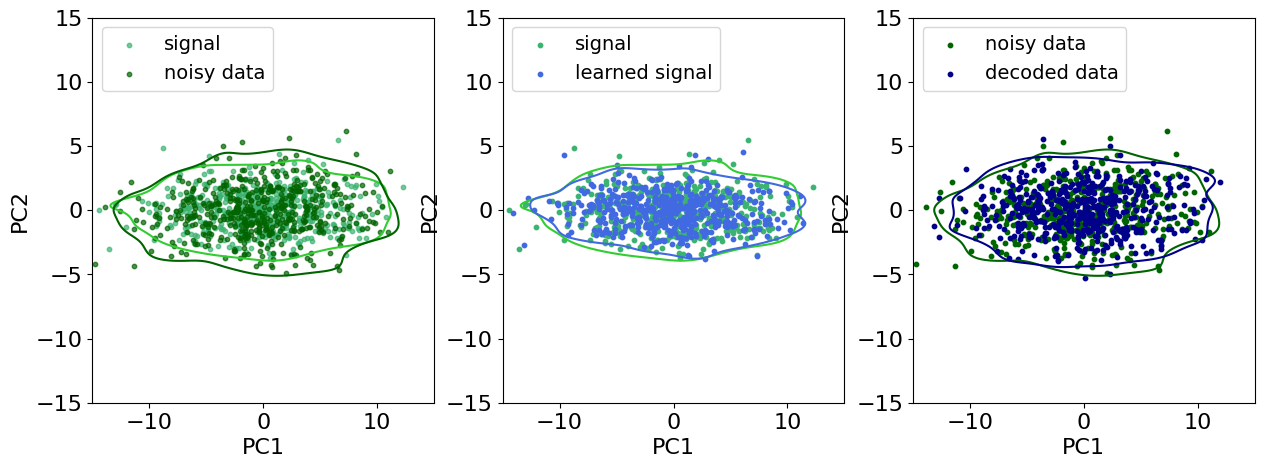

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.3773644 3.0396278 3.0396278 3.0396278]
 [3.0396278 3.3773644 3.0396278 3.0396278]
 [3.0396278 3.0396278 3.3773644 3.0396278]
 [3.0396278 3.0396278 3.0396278 3.3773644]] - true covariance matrix for additional noise

[[[2.871212  2.8704572 2.8639088 2.8996725]
  [2.8704572 2.8717284 2.8646488 2.8988187]
  [2.8639088 2.8646488 2.858858  2.892279 ]
  [2.8996725 2.8988187 2.892279  2.930916 ]]] - predicted cov

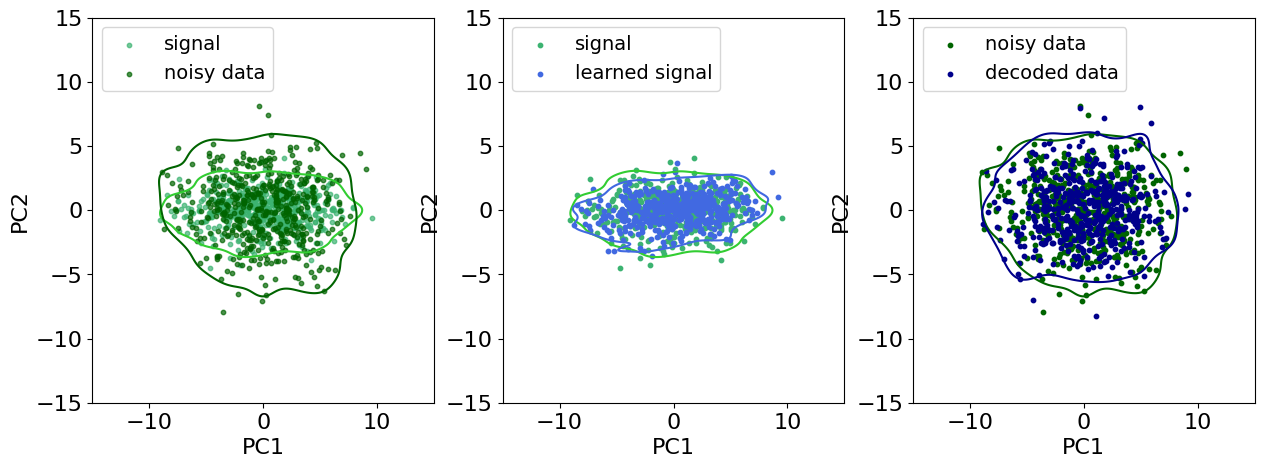

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.2202208 2.8981986 2.8981986 2.8981986]
 [2.8981986 3.2202208 2.8981986 2.8981986]
 [2.8981986 2.8981986 3.2202208 2.8981986]
 [2.8981986 2.8981986 2.8981986 3.2202208]] - true covariance matrix for additional noise

[[[2.6949654 2.680562  2.7313232 2.6833231]
  [2.680562  2.6725564 2.71795   2.676108 ]
  [2.7313232 2.71795   2.772649  2.7244956]
  [2.6833231 2.676108  2.7244956 2.7023695]]] - predicted cov

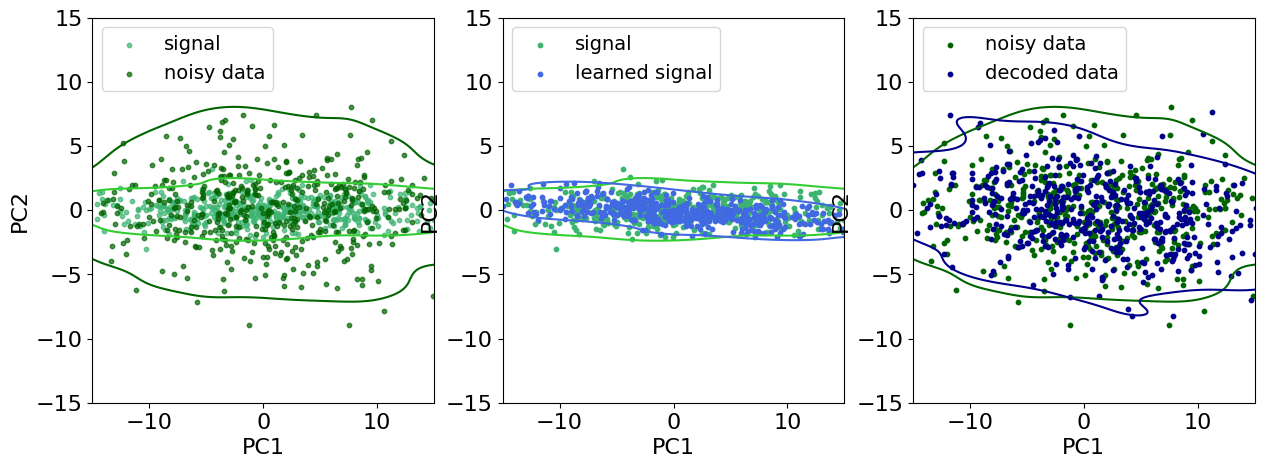

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.0231438 2.7208292 2.7208292 2.7208292]
 [2.7208292 3.0231438 2.7208292 2.7208292]
 [2.7208292 2.7208292 3.0231438 2.7208292]
 [2.7208292 2.7208292 2.7208292 3.0231438]] - true covariance matrix for additional noise

[[[3.0520926 2.9622164 2.9297795 3.0541945]
  [2.9622164 2.8869057 2.8568978 2.964571 ]
  [2.9297795 2.8568978 2.830145  2.9313686]
  [3.0541945 2.964571  2.9313686 3.0581222]]] - predicted cov

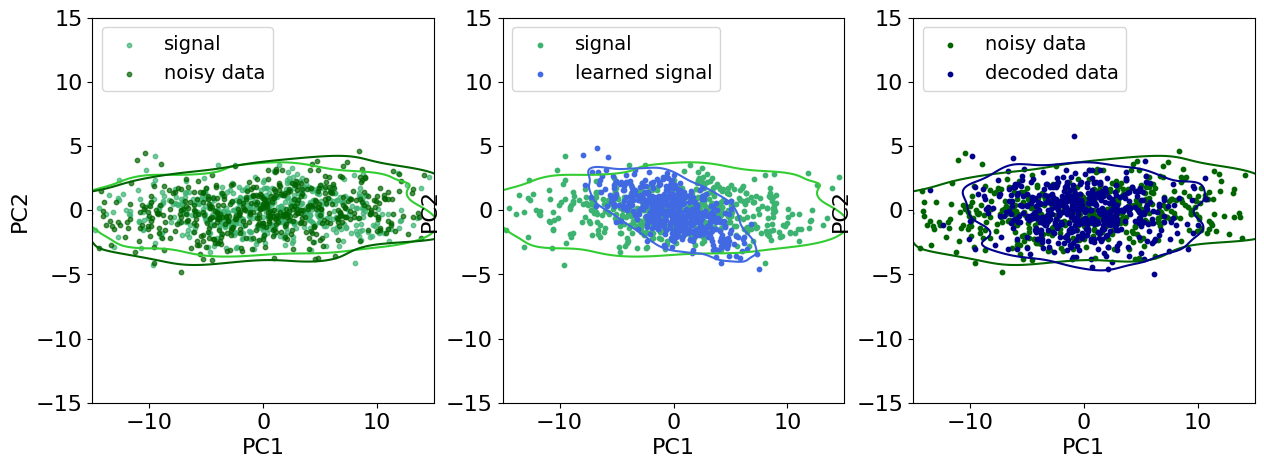

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[1.4087911 1.2679119 1.2679119 1.2679119]
 [1.2679119 1.4087911 1.2679119 1.2679119]
 [1.2679119 1.2679119 1.4087911 1.2679119]
 [1.2679119 1.2679119 1.2679119 1.4087911]] - true covariance matrix for additional noise

[[[2.3735673 2.3238544 2.2709436 2.3362498]
  [2.3238544 2.2833405 2.235895  2.2906148]
  [2.2709436 2.235895  2.2271261 2.2392583]
  [2.3362498 2.2906148 2.2392583 2.3015842]]] - predicted cov

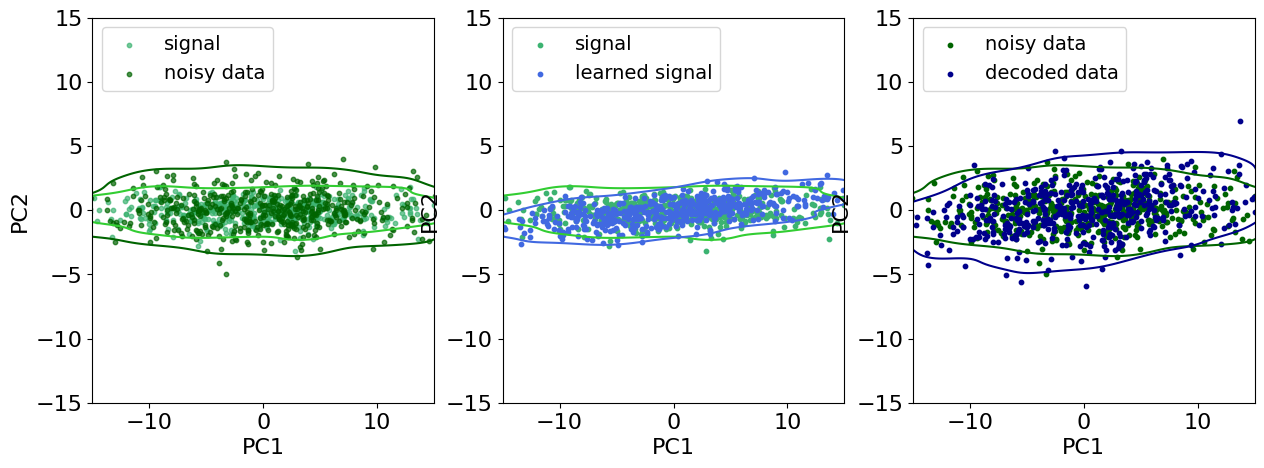

In [27]:
for i in range(5):
    
    dataset_index=i+1
    S_true, S_learned, D_decoded, dataset, Cov = get_predictions_VAE2(VAE_d4, restored_state, config_file, seed=1, num_obs=500, num_vars=4, batch_size=dataset_index) # batch size number here actually is an indicator that the last dataset in this batch is used for predictions

    sample_index=0
    S_true = S_true.squeeze()
    S_learned = S_learned[sample_index].squeeze()
    D_decoded = D_decoded[sample_index].squeeze()

    plot_pca(S_true, S_learned, D_decoded, dataset, Cov, axis_lim=(-15,15))

In [111]:
additional_noise_std_distr = Uniform_jax(2,2)

dataset_index=1 #1 #3
S_true, S_learned, D_decoded, dataset, Cov = get_predictions_VAE2(VAE_d4, restored_state, config_file, seed=1, num_obs=500, num_vars=4, batch_size=dataset_index, additional_noise_std_distr=additional_noise_std_distr) # batch size number here actually is an indicator that the last dataset in this batch is used for predictions

sample_index=0
S_true = S_true.squeeze()
S_learned = S_learned[sample_index].squeeze()
D_decoded = D_decoded[sample_index].squeeze()
D_noisy = dataset.get_noisy().squeeze()

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)


In [112]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

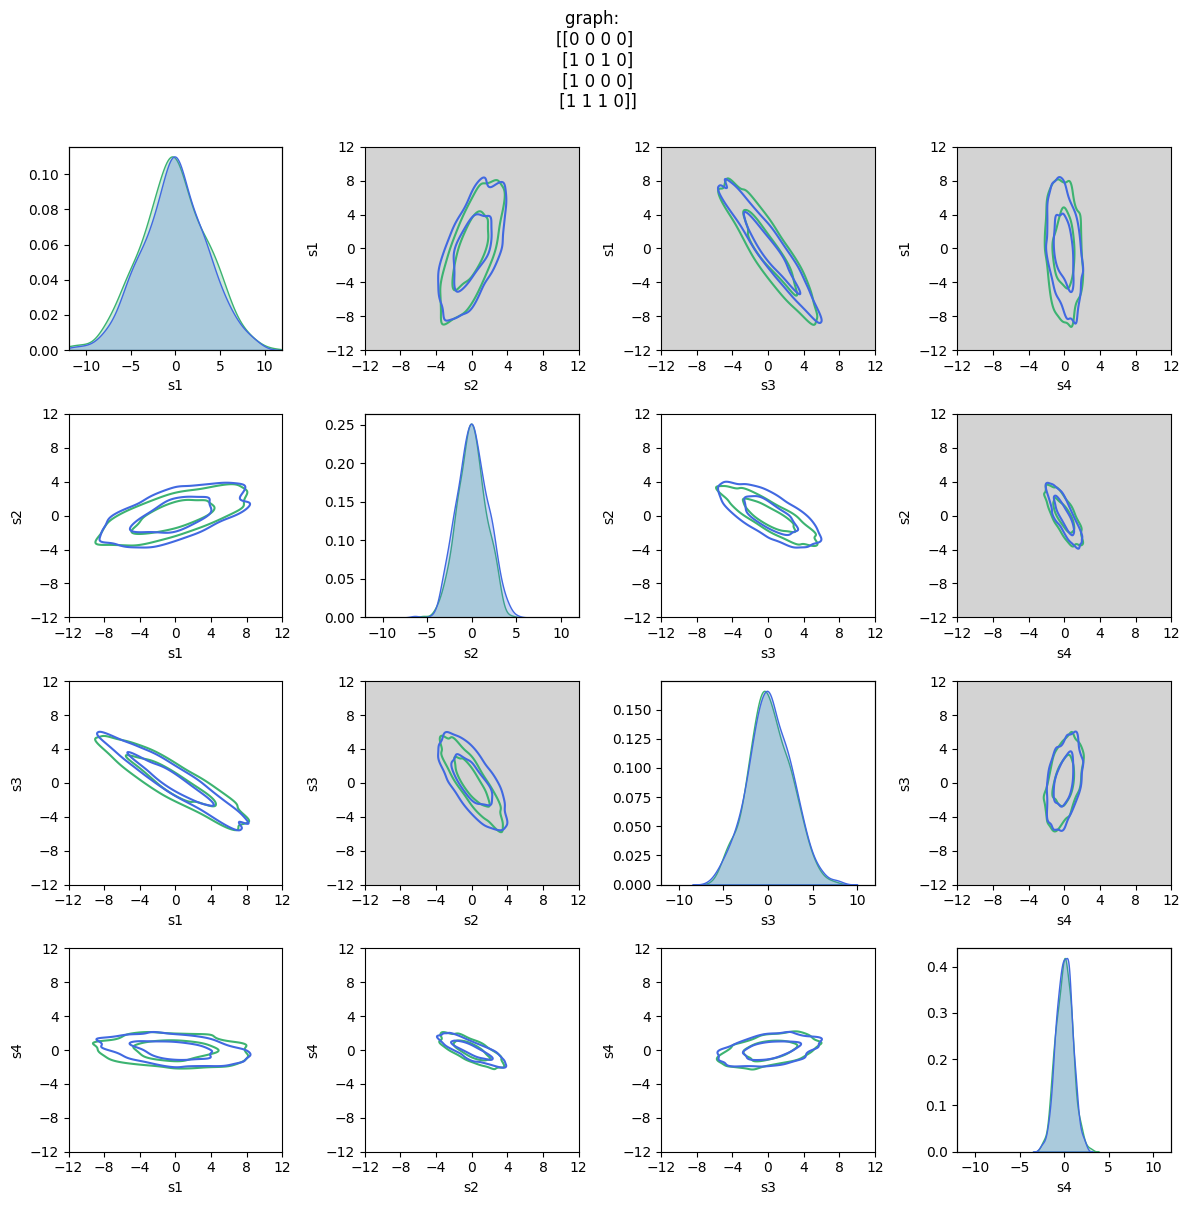

In [114]:
visualize_pairplot_custom(S_true, S_learned, dataset.G, (-12, 12), "mediumseagreen", "royalblue", kde_both=True, levels=[0.1,0.5])

In [115]:
def visualize_pairplot_custom4(dataset_1, dataset_2, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    # levels = [0.01, 0.05, 0.25, 0.5, 0.75]
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)
    
    size_medium = 10
    plt.rc('axes', titlesize=size_medium)
    plt.rc('axes', labelsize=size_medium)
    plt.rc('xtick', labelsize=size_medium)
    plt.rc('ytick', labelsize=size_medium)
    plt.rc('legend', fontsize=size_medium)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            # Extract the data for x and y from the DataFrames
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            # Extract the data for x and y from the DataFrames
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]
    

            # If it's a diagonal, plot a KDE
            if i == j:
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
                
                # To overlay the second KDE, we need to create a twin axis:
                ax2 = ax.twinx()
                sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
                
                # Ensure the twin axis doesn't show ticks and remove the label "Density"
                ax2.set_yticks([])
                ax.set_ylabel('')
                ax2.set_ylabel('')
                
                ax2.set_xlim(axis_lim)

            # Off-diagonal scatter plots
            else:
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                    # ax.scatter(x_data_true, y_data_true, color=color_1, s=5, alpha=0.5)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=5, alpha=0.5)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # Set axis limits and ticks
                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                
                # Use automatic ticks for the off-diagonal plots
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # # Label the x-axes with variable names
            # if i == n_vars - 1:
            #     ax.set_xlabel(f"s{j+1}")
            # # Label the y-axes with variable names only for the first column
            # if j == 0 and i != j:
            #     ax.set_ylabel(f"s{i+1}")
            
            
            # Set axis labels only for the leftmost and bottom subplots
            if i == n_vars - 1:  # Bottom row
                ax.set_xlabel(f"x{j+1}")
            else:
                ax.set_xlabel('')  # Remove x-axis label
                ax.set_xticks([])  # Remove x-axis ticks

            if j == 0:  # Leftmost column
                ax.set_ylabel(f"x{i+1}")
            else:
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Remove y-axis ticks

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
        
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    # plt.tight_layout()
    plt.show()

    # plt.savefig('results/figures/d4_linearGBN_noisy.png', transparent=False, dpi=500)

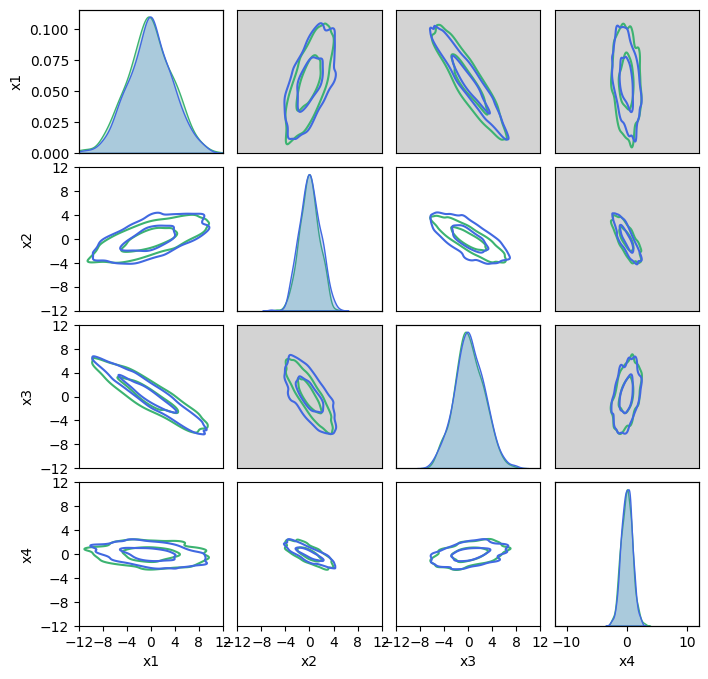

In [117]:
visualize_pairplot_custom4(S_true, S_learned, dataset.G, (-12, 12), "mediumseagreen", "royalblue", kde_both=True, levels=[0.05,0.5], title=False, figsize=(8,8))

## Figure 5.4

In [39]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [40]:
additional_noise_std_distr = Uniform_jax(2,2)

dataset_index=1 #1 #3
S_true, S_learned, D_decoded, dataset, Cov = get_predictions_VAE2(VAE_d4, restored_state, config_file, seed=1, num_obs=500, num_vars=4, batch_size=dataset_index, additional_noise_std_distr=additional_noise_std_distr) # batch size number here actually is an indicator that the last dataset in this batch is used for predictions

sample_index=0
S_true = S_true.squeeze()
S_learned = S_learned[sample_index].squeeze()
D_decoded = D_decoded[sample_index].squeeze()
D_noisy = dataset.get_noisy().squeeze()

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)


In [41]:
def visualize_pairplot_custom4(dataset_1, dataset_2, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    # levels = [0.01, 0.05, 0.25, 0.5, 0.75]
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)
    
    size_medium = 10
    plt.rc('axes', titlesize=size_medium)
    plt.rc('axes', labelsize=size_medium)
    plt.rc('xtick', labelsize=size_medium)
    plt.rc('ytick', labelsize=size_medium)
    plt.rc('legend', fontsize=size_medium)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            # Extract the data for x and y from the DataFrames
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            # Extract the data for x and y from the DataFrames
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]
    

            # If it's a diagonal, plot a KDE
            if i == j:
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
                
                # To overlay the second KDE, we need to create a twin axis:
                ax2 = ax.twinx()
                sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
                
                # Ensure the twin axis doesn't show ticks and remove the label "Density"
                ax2.set_yticks([])
                ax.set_ylabel('')
                ax2.set_ylabel('')
                
                ax2.set_xlim(axis_lim)

            # Off-diagonal scatter plots
            else:
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                    # ax.scatter(x_data_true, y_data_true, color=color_1, s=5, alpha=0.5)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=5, alpha=0.5)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # Set axis limits and ticks
                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                
                # Use automatic ticks for the off-diagonal plots
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # # Label the x-axes with variable names
            # if i == n_vars - 1:
            #     ax.set_xlabel(f"s{j+1}")
            # # Label the y-axes with variable names only for the first column
            # if j == 0 and i != j:
            #     ax.set_ylabel(f"s{i+1}")
            
            
            # Set axis labels only for the leftmost and bottom subplots
            if i == n_vars - 1:  # Bottom row
                ax.set_xlabel(f"x{j+1}")
            else:
                ax.set_xlabel('')  # Remove x-axis label
                ax.set_xticks([])  # Remove x-axis ticks

            if j == 0:  # Leftmost column
                ax.set_ylabel(f"x{i+1}")
            else:
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Remove y-axis ticks

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
        
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    # plt.tight_layout()
    plt.show()

    # plt.savefig('results/figures/d4_linearGBN_noisy.png', transparent=False, dpi=500)

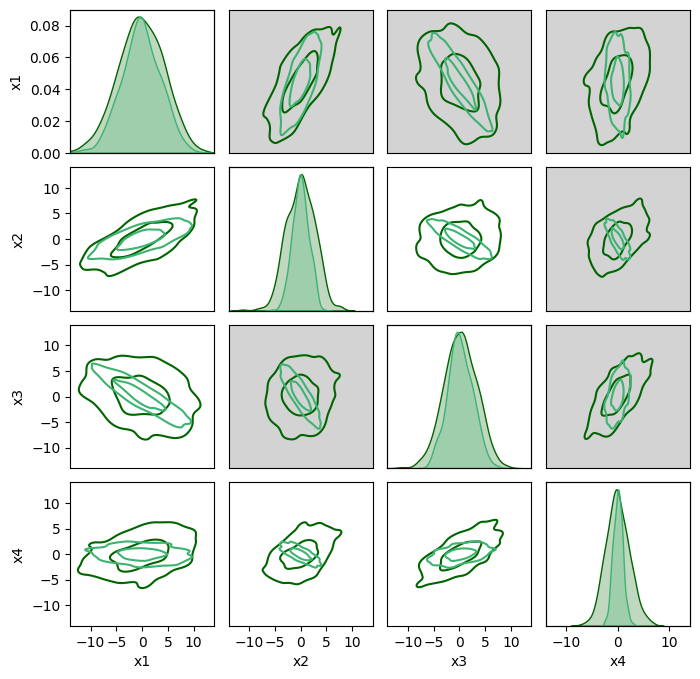

In [42]:
visualize_pairplot_custom4(D_noisy, S_true, dataset.G, (-14, 14), "darkgreen", "mediumseagreen", kde_both=True, levels=[0.05,0.5], title=False, figsize=(8,8))

In [46]:
seed = 0

num_samples = 500
weights_distr = SignedUniform(0.5, 2)
biases_distr = Uniform(0,0)
graph_distr = ErdosRenyi(edges_per_var=2)
num_variables = 4

S_samples = empirical_latent_prior(seed, num_samples, weights_distr=weights_distr, biases_distr=biases_distr, graph_distr=graph_distr, num_variables=num_variables, num_observations=500, num_observations_int=0)
S_samples = rearrange(S_samples, 's N d -> (s N) d')
S_samples_df = pd.DataFrame(S_samples, columns=[f's{i+1}' for i in range(S_samples.shape[-1])])


mechanism_params:
{'biases_distr': <Uniform at 0x2d6c26350: low=0 high=0>,
 'noise_distr': <Gaussian at 0x2d67fd350: mean=0.0 scale=1.0>,
 'noise_scale_distr': <Uniform at 0x2d753afd0: low=1 high=1>,
 'weights_distr': <SignedUniform at 0x2d71c29d0: low=0.5 high=2>}

technical_noise_params:
{'additional_noise_distr': <Gaussian_jax at 0x2d6d8e290: mean=0.0 scale=1.0>,
 'additional_noise_std_distr': <Uniform_jax at 0x2d7538b10: low=0.5 high=2>}

graph_distr:
<ErdosRenyi at 0x2d6e1b390: edges_per_var=2>

dataset_params:
{'num_observations': 500,
 'num_observations_int': 0,
 'num_variables': 4,
 'rng_np': Generator(PCG64) at 0x2D75ADE00}


In [44]:
def visualize_pairplot_custom5(dataset_1, dataset_2, prior_samples, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    # levels = [0.01, 0.05, 0.25, 0.5, 0.75]
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            # Extract the data for x and y from the DataFrames
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            # Extract the data for x and y from the DataFrames
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]
            
            x_prior = prior_samples.iloc[:, j]
            y_prior = prior_samples.iloc[:, i]

            # If it's a diagonal, plot a KDE
            if i == j:
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
                
                # To overlay the second KDE, we need to create a twin axis:
                ax2 = ax.twinx()
                sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
                
                # Ensure the twin axis doesn't show ticks and remove the label "Density"
                ax2.set_yticks([])
                ax.set_ylabel('')
                ax2.set_ylabel('')
                
                ax2.set_xlim(axis_lim)

            # Off-diagonal scatter plots
            else:
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                    sns.kdeplot(data=prior_samples, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color='grey', levels=[0.05,0.25])
                    # ax.scatter(x_data_true, y_data_true, color=color_1, s=5, alpha=0.5)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=5, alpha=0.5)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # Set axis limits and ticks
                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                
                # Use automatic ticks for the off-diagonal plots
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # # Label the x-axes with variable names
            # if i == n_vars - 1:
            #     ax.set_xlabel(f"s{j+1}")
            # # Label the y-axes with variable names only for the first column
            # if j == 0 and i != j:
            #     ax.set_ylabel(f"s{i+1}")
            
            
            # Set axis labels only for the leftmost and bottom subplots
            if i == n_vars - 1:  # Bottom row
                ax.set_xlabel(f"s{j+1}")
            else:
                ax.set_xlabel('')  # Remove x-axis label
                ax.set_xticks([])  # Remove x-axis ticks

            if j == 0:  # Leftmost column
                ax.set_ylabel(f"s{i+1}")
            else:
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Remove y-axis ticks

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    # plt.tight_layout()
    plt.show()

    # plt.savefig('results/figures/d4_linearGBN_learned.png', transparent=False, dpi=500)


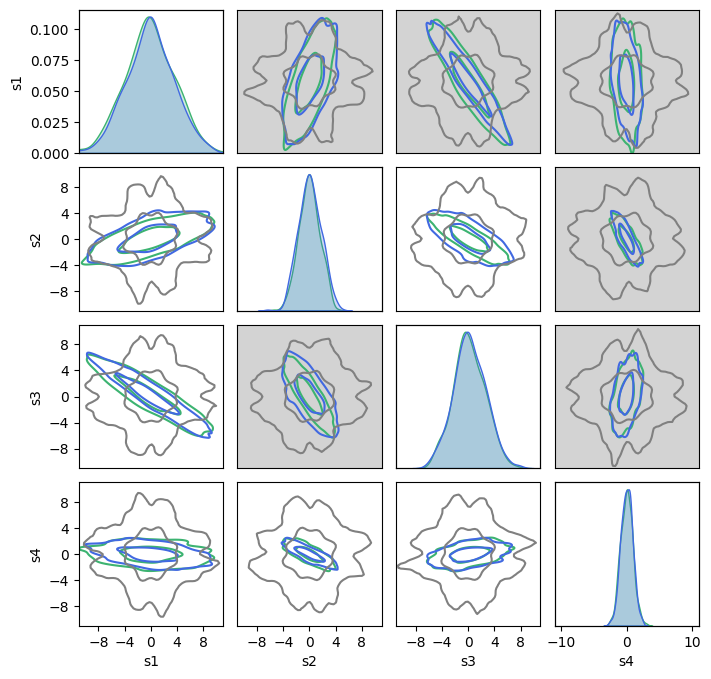

In [47]:
# NOTE: expected run time 1m 30.8s (num_samples=100) or 6m 48.3s (num_samples=500)
visualize_pairplot_custom5(S_true, S_learned, S_samples_df, dataset.G, (-11, 11), "mediumseagreen", "royalblue", kde_both=True, levels=[0.05,0.5], title=False, figsize=(8,8))

# RESULTS d=4 Prior Ablation

## [d=4] NEW experiment 2 - predicts cov (new VAE2) TEST - with new priorCORRECT, sigma=0.1

In [199]:
# kind-sun-1268 - tag: VAEjax2_meta10_b10_s11_sdec1_MC1000_N500_d4_bias0_lamb09_wd1e2_lr1e2_enc4_cov_morenoise_sunif_priorTEST4 - now for kl we sum over N and only average over batch dimension b

tag = 'VAEjax2_meta10_b10_s11_sdec1_MC1000_N500_d4_bias0_lamb09_wd1e2_lr1e2_enc4_cov_morenoise_sunif_priorTEST4'
epoch = 2000

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
restored_state = orbax_checkpointer.restore(f'results/trained_models/{tag}/{epoch}/default/')
config_file = f'results/trained_models/config_run_vae_train_{tag}.yaml'

VAE_d4_NEW_correct = load_model(config_file, model='VAE2')

## other plots

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[2.0411894 1.8370705 1.8370705 1.8370705]
 [1.8370705 2.0411894 1.8370705 1.8370705]
 [1.8370705 1.8370705 2.0411894 1.8370705]
 [1.8370705 1.8370705 1.8370705 2.0411894]] - true covariance matrix for additional noise

[[[26.54791   13.727819  14.230528  12.017431 ]
  [13.727819   8.309413   6.6594496  6.9956083]
  [14.230528   6.6594496 19.535435   8.096753 ]
  [12.017431   6.9956083  8.096753   6.5096836]]]

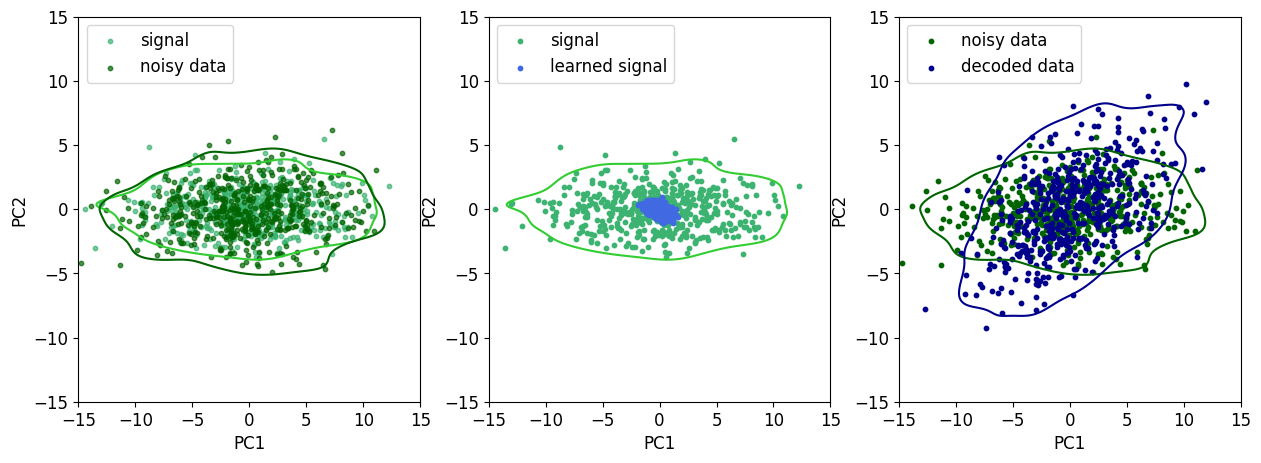

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.3773644 3.0396278 3.0396278 3.0396278]
 [3.0396278 3.3773644 3.0396278 3.0396278]
 [3.0396278 3.0396278 3.3773644 3.0396278]
 [3.0396278 3.0396278 3.0396278 3.3773644]] - true covariance matrix for additional noise

[[[ 6.8655353  7.7356887  8.314988   9.00124  ]
  [ 7.7356887  9.504196   9.989105  10.58625  ]
  [ 8.314988   9.989105  10.783941  11.468563 ]
  [ 9.00124   10.58625   11.468563  12.824218 ]]]

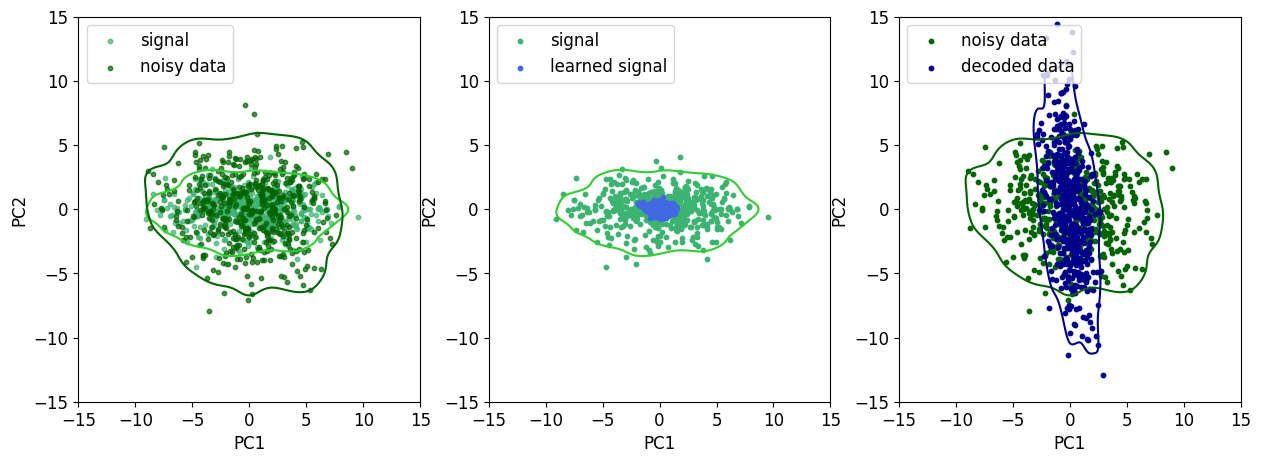

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.2202208 2.8981986 2.8981986 2.8981986]
 [2.8981986 3.2202208 2.8981986 2.8981986]
 [2.8981986 2.8981986 3.2202208 2.8981986]
 [2.8981986 2.8981986 2.8981986 3.2202208]] - true covariance matrix for additional noise

[[[15.854564   7.0466223 18.242462  15.404189 ]
  [ 7.0466223  6.6487093  6.719159  10.961851 ]
  [18.242462   6.719159  22.376394  15.941832 ]
  [15.404189  10.961851  15.941832  21.938156 ]]]

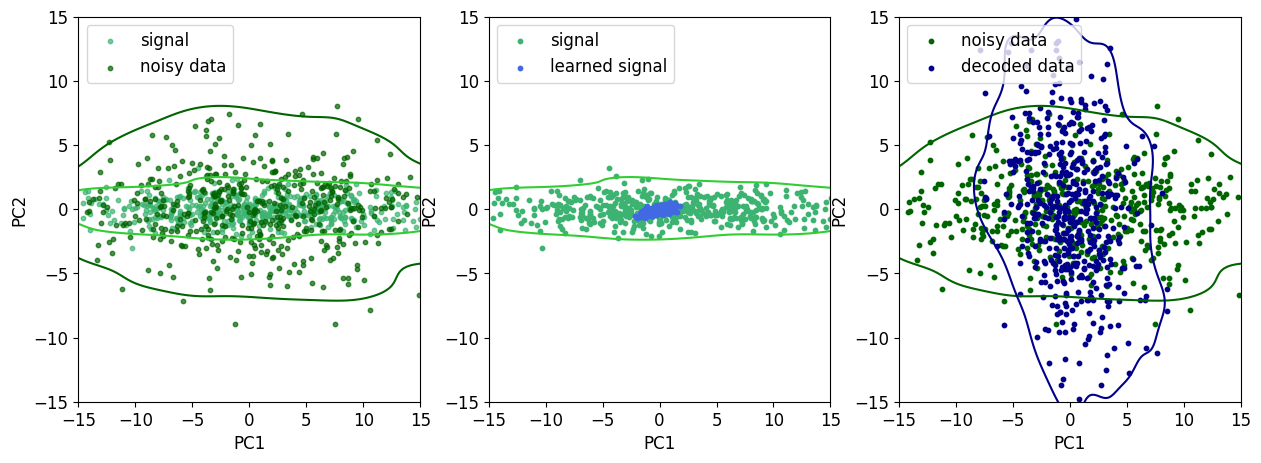

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.0231438 2.7208292 2.7208292 2.7208292]
 [2.7208292 3.0231438 2.7208292 2.7208292]
 [2.7208292 2.7208292 3.0231438 2.7208292]
 [2.7208292 2.7208292 2.7208292 3.0231438]] - true covariance matrix for additional noise

[[[19.119854   9.837304   9.156754  17.673717 ]
  [ 9.837304   7.0964108  6.9219937  9.476284 ]
  [ 9.156754   6.9219937  6.891617   8.882523 ]
  [17.673717   9.476284   8.882523  16.463308 ]]]

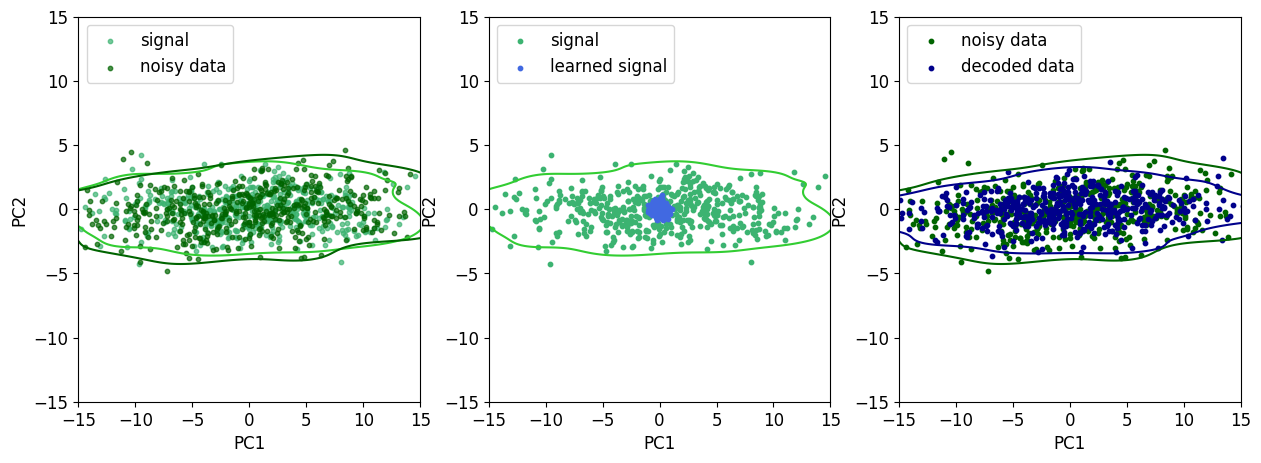

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[1.4087911 1.2679119 1.2679119 1.2679119]
 [1.2679119 1.4087911 1.2679119 1.2679119]
 [1.2679119 1.2679119 1.4087911 1.2679119]
 [1.2679119 1.2679119 1.2679119 1.4087911]] - true covariance matrix for additional noise

[[[17.321669  10.183397  10.960709  12.083721 ]
  [10.183397   7.2437463 11.987452   7.972065 ]
  [10.960709  11.987452  53.526024  10.175495 ]
  [12.083721   7.972065  10.175495   9.187827 ]]]

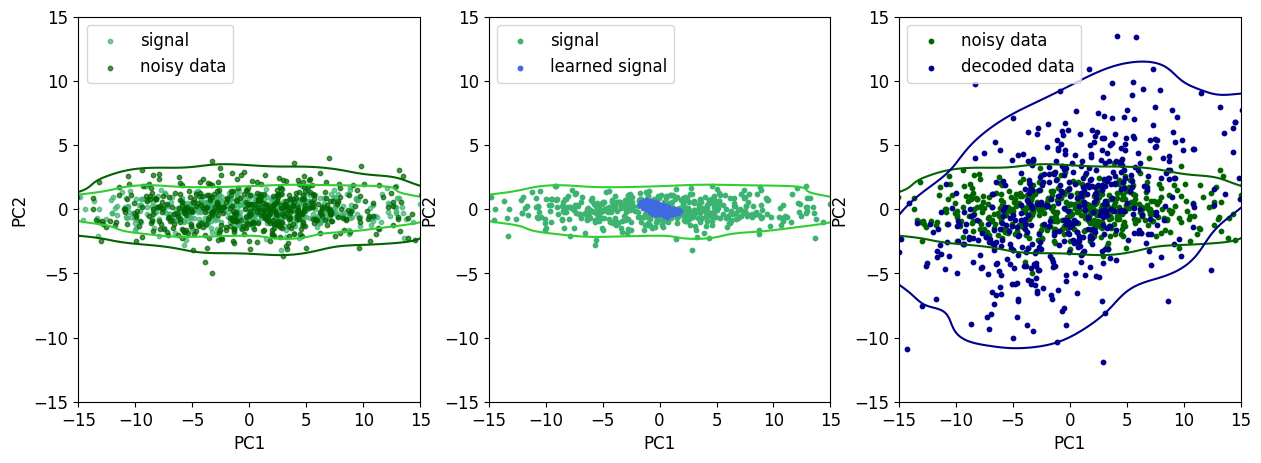

In [188]:
for i in range(5):
    
    dataset_index=i+1
    S_true, S_learned, D_decoded, dataset, Cov = get_predictions_VAE2(VAE_d4_NEW_correct, restored_state, config_file, seed=1, num_obs=500, num_vars=4, batch_size=dataset_index) # batch size number here actually is an indicator that the last dataset in this batch is used for predictions

    sample_index=0
    S_true = S_true.squeeze()
    S_learned = S_learned[sample_index].squeeze()
    D_decoded = D_decoded[sample_index].squeeze()

    plot_pca(S_true, S_learned, D_decoded, dataset, Cov, axis_lim=(-15,15))

## Figure 5.9

In [192]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [189]:
additional_noise_std_distr = Uniform_jax(2,2)

dataset_index=1 #1 #3
S_true, S_learned, D_decoded, dataset, Cov = get_predictions_VAE2(VAE_d4_NEW_correct, restored_state, config_file, seed=1, num_obs=500, num_vars=4, batch_size=dataset_index, additional_noise_std_distr=additional_noise_std_distr) # batch size number here actually is an indicator that the last dataset in this batch is used for predictions

sample_index=0
S_true = S_true.squeeze()
S_learned = S_learned[sample_index].squeeze()
D_decoded = D_decoded[sample_index].squeeze()
D_noisy = dataset.get_noisy().squeeze()

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)


In [193]:
def visualize_pairplot_custom6(dataset_1, dataset_2, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    # levels = [0.01, 0.05, 0.25, 0.5, 0.75]
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            # Extract the data for x and y from the DataFrames
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            # Extract the data for x and y from the DataFrames
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]
            
            # x_prior = prior_samples.iloc[:, j]
            # y_prior = prior_samples.iloc[:, i]

            # If it's a diagonal, plot a KDE
            if i == j:
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
                
                # To overlay the second KDE, we need to create a twin axis:
                ax2 = ax.twinx()
                sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
                
                # Ensure the twin axis doesn't show ticks and remove the label "Density"
                ax2.set_yticks([])
                ax.set_ylabel('')
                ax2.set_ylabel('')
                
                ax2.set_xlim(axis_lim)

            # Off-diagonal scatter plots
            else:
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                    # ax.scatter(x_data_true, y_data_true, color=color_1, s=5, alpha=0.5)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=5, alpha=0.5)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # Set axis limits and ticks
                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                
                # Use automatic ticks for the off-diagonal plots
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # # Label the x-axes with variable names
            # if i == n_vars - 1:
            #     ax.set_xlabel(f"s{j+1}")
            # # Label the y-axes with variable names only for the first column
            # if j == 0 and i != j:
            #     ax.set_ylabel(f"s{i+1}")
            
            
            # Set axis labels only for the leftmost and bottom subplots
            if i == n_vars - 1:  # Bottom row
                ax.set_xlabel(f"s{j+1}")
            else:
                ax.set_xlabel('')  # Remove x-axis label
                ax.set_xticks([])  # Remove x-axis ticks

            if j == 0:  # Leftmost column
                ax.set_ylabel(f"s{i+1}")
            else:
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Remove y-axis ticks

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    # plt.tight_layout()
    plt.show()

    # plt.savefig('results/figures/d4_linearGBN_learned_prior1.png', transparent=False, dpi=500)


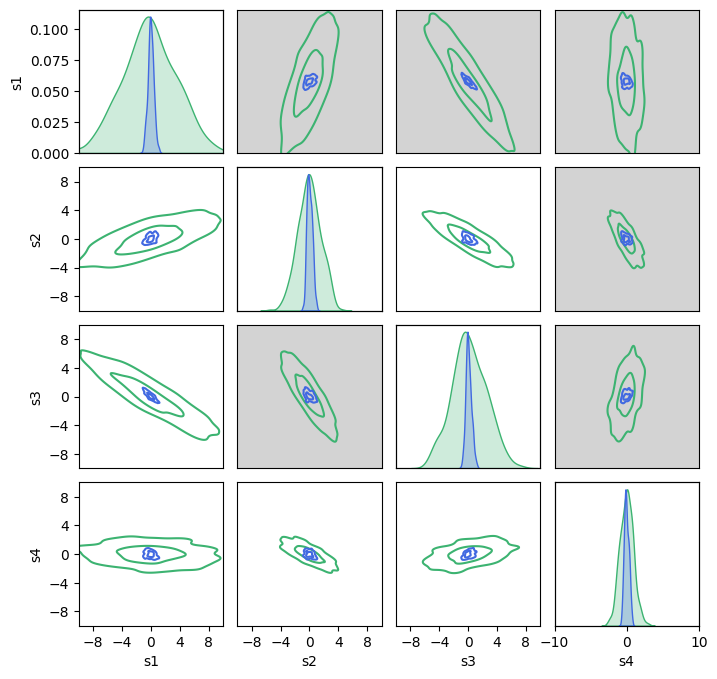

In [194]:
visualize_pairplot_custom6(S_true, S_learned, dataset.G, (-10, 10), "mediumseagreen", "royalblue", kde_both=True, levels=[0.05,0.5], title=False, figsize=(8,8))

In [209]:
def visualize_pairplot_custom6_NEW(dataset_1, dataset_2, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]

            # if i == j:  # Diagonal plots
            #     sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
            #     ax2 = ax.twinx()
            #     # sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
            #     ax2.set_yticks([])
            #     ax.set_ylabel('')
            #     ax2.set_ylabel('')
            #     ax2.set_xlim(axis_lim)

            #     # Standard Gaussian Contour for Diagonal
            #     x_vals = np.linspace(*axis_lim, 400)
            #     ax.plot(x_vals, norm.pdf(x_vals), 'k--', lw=2)  # plot standard Gaussian contour

            if i == j:  # Diagonal plots
                # Plotting the KDE for the data
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)

                # Plotting the standard Gaussian
                x_vals = np.linspace(*axis_lim, 400)
                y_vals = norm.pdf(x_vals)
                # y_vals_scaled = y_vals * len(x_data_true) * np.ptp(x_data_true) / (4 * np.sum(y_vals))  # scaling to match the KDE plot
                ax.plot(x_vals, y_vals, c='dimgrey', ls='--', lw=2)  # plot standard Gaussian contour

                ax.set_xlim(axis_lim)
            
            else:  # Off-diagonal plots
                # [Your existing code for scatter or KDE plot]
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, ax=ax, color=color_1, levels=levels)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    # sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, ax=ax, color=color_1, levels=levels)
                    # sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                    # ax.scatter(x_data_true, y_data_true, color=color_1, s=5, alpha=0.5)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=5, alpha=0.5)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # # Set axis limits and ticks
                # ax.set_xlim(axis_lim)
                # ax.set_ylim(axis_lim)
                
                # # Use automatic ticks for the off-diagonal plots
                # ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                # ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                # if (graph).T[i, j] == 1:
                #     ax.set_facecolor('lightgray')




                # # Standard Gaussian Contour for Off-Diagonal
                # x = np.linspace(*axis_lim, 100)
                # y = np.linspace(*axis_lim, 100)
                # X, Y = np.meshgrid(x, y)
                # pos = np.dstack((X, Y))
                # rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
                # level1 = np.exp(norm.logpdf(norm.ppf(levels[0]/2), 0,1))
                # level2 = np.exp(norm.logpdf(norm.ppf(levels[1]/2), 0,1))
                # print(level1)
                # print(level2)
                # ax.contour(X, Y, rv.pdf(pos), levels=[level1], colors='grey', linestyles='--')
                
                
                
                
                
                circle_center = (0, 0)  # Center of the circle (you can adjust this as needed)
                circle_radius = norm.ppf(0.975)     
                # print(circle_radius)  
                ax.add_patch(mpatches.Circle(circle_center, circle_radius, color='dimgrey', fill=False, linestyle=(0, (5, 1)), lw=2))
                
                circle_center = (0, 0)  # Center of the circle (you can adjust this as needed)
                circle_radius2 = norm.ppf(0.75)       
                # print(circle_radius2) 
                ax.add_patch(mpatches.Circle(circle_center, circle_radius2, color='dimgrey', fill=False, linestyle=(0, (5, 1)), lw=2))

                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # Set axis labels for leftmost and bottom subplots
            if i == n_vars - 1:
                ax.set_xlabel(f"s{j+1}")
            else:
                ax.set_xlabel('')
                ax.set_xticks([])

            if j == 0:
                ax.set_ylabel(f"s{i+1}")
            else:
                ax.set_ylabel('')
                ax.set_yticks([])

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

    # plt.savefig('results/figures/d4_linearGBN_learned_prior1_latent.png', transparent=False, dpi=500)

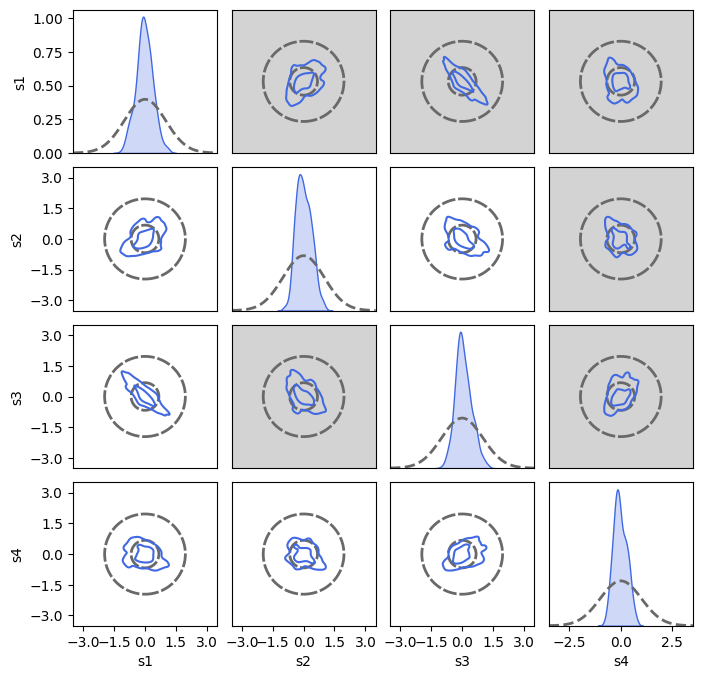

In [198]:
visualize_pairplot_custom6_NEW(S_learned, S_learned, dataset.G, (-3.5, 3.5), "royalblue", "royalblue", kde_both=True, levels=[0.05,0.5], title=False, figsize=(8,8))

## [d=4] NEW experiment 2 - predicts cov (new VAE2) TEST - with new priorCORRECT sigma pred

In [203]:
# cosmic-disco-1269 - tag: VAEjax2_meta10_b10_s11_sdec1_MC1000_N500_d4_bias0_lamb09_wd1e2_lr1e2_enc4_cov_morenoise_sunif_priorTEST5_predsigma

tag = 'VAEjax2_meta10_b10_s11_sdec1_MC1000_N500_d4_bias0_lamb09_wd1e2_lr1e2_enc4_cov_morenoise_sunif_priorTEST5_predsigma'
epoch = 2000

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
restored_state = orbax_checkpointer.restore(f'results/trained_models/{tag}/{epoch}/default/')
config_file = f'results/trained_models/config_run_vae_train_{tag}.yaml'

VAE_d4_NEW_correct_sigmapred = load_model(config_file, model='VAE2_1')

## other plots

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[2.0411894 1.8370705 1.8370705 1.8370705]
 [1.8370705 2.0411894 1.8370705 1.8370705]
 [1.8370705 1.8370705 2.0411894 1.8370705]
 [1.8370705 1.8370705 1.8370705 2.0411894]] - true covariance matrix for additional noise

[[[133.28229 136.66693 135.18811 137.92027]
  [136.66693 149.83868 143.8176  152.66809]
  [135.18811 143.8176  140.31058 146.25568]
  [137.92027 152.66809 146.25568 156.08636]]] - predicted cov

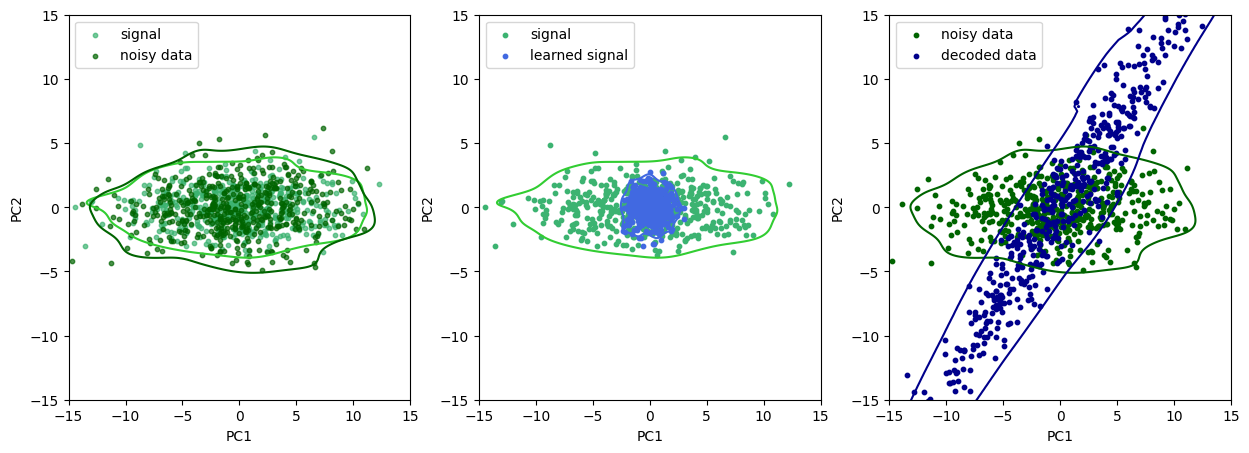

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.3773644 3.0396278 3.0396278 3.0396278]
 [3.0396278 3.3773644 3.0396278 3.0396278]
 [3.0396278 3.0396278 3.3773644 3.0396278]
 [3.0396278 3.0396278 3.0396278 3.3773644]] - true covariance matrix for additional noise

[[[151.67111 149.1391  149.36761 144.81734]
  [149.1391  146.89584 147.12595 143.03616]
  [149.36761 147.12595 147.59634 143.54272]
  [144.81734 143.03616 143.54272 140.24962]]] - predicted cov

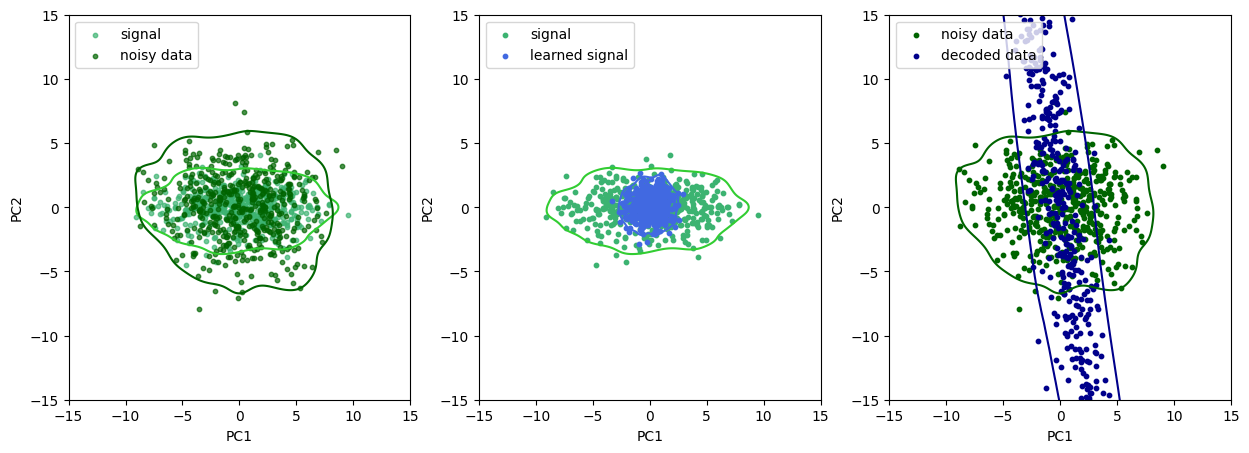

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.2202208 2.8981986 2.8981986 2.8981986]
 [2.8981986 3.2202208 2.8981986 2.8981986]
 [2.8981986 2.8981986 3.2202208 2.8981986]
 [2.8981986 2.8981986 2.8981986 3.2202208]] - true covariance matrix for additional noise

[[[140.28783 141.86215 135.43448 108.92253]
  [141.86215 143.74374 136.56142 107.9481 ]
  [135.43448 136.56142 134.39764 115.69748]
  [108.92253 107.9481  115.69748 130.50818]]] - predicted cov

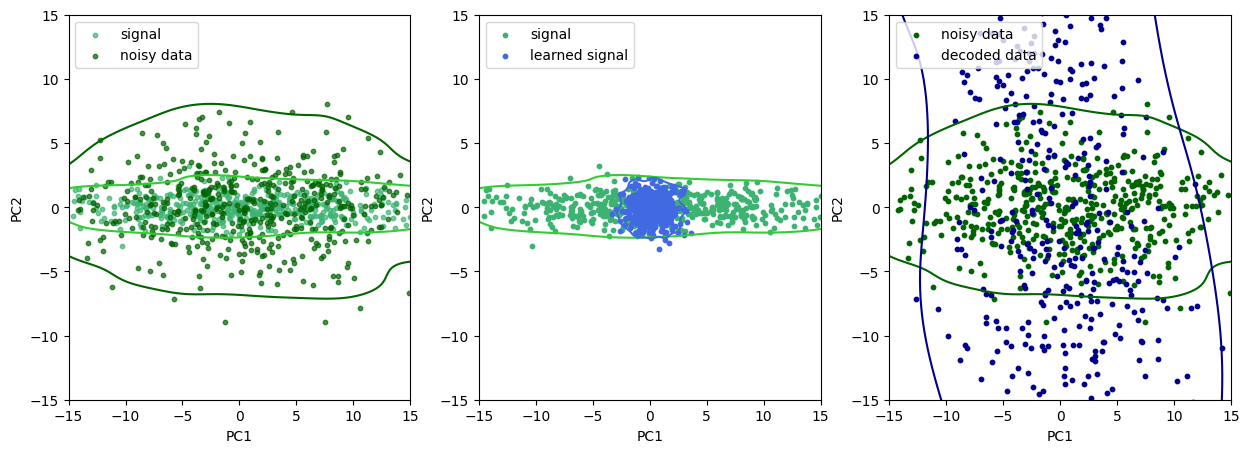

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[3.0231438 2.7208292 2.7208292 2.7208292]
 [2.7208292 3.0231438 2.7208292 2.7208292]
 [2.7208292 2.7208292 3.0231438 2.7208292]
 [2.7208292 2.7208292 2.7208292 3.0231438]] - true covariance matrix for additional noise

[[[133.3154  135.79721 136.15901 133.51549]
  [135.79721 148.42581 151.03683 137.11668]
  [136.15901 151.03683 154.28082 137.6511 ]
  [133.51549 137.11668 137.6511  133.89183]]] - predicted cov

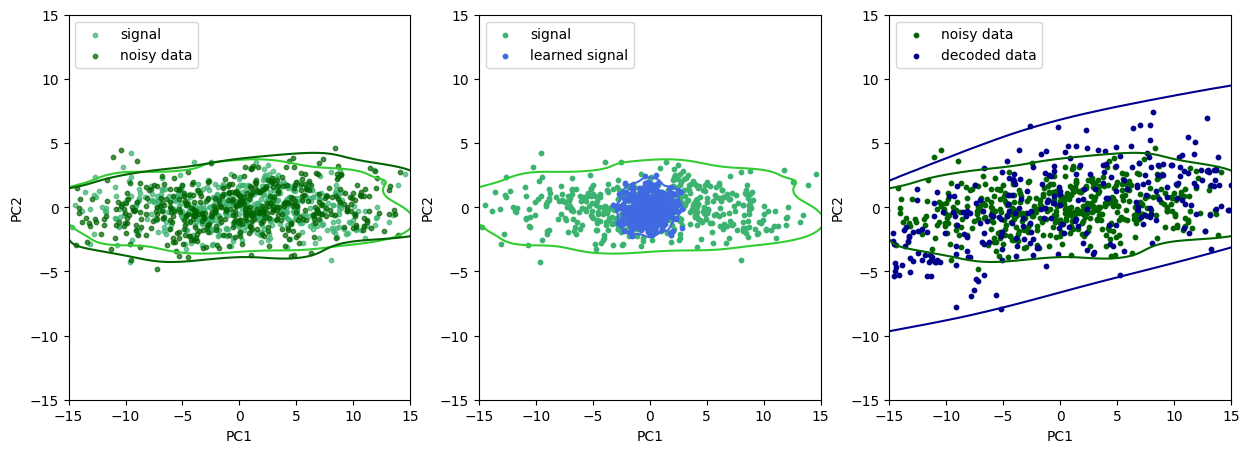

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)
[[1.4087911 1.2679119 1.2679119 1.2679119]
 [1.2679119 1.4087911 1.2679119 1.2679119]
 [1.2679119 1.2679119 1.4087911 1.2679119]
 [1.2679119 1.2679119 1.2679119 1.4087911]] - true covariance matrix for additional noise

[[[145.03134  150.9061    97.565506 149.33723 ]
  [150.9061   158.86069   94.90857  156.7606  ]
  [ 97.565506  94.90857  112.12341   95.505394]
  [149.33723  156.7606    95.505394 154.80255 ]]]

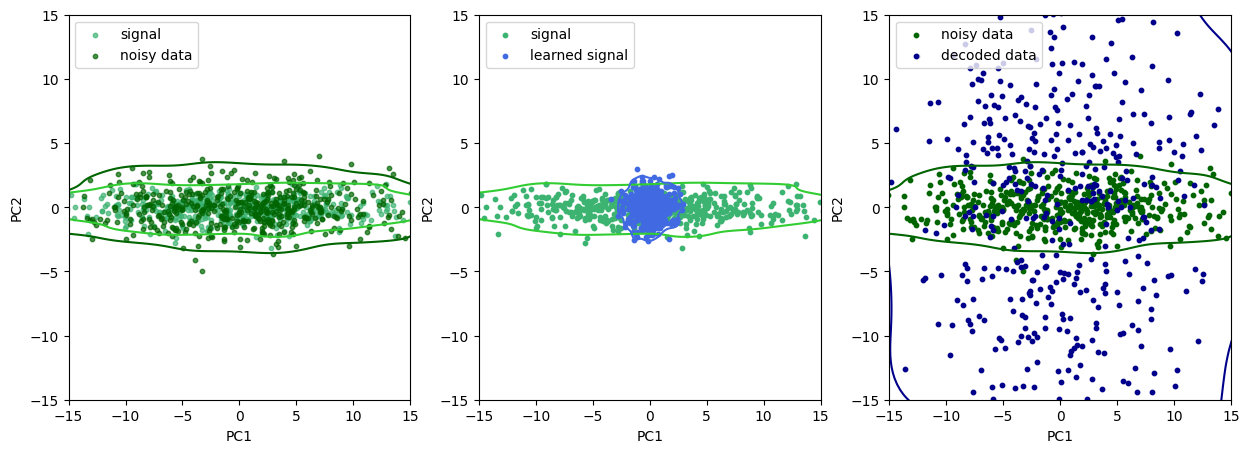

In [204]:
for i in range(5):
    
    dataset_index=i+1
    S_true, S_learned, D_decoded, dataset, Cov = get_predictions_VAE2(VAE_d4_NEW_correct_sigmapred, restored_state, config_file, seed=1, num_obs=500, num_vars=4, batch_size=dataset_index) # batch size number here actually is an indicator that the last dataset in this batch is used for predictions

    sample_index=0
    S_true = S_true.squeeze()
    S_learned = S_learned[sample_index].squeeze()
    D_decoded = D_decoded[sample_index].squeeze()

    plot_pca(S_true, S_learned, D_decoded, dataset, Cov, axis_lim=(-15,15))

## Figure 5.10

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [205]:
additional_noise_std_distr = Uniform_jax(2,2)

dataset_index=1 #1 #3
S_true, S_learned, D_decoded, dataset, Cov = get_predictions_VAE2(VAE_d4_NEW_correct_sigmapred, restored_state, config_file, seed=1, num_obs=500, num_vars=4, batch_size=dataset_index, additional_noise_std_distr=additional_noise_std_distr) # batch size number here actually is an indicator that the last dataset in this batch is used for predictions

sample_index=0
S_true = S_true.squeeze()
S_learned = S_learned[sample_index].squeeze()
D_decoded = D_decoded[sample_index].squeeze()
D_noisy = dataset.get_noisy().squeeze()

---VAE: encoder
x shape into encoder layer: (1, 500, 4) 	 continue: False
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape into encoder sublayer: (1, 500, 4, 128)
x shape into encoder sublayer: (1, 4, 500, 128)
x shape out from encoder layer: (1, 500, 4, 128) - for [b N d k] or [s b N d k]
---VAE: reparameterize
(10, 1, 500, 4)
(1, 4, 4)


In [206]:
def visualize_pairplot_custom6(dataset_1, dataset_2, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    # levels = [0.01, 0.05, 0.25, 0.5, 0.75]
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            # Extract the data for x and y from the DataFrames
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            # Extract the data for x and y from the DataFrames
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]
            
            # x_prior = prior_samples.iloc[:, j]
            # y_prior = prior_samples.iloc[:, i]

            # If it's a diagonal, plot a KDE
            if i == j:
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
                
                # To overlay the second KDE, we need to create a twin axis:
                ax2 = ax.twinx()
                sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
                
                # Ensure the twin axis doesn't show ticks and remove the label "Density"
                ax2.set_yticks([])
                ax.set_ylabel('')
                ax2.set_ylabel('')
                
                ax2.set_xlim(axis_lim)

            # Off-diagonal scatter plots
            else:
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_1, levels=levels)
                    sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                    # ax.scatter(x_data_true, y_data_true, color=color_1, s=5, alpha=0.5)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=5, alpha=0.5)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # Set axis limits and ticks
                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                
                # Use automatic ticks for the off-diagonal plots
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # # Label the x-axes with variable names
            # if i == n_vars - 1:
            #     ax.set_xlabel(f"s{j+1}")
            # # Label the y-axes with variable names only for the first column
            # if j == 0 and i != j:
            #     ax.set_ylabel(f"s{i+1}")
            
            
            # Set axis labels only for the leftmost and bottom subplots
            if i == n_vars - 1:  # Bottom row
                ax.set_xlabel(f"s{j+1}")
            else:
                ax.set_xlabel('')  # Remove x-axis label
                ax.set_xticks([])  # Remove x-axis ticks

            if j == 0:  # Leftmost column
                ax.set_ylabel(f"s{i+1}")
            else:
                ax.set_ylabel('')  # Remove y-axis label
                ax.set_yticks([])  # Remove y-axis ticks

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    # plt.tight_layout()
    plt.show()

    # plt.savefig('results/figures/d4_linearGBN_learned_prior2.png', transparent=False, dpi=500)


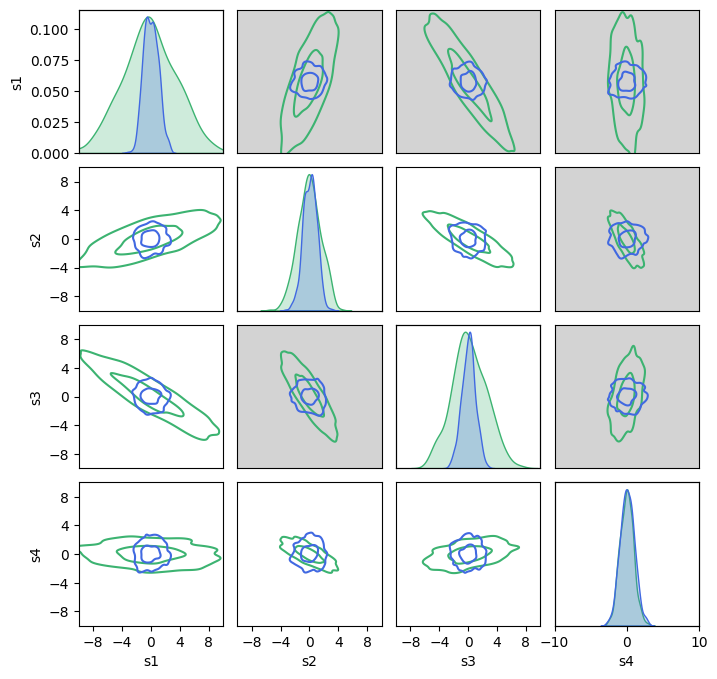

In [207]:
visualize_pairplot_custom6(S_true, S_learned, dataset.G, (-10, 10), "mediumseagreen", "royalblue", kde_both=True, levels=[0.05,0.5], title=False, figsize=(8,8))

In [212]:
def visualize_pairplot_custom6_NEW(dataset_1, dataset_2, graph, axis_lim, color_1='mediumseagreen', color_2='royalblue', kde1=False, kde2=False, kde_both=False, figsize=(12, 12), levels=[0.1,0.5], title=True):
    
    S_true = dataset_1
    S_learned = dataset_2

    S_true_df = pd.DataFrame(S_true, columns=[f's{i+1}' for i in range(S_true.shape[-1])])
    S_learned_df = pd.DataFrame(S_learned, columns=[f's{i+1}' for i in range(S_learned.shape[-1])])
    
    n_vars = S_true_df.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            x_col_name = f's{j+1}'
            y_col_name = f's{i+1}'
            
            x_data_true = S_true_df.iloc[:, j]
            y_data_true = S_true_df.iloc[:, i]
            
            x_data_learned = S_learned_df.iloc[:, j]
            y_data_learned = S_learned_df.iloc[:, i]

            # if i == j:  # Diagonal plots
            #     sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)
            #     ax2 = ax.twinx()
            #     # sns.kdeplot(x=x_data_learned, ax=ax2, color=color_2, fill=True)
            #     ax2.set_yticks([])
            #     ax.set_ylabel('')
            #     ax2.set_ylabel('')
            #     ax2.set_xlim(axis_lim)

            #     # Standard Gaussian Contour for Diagonal
            #     x_vals = np.linspace(*axis_lim, 400)
            #     ax.plot(x_vals, norm.pdf(x_vals), 'k--', lw=2)  # plot standard Gaussian contour

            if i == j:  # Diagonal plots
                # Plotting the KDE for the data
                sns.kdeplot(x=x_data_true, ax=ax, color=color_1, fill=True)

                # Plotting the standard Gaussian
                x_vals = np.linspace(*axis_lim, 400)
                y_vals = norm.pdf(x_vals)
                # y_vals_scaled = y_vals * len(x_data_true) * np.ptp(x_data_true) / (4 * np.sum(y_vals))  # scaling to match the KDE plot
                ax.plot(x_vals, y_vals, c='dimgrey', ls='--', lw=2)  # plot standard Gaussian contour

                ax.set_xlim(axis_lim)
            
            else:  # Off-diagonal plots
                # [Your existing code for scatter or KDE plot]
                if kde1:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, ax=ax, color=color_1, levels=levels)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                elif kde2:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    # sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                elif kde_both:
                    sns.kdeplot(data=S_true_df, x=x_col_name, y=y_col_name, ax=ax, color=color_1, levels=levels)
                    # sns.kdeplot(data=S_learned_df, x=x_col_name, y=y_col_name, thresh=0.05, ax=ax, color=color_2, levels=levels)
                    # ax.scatter(x_data_true, y_data_true, color=color_1, s=5, alpha=0.5)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=5, alpha=0.5)
                else:
                    ax.scatter(x_data_true, y_data_true, color=color_1, s=20)
                    # ax.scatter(x_data_learned, y_data_learned, color=color_2, s=10)
                
                # # Set axis limits and ticks
                # ax.set_xlim(axis_lim)
                # ax.set_ylim(axis_lim)
                
                # # Use automatic ticks for the off-diagonal plots
                # ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                # ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                
                # if (graph).T[i, j] == 1:
                #     ax.set_facecolor('lightgray')




                # # Standard Gaussian Contour for Off-Diagonal
                # x = np.linspace(*axis_lim, 100)
                # y = np.linspace(*axis_lim, 100)
                # X, Y = np.meshgrid(x, y)
                # pos = np.dstack((X, Y))
                # rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
                # level1 = np.exp(norm.logpdf(norm.ppf(levels[0]/2), 0,1))
                # level2 = np.exp(norm.logpdf(norm.ppf(levels[1]/2), 0,1))
                # print(level1)
                # print(level2)
                # ax.contour(X, Y, rv.pdf(pos), levels=[level1], colors='grey', linestyles='--')
                
                
                
                
                
                circle_center = (0, 0)  # Center of the circle (you can adjust this as needed)
                circle_radius = norm.ppf(0.975)     
                # print(circle_radius)  
                ax.add_patch(mpatches.Circle(circle_center, circle_radius, color='dimgrey', fill=False, linestyle=(0, (5, 1)), lw=2))
                
                circle_center = (0, 0)  # Center of the circle (you can adjust this as needed)
                circle_radius2 = norm.ppf(0.75)       
                # print(circle_radius2) 
                ax.add_patch(mpatches.Circle(circle_center, circle_radius2, color='dimgrey', fill=False, linestyle=(0, (5, 1)), lw=2))

                ax.set_xlim(axis_lim)
                ax.set_ylim(axis_lim)
                ax.xaxis.set_major_locator(plt.MaxNLocator(6))
                ax.yaxis.set_major_locator(plt.MaxNLocator(6))
                if (graph).T[i, j] == 1:
                    ax.set_facecolor('lightgray')

            # Set axis labels for leftmost and bottom subplots
            if i == n_vars - 1:
                ax.set_xlabel(f"s{j+1}")
            else:
                ax.set_xlabel('')
                ax.set_xticks([])

            if j == 0:
                ax.set_ylabel(f"s{i+1}")
            else:
                ax.set_ylabel('')
                ax.set_yticks([])

    if title:
        plt.suptitle(f'graph: \n{graph}', y=1.0)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

    # plt.savefig('results/figures/d4_linearGBN_learned_prior2_latent.png', transparent=False, dpi=500)

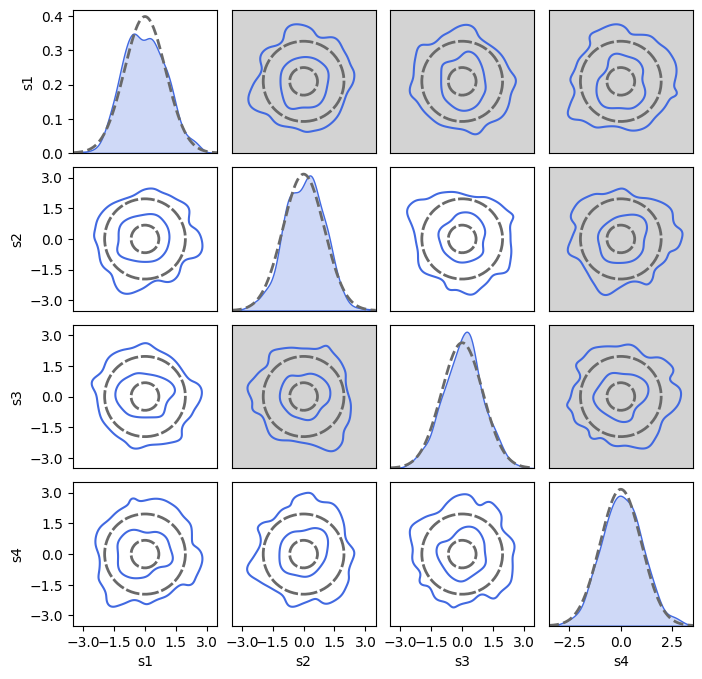

In [213]:
visualize_pairplot_custom6_NEW(S_learned, S_learned, dataset.G, (-3.5, 3.5), "royalblue", "royalblue", kde_both=True, levels=[0.05,0.5], title=False, figsize=(8,8))

# CAUSAL DISCOVERY d=4

## DiBS

In [118]:
directory = 'results/causal_discovery/d4_DiBS/'
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes.append(pd.read_csv(file_path))

In [119]:
for i in range(10):
    print(dataframes[i].columns[1])

d4_alpha_0_2_h_latent_1_h_theta_10 - [true] neg. LL (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUROC (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] precision (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] E-SHD (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] E-SHD (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUPRC (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] recall (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] F1 (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] neg. LL (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUROC (DiBS)


In [120]:
negll_p = dataframes[0]
auroc_p = dataframes[1]
precision = dataframes[2]
eshd_p = dataframes[3]
eshd = dataframes[4]
auprc_p = dataframes[5]
recall = dataframes[6]
f1 = dataframes[7]
negll = dataframes[8]
auroc = dataframes[9]
auprc = dataframes[10]

In [121]:
dict = {
    'E-SHD': eshd,
    'neg. LL': negll,
    'AUROC': auroc,
    'AUPRC': auprc,
    'F1': f1,
    'precision': precision,
    'recall': recall
}

In [122]:
for method, datf in dict.items():
    datf.rename(columns = {f'd4_alpha_0_2_h_latent_1_h_theta_10 - [true] {method} (DiBS)': 'true', 
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [learned] {method} (DiBS)': 'learned',
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [noisy] {method} (DiBS)': 'noisy'}, inplace = True)

In [123]:
dict = {
    'E-SHD': eshd_p,
    'neg. LL': negll_p,
    'AUROC': auroc_p,
    'AUPRC': auprc_p,
}

In [124]:
for method, datf in dict.items():
    datf.rename(columns = {f'd4_alpha_0_2_h_latent_1_h_theta_10 - [true] {method} (DiBS+)': 'true', 
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [learned] {method} (DiBS+)': 'learned',
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [noisy] {method} (DiBS+)': 'noisy'}, inplace = True)

## Figure 5.5

In [125]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

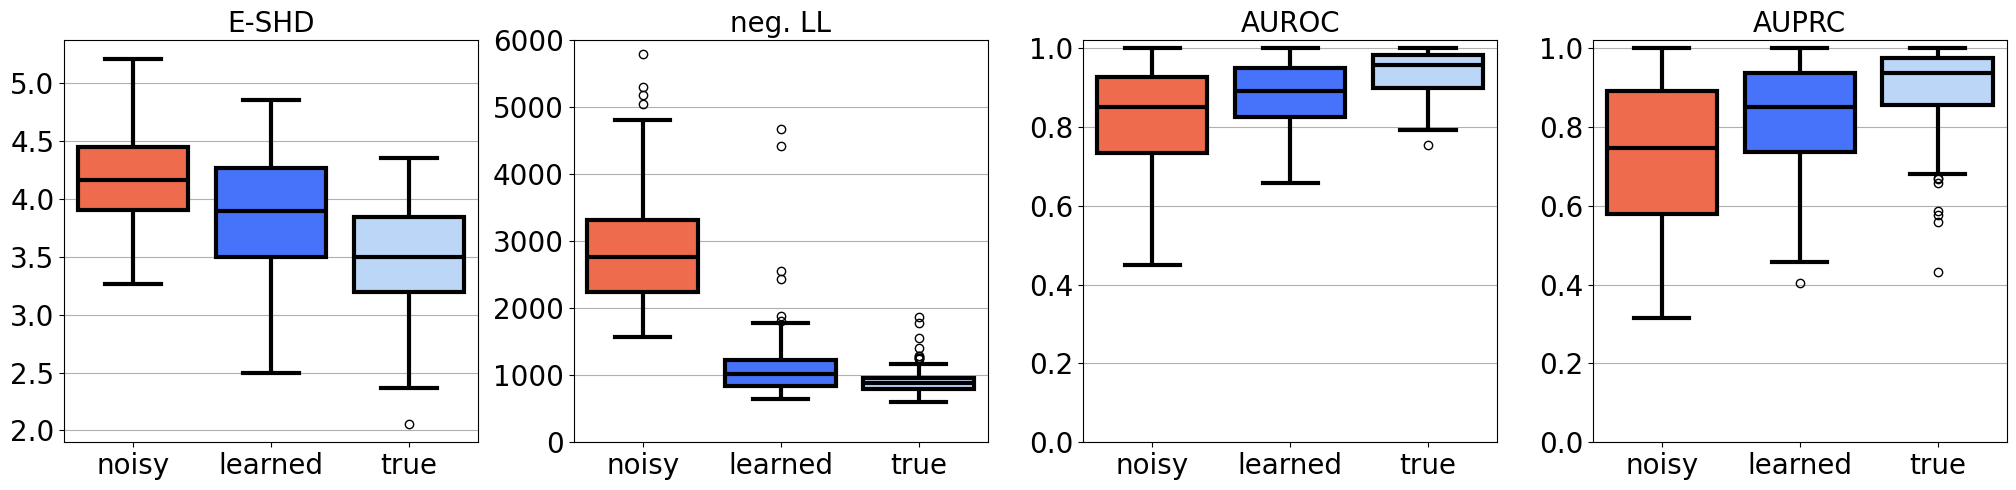

In [127]:
dataframes = [eshd, negll, auroc, auprc]
df_names = ['E-SHD', 'neg. LL', 'AUROC', 'AUPRC']

colors = ["#EE6C4D", "#4773FB", "#BCD6F8"]

fig, axes = plt.subplots(1, len(dataframes), figsize=(len(dataframes)*5, 5))

size_medium = 20
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium) 
plt.rc('ytick', labelsize=size_medium)   
plt.rc('legend', fontsize=size_medium)

for ax, df, name in zip(axes, dataframes, df_names):
    # sns.set_style("whitegrid", {'grid.color': 'grey'})
    # sns.set_style("whitegrid")
    
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    sns.boxplot(data=df[['noisy', 'learned', 'true']], palette=colors, linecolor='black', ax=ax, linewidth=3, saturation=1.0)
    ax.set_title(name)

axes[1].set_ylim(0,6000)
axes[2].set_ylim(0,1.02)
axes[3].set_ylim(0,1.02)

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d4_dibs_class_good.png', transparent=False, dpi=500)


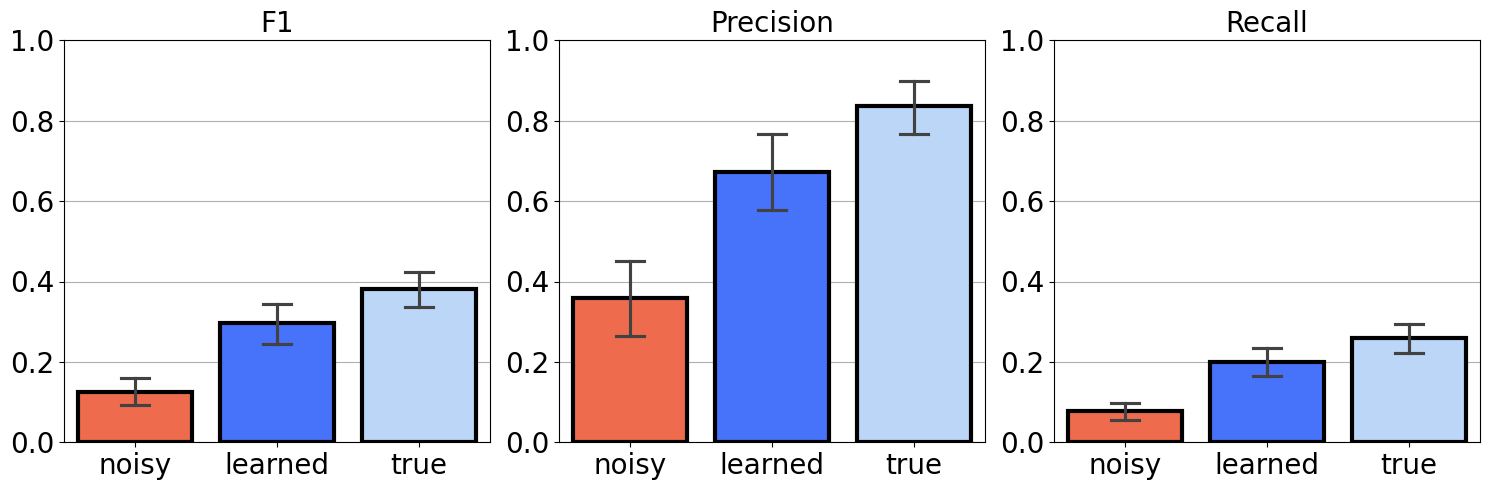

In [130]:
dataframes = [f1, precision, recall]
df_names = ['F1', 'Precision', 'Recall']

colors = ["#EE6C4D", "#4773FB", "#BCD6F8"]

fig, axes = plt.subplots(1, len(dataframes), figsize=(len(dataframes)*5, 5))

size_medium = 20
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)   
plt.rc('ytick', labelsize=size_medium)   
plt.rc('legend', fontsize=size_medium)

for ax, df, name in zip(axes, dataframes, df_names):
    # sns.set_style("whitegrid", {'grid.color': 'grey'})
    # sns.set_style("whitegrid")
    
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    sns.barplot(data=df[['noisy', 'learned', 'true']], palette=colors, ax=ax, capsize=.2, edgecolor='black', linewidth=3, saturation=1.0)
    ax.set_title(name)
    
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d4_dibs_pred_good.png', transparent=False, dpi=500)

## GES & PC (Gaussian CI)

In [131]:
directory = 'results/causal_discovery/d4_GES/'
dataframes_ges = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes_ges.append(pd.read_csv(file_path))

In [132]:
for i in range(4):
    print(dataframes_ges[i].columns[1])

linear_SCM_learned_d4_900_GES_PC - [true] F1 (GES)
linear_SCM_learned_d4_900_GES_PC - [true] precision (GES)
linear_SCM_learned_d4_900_GES_PC - [true] recall (GES)
linear_SCM_learned_d4_900_GES_PC - [true] SHD (GES)


In [133]:
f1_ges = dataframes_ges[0]
precision_ges = dataframes_ges[1]
recall_ges = dataframes_ges[2]
shd_ges = dataframes_ges[3]

In [134]:
dict = {
    'SHD': shd_ges,
    'F1': f1_ges,
    'precision': precision_ges,
    'recall': recall_ges
}

In [135]:
for method, datf in dict.items():
    datf.rename(columns = {f'linear_SCM_learned_d4_900_GES_PC - [true] {method} (GES)': 'true', 
                        f'linear_SCM_learned_d4_900_GES_PC - [learned] {method} (GES)': 'learned',
                        f'linear_SCM_learned_d4_900_GES_PC - [noisy] {method} (GES)': 'noisy'}, inplace = True)

In [136]:
directory = 'results/causal_discovery/d4_PC/'
dataframes_pc = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes_pc.append(pd.read_csv(file_path))

In [137]:
for i in range(4):
    print(dataframes_pc[i].columns[1])

linear_SCM_learned_d4_900_GES_PC - [true] F1 (PC)
linear_SCM_learned_d4_900_GES_PC - [true] recall (PC)
linear_SCM_learned_d4_900_GES_PC - [true] precision (PC)
linear_SCM_learned_d4_900_GES_PC - [true] SHD (PC)


In [138]:
f1_pc = dataframes_pc[0]
recall_pc = dataframes_pc[1]
precision_pc = dataframes_pc[2]
shd_pc = dataframes_pc[3]

In [139]:
dict = {
    'SHD': shd_pc,
    'F1': f1_pc,
    'precision': precision_pc,
    'recall': recall_pc
}

In [140]:
for method, datf in dict.items():
    datf.rename(columns = {f'linear_SCM_learned_d4_900_GES_PC - [true] {method} (PC)': 'true', 
                        f'linear_SCM_learned_d4_900_GES_PC - [learned] {method} (PC)': 'learned',
                        f'linear_SCM_learned_d4_900_GES_PC - [noisy] {method} (PC)': 'noisy'}, inplace = True)

## Figure 5.6

In [68]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

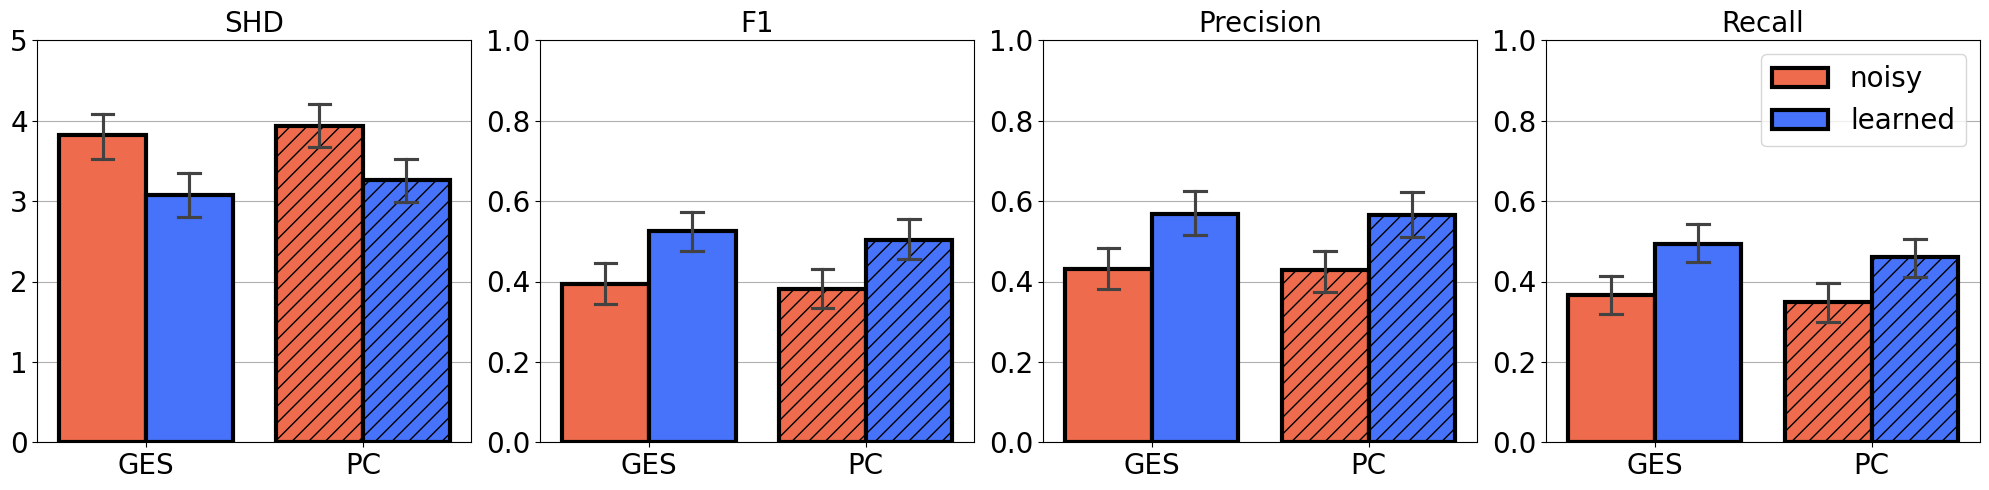

In [141]:
dfs_ges = [shd_ges, f1_ges, precision_ges, recall_ges]
dfs_pc = [shd_pc, f1_pc, precision_pc, recall_pc]
df_names = ['SHD', 'F1', 'Precision', 'Recall']

colors = ["#EE6C4D", "#4773FB"]

size_medium = 20
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)   
plt.rc('ytick', labelsize=size_medium)    
plt.rc('legend', fontsize=size_medium)

combined_df = pd.DataFrame()
for df1, df2, name in zip(dfs_ges, dfs_pc, df_names):
    melted_df1 = df1.melt(value_vars=['noisy', 'learned'], var_name='Type', value_name='Value')
    melted_df1['Dataset'] = name
    melted_df1['Group'] = 'GES'

    melted_df2 = df2.melt(value_vars=['noisy', 'learned'], var_name='Type', value_name='Value')
    melted_df2['Dataset'] = name
    melted_df2['Group'] = 'PC'

    combined_df = pd.concat([combined_df, melted_df1, melted_df2])


fig, axes = plt.subplots(1, len(dfs_ges), figsize=(len(dfs_ges) * 5, 5))

for i, (ax, name) in enumerate(zip(axes, df_names)): 
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    sns.barplot(data=combined_df[combined_df['Dataset'] == name], 
                x='Group', y='Value', hue='Type', palette=colors, 
                edgecolor='black', linewidth=3, ax=ax, capsize=.2, saturation=1.0)

    bars = ax.patches
    hatches = ['', '//', '', '//'] * len(dfs_ges)  # Pattern for each bar
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)


    ax.set_title(name)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if name in ['F1', 'Precision', 'Recall']:
        ax.set_ylim(0, 1)
    elif name in ['SHD']:
        ax.set_ylim(0, 5)
    
    if i != 3: 
        ax.legend().remove()
    else:
        ax.legend()

custom_legend_handle = mpatches.Patch(facecolor='#4773FB', label='learned', edgecolor='black', linewidth=3)
handles, labels = axes[3].get_legend_handles_labels()  
handles[-1] = custom_legend_handle  
axes[3].legend(handles=handles, labels=labels)
    
plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d4_ges_pc_pred_good.png', transparent=False, dpi=500)


## Figure 5.6 (optional)

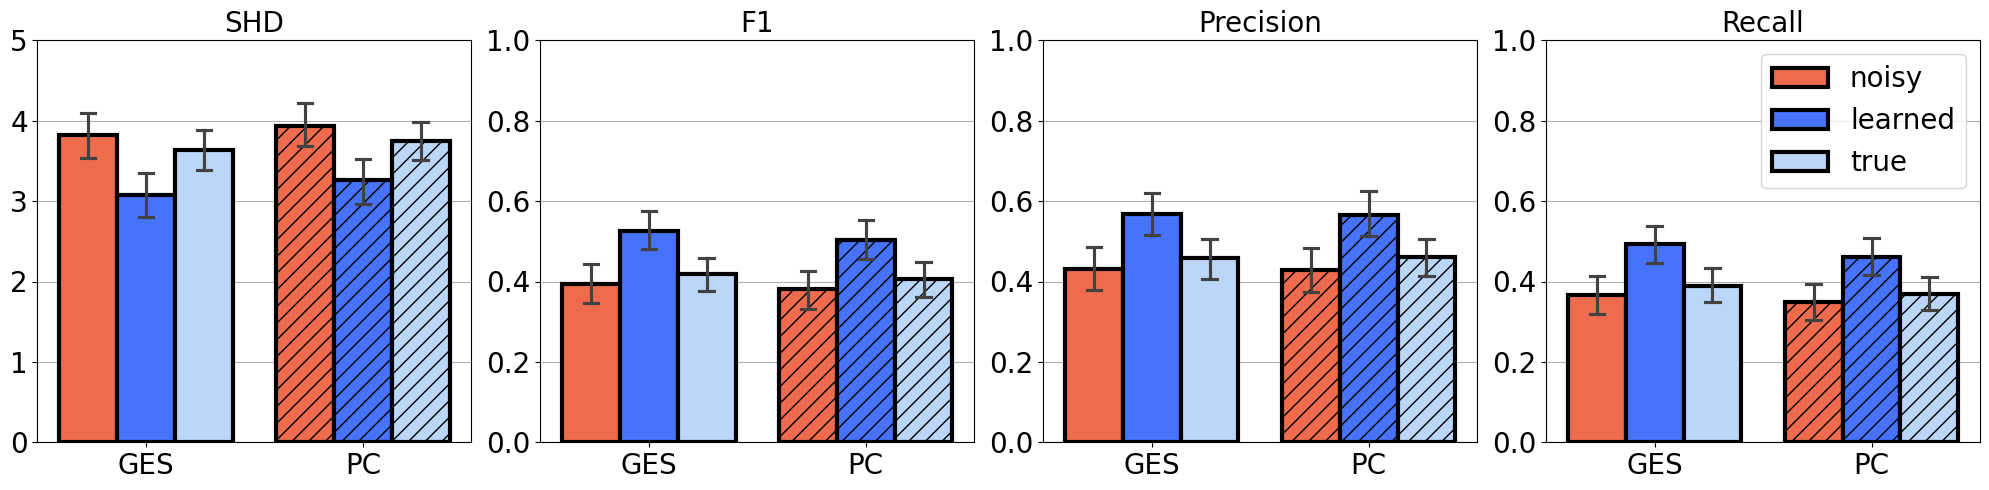

In [142]:
dfs_ges = [shd_ges, f1_ges, precision_ges, recall_ges]
dfs_pc = [shd_pc, f1_pc, precision_pc, recall_pc]
df_names = ['SHD', 'F1', 'Precision', 'Recall']

colors = ["#EE6C4D", "#4773FB", "#BCD6F8"]

size_medium = 20
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)  
plt.rc('ytick', labelsize=size_medium)  
plt.rc('legend', fontsize=size_medium)

combined_df = pd.DataFrame()
for df1, df2, name in zip(dfs_ges, dfs_pc, df_names):
    melted_df1 = df1.melt(value_vars=['noisy', 'learned','true'], var_name='Type', value_name='Value')
    melted_df1['Dataset'] = name
    melted_df1['Group'] = 'GES'

    melted_df2 = df2.melt(value_vars=['noisy', 'learned','true'], var_name='Type', value_name='Value')
    melted_df2['Dataset'] = name
    melted_df2['Group'] = 'PC'

    combined_df = pd.concat([combined_df, melted_df1, melted_df2])

fig, axes = plt.subplots(1, len(dfs_ges), figsize=(len(dfs_ges) * 5, 5))

for i, (ax, name) in enumerate(zip(axes, df_names)):
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    sns.barplot(data=combined_df[combined_df['Dataset'] == name], 
                x='Group', y='Value', hue='Type', palette=colors, 
                edgecolor='black', linewidth=3, ax=ax, capsize=.2, saturation=1.0)

    bars = ax.patches
    hatches = ['', '//', '', '//'] * len(dfs_ges)  
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax.set_title(name)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if name in ['F1', 'Precision', 'Recall']:
        ax.set_ylim(0, 1)
    elif name in ['SHD']:
        ax.set_ylim(0, 5)
    
    if i != 3:  
        ax.legend().remove()
    else:
        ax.legend()
    
custom_legend_handle = mpatches.Patch(facecolor='#4773FB', label='true', edgecolor='black', linewidth=3)
handles, labels = axes[3].get_legend_handles_labels() 
handles[-2] = custom_legend_handle  
axes[3].legend(handles=handles, labels=labels)
    

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d4_ges_pc_pred_good_full.png', transparent=False, dpi=500)


# CAUSAL DISCOVERY d=4 Prior Ablation

## DiBS (unit Gaussian prior) sigma fix

In [143]:
directory = 'results/causal_discovery/d4_DiBS_prior_tests/sigma_fix'
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes.append(pd.read_csv(file_path))

In [144]:
for i in range(7):
    print(dataframes[i].columns[1])

d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUPRC (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] precision (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUROC (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] E-SHD (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] neg. LL (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] F1 (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] recall (DiBS)


In [145]:
auprc_SIGfix = dataframes[0]
precision_SIGfix = dataframes[1]
auroc_SIGfix = dataframes[2]
eshd_SIGfix = dataframes[3]
negll_SIGfix = dataframes[4]
f1_SIGfix = dataframes[5]
recall_SIGfix = dataframes[6]


In [146]:
dict = {
    'E-SHD': eshd_SIGfix,
    'neg. LL': negll_SIGfix,
    'AUROC': auroc_SIGfix,
    'AUPRC': auprc_SIGfix,
    'F1': f1_SIGfix,
    'precision': precision_SIGfix,
    'recall': recall_SIGfix
}

In [147]:
for method, datf in dict.items():
    datf.rename(columns = {f'd4_alpha_0_2_h_latent_1_h_theta_10 - [true] {method} (DiBS)': 'true', 
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [learned] {method} (DiBS)': 'learned',
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [noisy] {method} (DiBS)': 'noisy'}, inplace = True)

## DiBS (unit Gaussian prior) sigma pred

In [149]:
directory = 'results/causal_discovery/d4_DiBS_prior_tests/sigma_pred'
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes.append(pd.read_csv(file_path))

In [150]:
for i in range(7):
    print(dataframes[i].columns[1])

d4_alpha_0_2_h_latent_1_h_theta_10 - [true] precision (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUPRC (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] F1 (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] recall (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUROC (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] neg. LL (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] E-SHD (DiBS)


In [151]:
precision_SIGpred = dataframes[0]
auprc_SIGpred = dataframes[1]
f1_SIGpred = dataframes[2]
recall_SIGpred = dataframes[3]
auroc_SIGpred = dataframes[4]
negll_SIGpred = dataframes[5]
eshd_SIGpred = dataframes[6]

In [152]:
dict = {
    'E-SHD': eshd_SIGpred,
    'neg. LL': negll_SIGpred,
    'AUROC': auroc_SIGpred,
    'AUPRC': auprc_SIGpred,
    'F1': f1_SIGpred,
    'precision': precision_SIGpred,
    'recall': recall_SIGpred
}

In [153]:
for method, datf in dict.items():
    datf.rename(columns = {f'd4_alpha_0_2_h_latent_1_h_theta_10 - [true] {method} (DiBS)': 'true', 
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [learned] {method} (DiBS)': 'learned',
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [noisy] {method} (DiBS)': 'noisy'}, inplace = True)

## DiBS (our prior) 

In [154]:
directory = 'results/causal_discovery/d4_DiBS/'
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes.append(pd.read_csv(file_path))

In [155]:
for i in range(10):
    print(dataframes[i].columns[1])

d4_alpha_0_2_h_latent_1_h_theta_10 - [true] neg. LL (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUROC (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] precision (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] E-SHD (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] E-SHD (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUPRC (DiBS+)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] recall (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] F1 (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] neg. LL (DiBS)
d4_alpha_0_2_h_latent_1_h_theta_10 - [true] AUROC (DiBS)


In [156]:
negll_p = dataframes[0]
auroc_p = dataframes[1]
precision = dataframes[2]
eshd_p = dataframes[3]
eshd = dataframes[4]
auprc_p = dataframes[5]
recall = dataframes[6]
f1 = dataframes[7]
negll = dataframes[8]
auroc = dataframes[9]
auprc = dataframes[10]

In [157]:
dict = {
    'E-SHD': eshd,
    'neg. LL': negll,
    'AUROC': auroc,
    'AUPRC': auprc,
    'F1': f1,
    'precision': precision,
    'recall': recall
}

In [158]:
for method, datf in dict.items():
    datf.rename(columns = {f'd4_alpha_0_2_h_latent_1_h_theta_10 - [true] {method} (DiBS)': 'true', 
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [learned] {method} (DiBS)': 'learned',
                        f'd4_alpha_0_2_h_latent_1_h_theta_10 - [noisy] {method} (DiBS)': 'noisy'}, inplace = True)

## Figure 5.11

In [159]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/var/folders/97/yb1hq8zn747_mz3mvv3gm3580000gn/T/ipykernel_36892/2449388770.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)
/var/folders/97/yb1hq8zn747_mz3mvv3gm3580000gn/T/ipykernel_36892/2449388770.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)
/var/folders/97/yb1hq8zn747_mz3mvv3gm3580000gn/T/ipykernel_36892/2449388770.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)
/var/folders/97/yb1hq8zn747_mz3mvv3gm3580000gn/T/ipykernel_36892/2449388770.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of tick

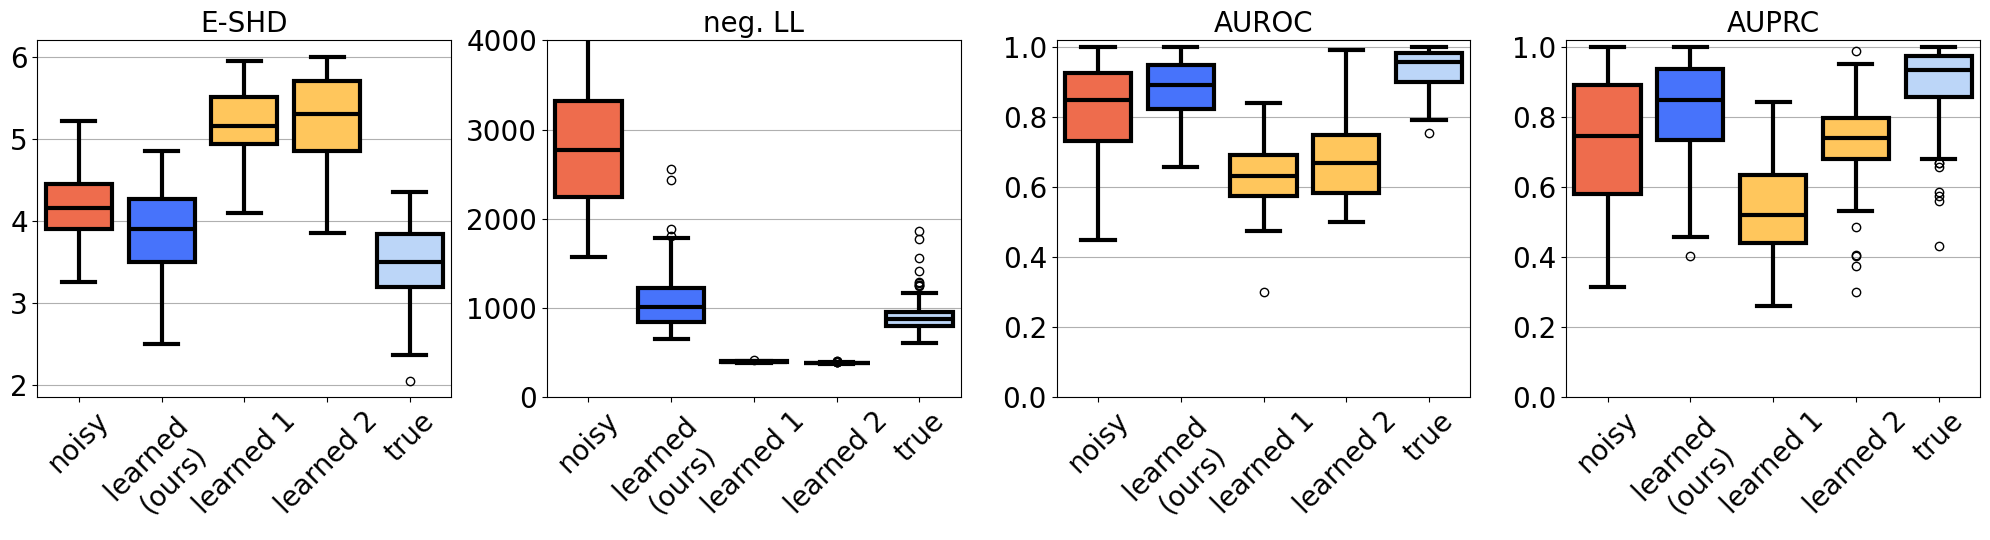

In [162]:
dataframes1 = [eshd, negll, auroc, auprc]
dataframes2 = [eshd_SIGfix, negll_SIGfix, auroc_SIGfix, auprc_SIGfix]
dataframes3 = [eshd_SIGpred, negll_SIGpred, auroc_SIGpred, auprc_SIGpred]
# df_names = [r'$\mathbb{E}\text{-SHD}$', 'neg. LL', 'AUROC', 'AUPRC']
df_names = ['E-SHD', 'neg. LL', 'AUROC', 'AUPRC']

# colors = ["#98C1D9", "#3D5A80", "#EE6C4D"]
# colors = ["#EE6C4D", "#3D5A80", "#98C1D9"]
# colors = ["#EE6C4D","#053be1", "#507afb", "#507afb","#BCD6F8"]
colors = ["#EE6C4D","#4773FB", "#FFC65C", "#FFC65C","#BCD6F8"]

fig, axes = plt.subplots(1, len(dataframes1), figsize=(len(dataframes1)*5, 5.5))

size_medium = 20
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size_medium)    # fontsize of the tick labels
plt.rc('legend', fontsize=size_medium)

data_type='learned'
for ax, df1, df2, df3, name in zip(axes, dataframes1, dataframes2, dataframes3, df_names):
    # sns.set_style("whitegrid")
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    combined_df = pd.concat([df1['noisy'],df1[data_type], df2[data_type], df3[data_type],df1['true']], axis=1)
    # combined_df.columns = ['noisy', f'learned \n(ours)', f'learned \n(Gauss1)', f'learned \n(Gauss2)','true']
    combined_df.columns = ['noisy', f'learned \n(ours)', f'learned 1', f'learned 2','true']
    # combined_df.columns = ['noisy', f'learned (ours)', f'learned (Gauss1)', f'learned (Gauss2)','true']
    # combined_df.columns = ['noisy', 'xs', 'xd', 'xf','true']
    sns.boxplot(data=combined_df, palette=colors, linecolor='black', ax=ax, linewidth=3, saturation=1.0)
    ax.set_title(name)
    # ax.set_xticks(range(combined_df.shape[1]))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20) 
    
    # tick_positions = range(len(combined_df.columns))
    # tick_labels = combined_df.columns
    # ax.set_xticks(tick_positions)
    # ax.set_xticklabels(tick_labels, rotation=70)


axes[1].set_ylim(0,4000)
axes[2].set_ylim(0,1.02)
axes[3].set_ylim(0,1.02)

# plt.subplots_adjust(bottom=0.15)

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d4_dibs_class_prior.png', transparent=False, dpi=500)


/var/folders/97/yb1hq8zn747_mz3mvv3gm3580000gn/T/ipykernel_36892/69244311.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)
/var/folders/97/yb1hq8zn747_mz3mvv3gm3580000gn/T/ipykernel_36892/69244311.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)
/var/folders/97/yb1hq8zn747_mz3mvv3gm3580000gn/T/ipykernel_36892/69244311.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)


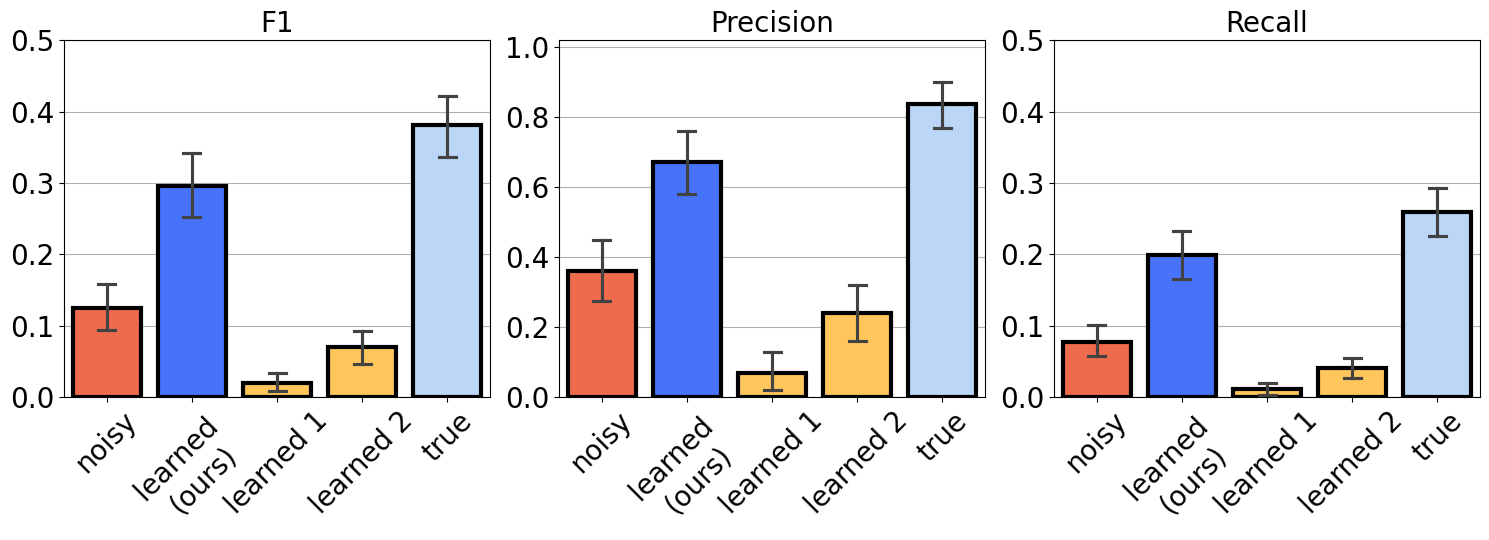

In [161]:
dataframes1 = [f1, precision, recall]
dataframes2 = [f1_SIGfix, precision_SIGfix, recall_SIGfix]
dataframes3 = [f1_SIGpred, precision_SIGpred, recall_SIGpred]
df_names = ['F1', 'Precision', 'Recall']

# colors = ["#98C1D9", "#3D5A80", "#EE6C4D"]
# colors = ["#EE6C4D", "#3D5A80", "#98C1D9"]
# colors = ["#EE6C4D", "#4773FB", "#BCD6F8"]
colors = ["#EE6C4D","#4773FB", "#FFC65C", "#FFC65C","#BCD6F8"]

fig, axes = plt.subplots(1, len(dataframes1), figsize=(len(dataframes1)*5, 5.5))

size_medium = 20
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size_medium)    # fontsize of the tick labels
plt.rc('legend', fontsize=size_medium)

data_type='learned'
for ax, df1, df2, df3, name in zip(axes, dataframes1, dataframes2, dataframes3, df_names):
    # sns.set_style("whitegrid")
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    combined_df = pd.concat([df1['noisy'],df1[data_type], df2[data_type], df3[data_type],df1['true']], axis=1)
    combined_df.columns = ['noisy', f'learned \n(ours)', f'learned 1', f'learned 2','true']
    sns.barplot(data=combined_df, palette=colors, ax=ax, capsize=.2, edgecolor='black', linewidth=3, saturation=1.0)
    ax.set_title(name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)
    ax.set_ylim(0, 1)


axes[0].set_ylim(0,0.5)
axes[1].set_ylim(0,1.02)
axes[2].set_ylim(0,0.5)

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d4_dibs_pred_prior.png', transparent=False, dpi=500)

# ---- synthetic scRNAseq ----

# CAUSAL DISCOVERY d=10

serene-pyramid-1210 - tag: VAEjax2_meta10_b10_s10_sdec10_MC1000_N500_d2_bias0_lamb09_wd1e2_lr1e3_poisson_moreshift2_loss20rec

## DiBS

In [163]:
directory = 'results/causal_discovery/d10_drop0_DiBS/dibs'
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes.append(pd.read_csv(file_path))

In [164]:
for i in range(7):
    print(dataframes[i].columns[1])

d10_alpha_0_2_h_latent_5_h_theta_200 - [true] precision (DiBS)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] recall (DiBS)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] neg. LL (DiBS)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] F1 (DiBS)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] AUROC (DiBS)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] AUPRC (DiBS)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] E-SHD (DiBS)


In [165]:
precision = dataframes[0]
recall = dataframes[1]
negll = dataframes[2]
f1 = dataframes[3]
auroc = dataframes[4]
auprc = dataframes[5]
eshd = dataframes[6]

In [166]:
dict = {
    'E-SHD': eshd,
    'neg. LL': negll,
    'AUROC': auroc,
    'AUPRC': auprc,
    'F1': f1,
    'precision': precision,
    'recall': recall
}

In [167]:
str = 'd10_alpha_0_2_h_latent_5_h_theta_200'

for method, datf in dict.items():
    datf.rename(columns = {f'{str} - [true] {method} (DiBS)': 'true', 
                        f'{str} - [learned] {method} (DiBS)': 'learned',
                        f'{str} - [noisy] {method} (DiBS)': 'noisy'}, inplace = True)

## DiBS+

In [168]:
directory = 'results/causal_discovery/d10_drop0_DiBS/dibs_plus'
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file and append it to the list
        dataframes.append(pd.read_csv(file_path))

In [169]:
for i in range(7):
    print(dataframes[i].columns[1])

d10_alpha_0_2_h_latent_5_h_theta_200 - [true] precision (DiBS+)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] E-SHD (DiBS+)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] neg. LL (DiBS+)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] recall (DiBS+)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] F1 (DiBS+)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] AUROC (DiBS+)
d10_alpha_0_2_h_latent_5_h_theta_200 - [true] AUPRC (DiBS+)


In [170]:
precision_p = dataframes[0]
eshd_p = dataframes[1]
negll_p = dataframes[2]
recall_p = dataframes[3]
f1_p = dataframes[4]
auroc_p = dataframes[5]
auprc_p = dataframes[6]

In [171]:
dict = {
    'E-SHD': eshd_p,
    'neg. LL': negll_p,
    'AUROC': auroc_p,
    'AUPRC': auprc_p,
    'F1': f1_p,
    'precision': precision_p,
    'recall': recall_p
}

In [172]:
str = 'd10_alpha_0_2_h_latent_5_h_theta_200'

for method, datf in dict.items():
    datf.rename(columns = {f'{str} - [true] {method} (DiBS+)': 'true', 
                        f'{str} - [learned] {method} (DiBS+)': 'learned',
                        f'{str} - [noisy] {method} (DiBS+)': 'noisy'}, inplace = True)

## Figure 5.7

In [100]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

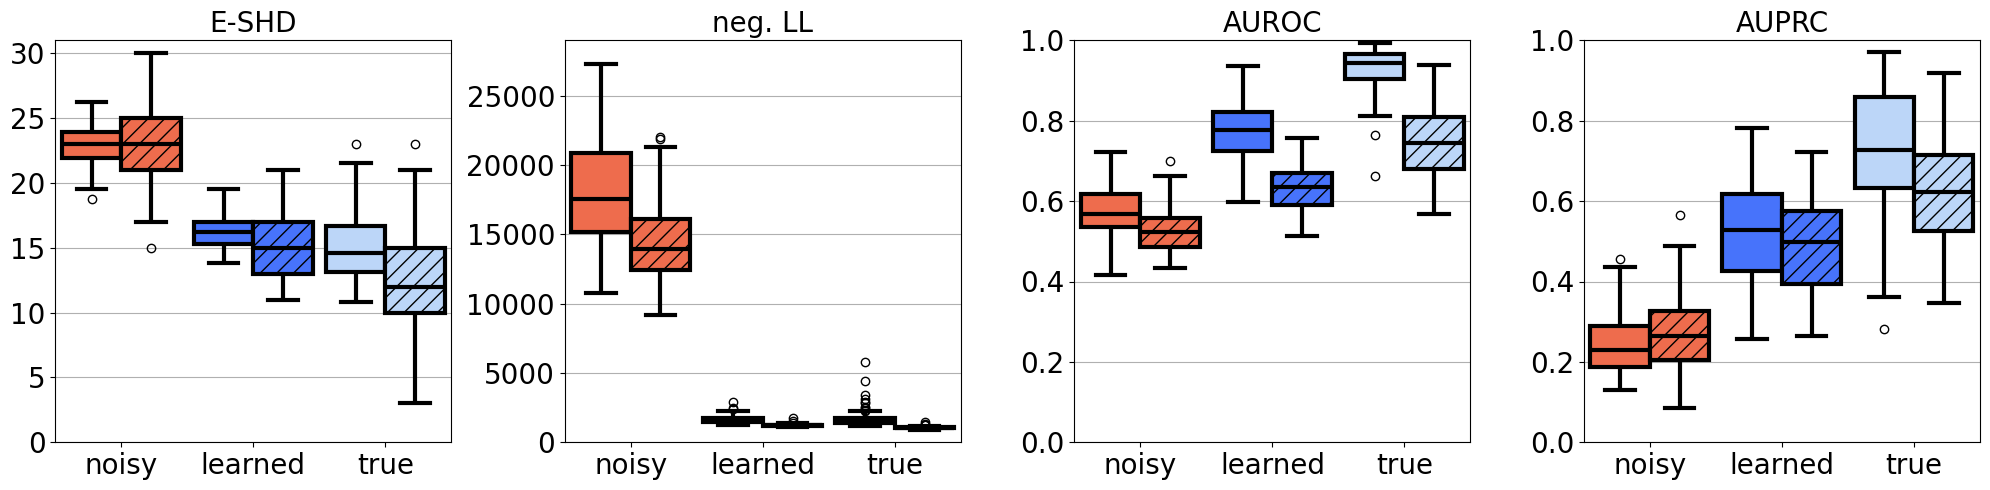

In [173]:
dataframes = [eshd, negll, auroc, auprc]
dfs_dibs_p = [eshd_p, negll_p, auroc_p, auprc_p]
df_names = ['E-SHD', 'neg. LL', 'AUROC', 'AUPRC']

colors = {
    ('DiBS', 'noisy'): '#EE6C4D',
    ('DiBS', 'learned'): '#4773FB',
    ('DiBS', 'true'): '#BCD6F8',
    ('DiBS+', 'noisy'): '#EE6C4D',
    ('DiBS+', 'learned'): '#4773FB',
    ('DiBS+', 'true'): '#BCD6F8'
}

fig, axes = plt.subplots(1, len(dataframes), figsize=(len(dataframes)*5, 5))

box_width = 0.45
offset = 0.225

for ax, df, df_p, name in zip(axes, dataframes, dfs_dibs_p, df_names):
    # sns.set_style("whitegrid")
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    df['Type'] = 'DiBS'
    df_p['Type'] = 'DiBS+'
    
    merged_df = pd.concat([df, df_p], axis=0)
    melted_df = merged_df.melt(id_vars=['Type'], value_vars=['noisy', 'learned', 'true'])

    variables = melted_df['variable'].unique()
    positions = np.arange(len(variables))

    for type_val in melted_df['Type'].unique():
        for i, var_val in enumerate(variables):
            pos = positions[i] + offset if type_val == 'DiBS+' else positions[i] - offset
            sns.boxplot(
                data=melted_df[(melted_df['Type'] == type_val) & (melted_df['variable'] == var_val)], 
                x='variable', y='value', 
                color=colors[(type_val, var_val)], 
                ax=ax, width=box_width, 
                positions=[pos],
                linecolor='black', linewidth=3, saturation=1.0
            )

    ax.set_title(name)
    ax.set_xticks(positions)
    ax.set_xticklabels(variables)

    hatches = ['', '', '', '//', '//', '//']
    bars = ax.patches
    for pat, bar in zip(hatches, bars):
        bar.set_hatch(pat)

    ax.set_ylabel('')
    ax.set_xlabel('')

axes[0].set_ylim(0,31)
axes[1].set_ylim(0,29000)
axes[2].set_ylim(0,1)
axes[3].set_ylim(0,1)

size_medium = 18
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)    
plt.rc('ytick', labelsize=size_medium)    
plt.rc('legend', fontsize=size_medium)

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d10_drop0_dibs_class_all.png', transparent=False, dpi=500)

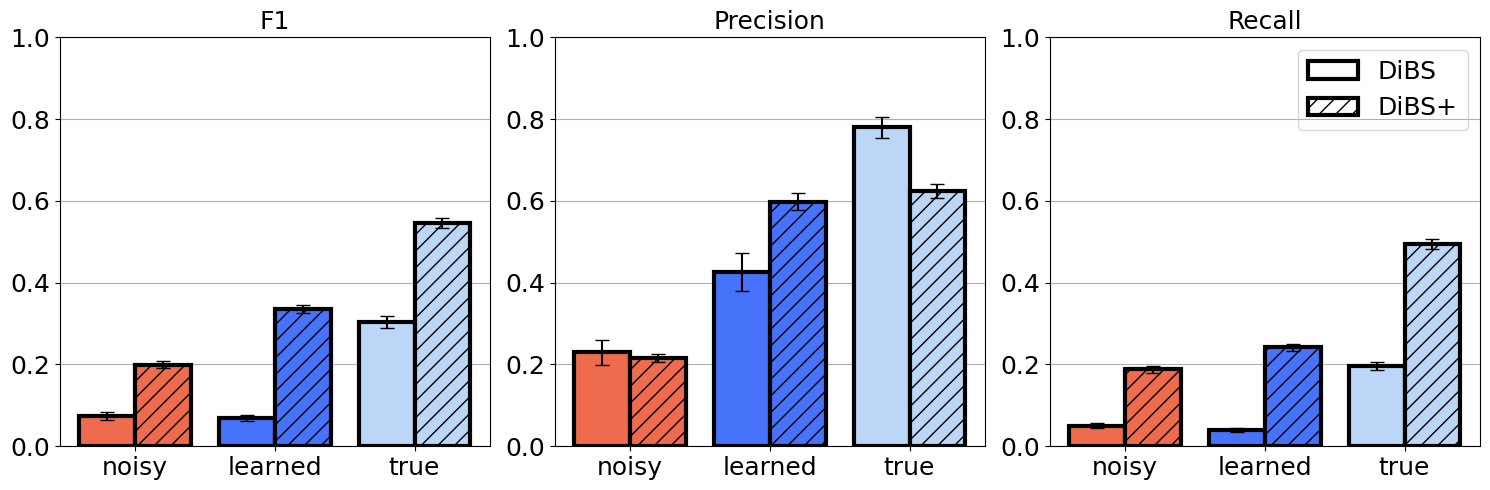

In [174]:
dataframes = [f1, precision, recall]
dfs_dibs_p = [f1_p, precision_p, recall_p]
df_names = ['F1', 'Precision', 'Recall']
colors = ["#EE6C4D", "#4773FB", "#BCD6F8"]

fig, axes = plt.subplots(1, len(dataframes), figsize=(len(dataframes)*5, 5))

categories = ['noisy', 'learned', 'true']
types = ['DiBS', 'DiBS+']

for ax, df, df_p, name in zip(axes, dataframes, dfs_dibs_p, df_names):
    # sns.set_style("whitegrid")
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    
    df['Type'] = 'DiBS'
    df_p['Type'] = 'DiBS+'
    merged_df = pd.concat([df, df_p], axis=0)
    melted_df = merged_df.melt(id_vars=['Type'], value_vars=categories)

    n_categories = len(categories)
    bar_width = 0.4

    for i, category in enumerate(categories):
        category_data = melted_df[melted_df['variable'] == category]
        for j, typ in enumerate(types):
            type_data = category_data[category_data['Type'] == typ]
            mean = type_data['value'].mean()
            std_err = type_data['value'].std() / np.sqrt(len(type_data))  # Standard error
            position = i - bar_width/2 + j*bar_width
            bar = ax.bar(position, mean, yerr=std_err, width=bar_width, color=colors[i], 
                         edgecolor='black', linewidth=3, capsize=5, 
                         hatch='//' if typ == 'DiBS+' else None, label=typ if i == 0 else None)
        
    ax.set_title(name)
    ax.set_xticks(range(n_categories))
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    # ax.grid(axis='y')
    
    legend = ax.legend(facecolor='none') 
    for handle in legend.legend_handles:
        handle.set_facecolor('none')  

axes[0].legend_.remove()
axes[1].legend_.remove()
   

size_medium = 18
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)
plt.rc('ytick', labelsize=size_medium)
plt.rc('legend', fontsize=size_medium)


plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d10_drop0_dibs_p_pred_col.png', transparent=False, dpi=300)

# CAUSAL DISCOVERY d=10 Test dropout, predicting pi

In [175]:
df_drop0_3 = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop0.csv')

df_drop10_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop10.csv')
df_drop20_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop20.csv')
df_drop30_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop30.csv')
df_drop40_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop40.csv')
df_drop50_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop50.csv')
df_drop60_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop60.csv')
df_drop70_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop70.csv')
# df_drop80_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop80.csv') # has some merge conflict handle
df_drop80_pred2 = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop80_2.csv')
df_drop90_pred = pd.read_csv('results/causal_discovery/d10_dropTESTpred/results_drop90.csv')

In [178]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

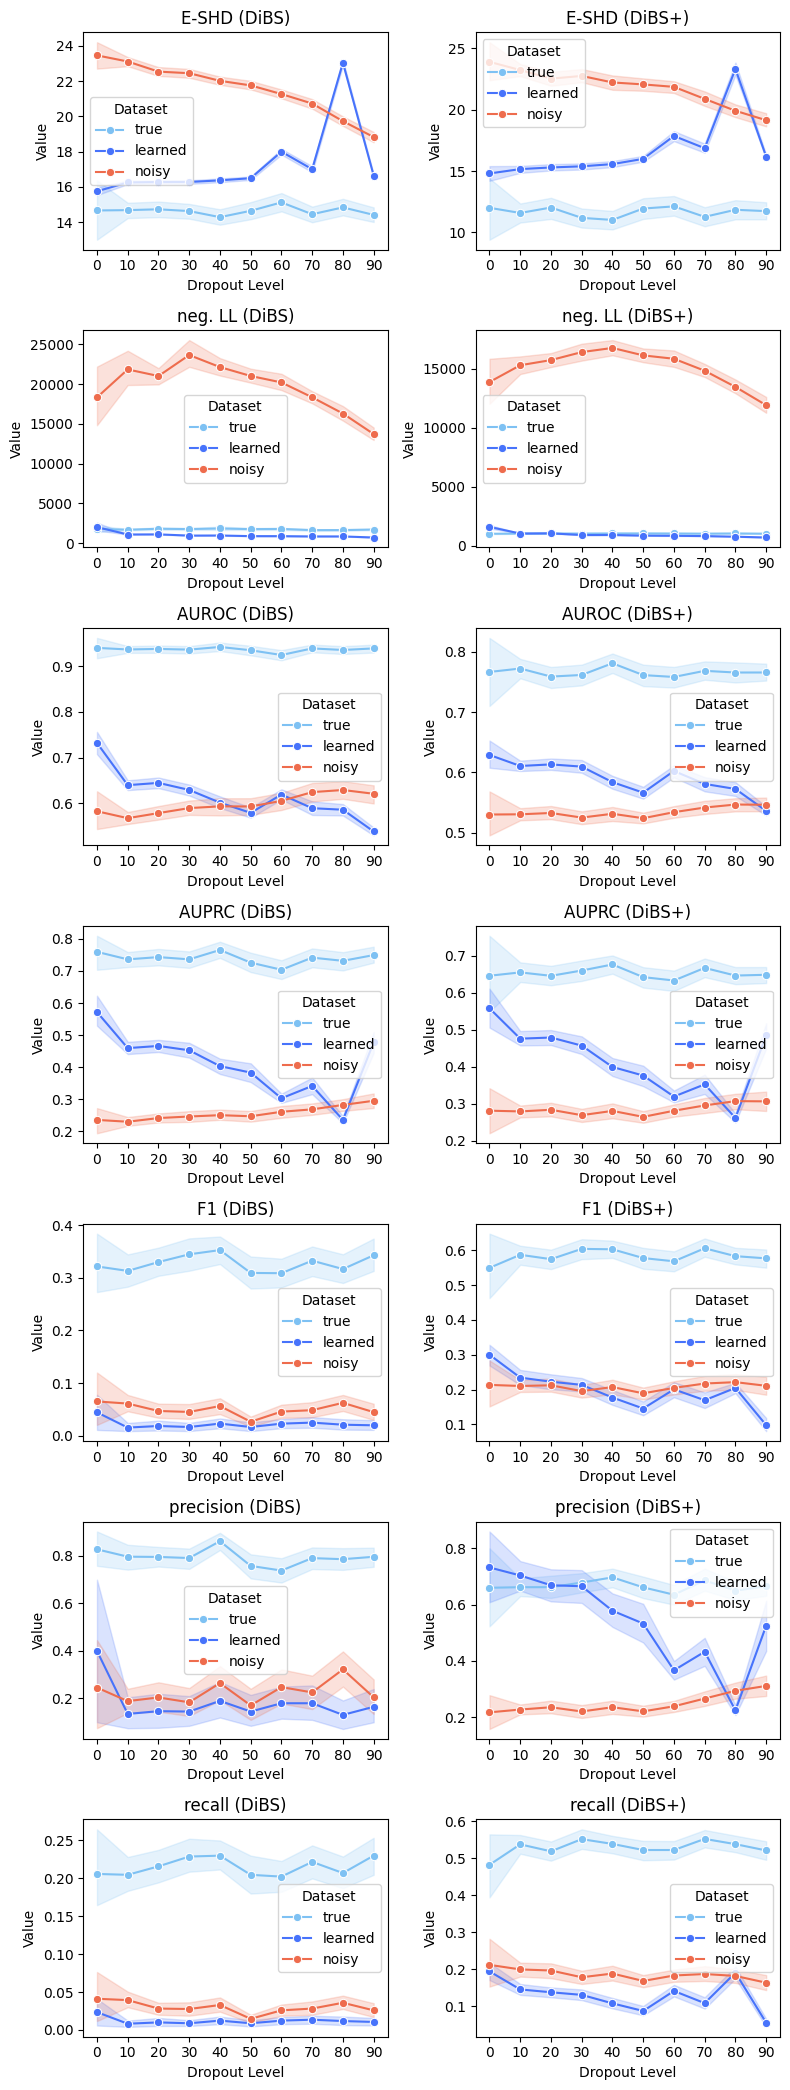

In [179]:
# dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred, df_drop90_pred]
dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred2, df_drop90_pred]
dropout_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

metrics = ['E-SHD', 'neg. LL', 'AUROC', 'AUPRC', 'F1', 'precision', 'recall']
methods = ['DiBS', 'DiBS+']
datasets = ['true', 'learned', 'noisy']


fig, axes = plt.subplots(7, 2, figsize=(8, 7*3)) 
# sns.set(style="whitegrid")

palette = {'true': '#7EC1F3', 'learned': '#4773FB', 'noisy': '#EE6C4D'}

# Loop through each metric and method
for i, metric in enumerate(metrics):
    for j, method in enumerate(methods):
        data = {'Dropout Level': [], 'Dataset': [], 'Value': []}

        for df, dropout_level in zip(dfs, dropout_levels):
            for dataset in datasets:
                col_name = f'[{dataset}] {metric} ({method})'
                values = df.filter(like=col_name).mean(axis=1) 
                data['Dropout Level'].extend([dropout_level] * len(values))
                data['Dataset'].extend([dataset] * len(values))
                data['Value'].extend(values)

        plot_df = pd.DataFrame(data)
        sns.lineplot(data=plot_df, x='Dropout Level', y='Value', hue='Dataset', ax=axes[i, j], marker='o', palette=palette, err_style='band')
        axes[i, j].set_title(f'{metric} ({method})')
        axes[i, j].set_xlabel('Dropout Level')
        axes[i, j].set_ylabel('Value')
        axes[i, j].set_xticks(dropout_levels)

plt.tight_layout()
plt.show()


## Figure 5.8

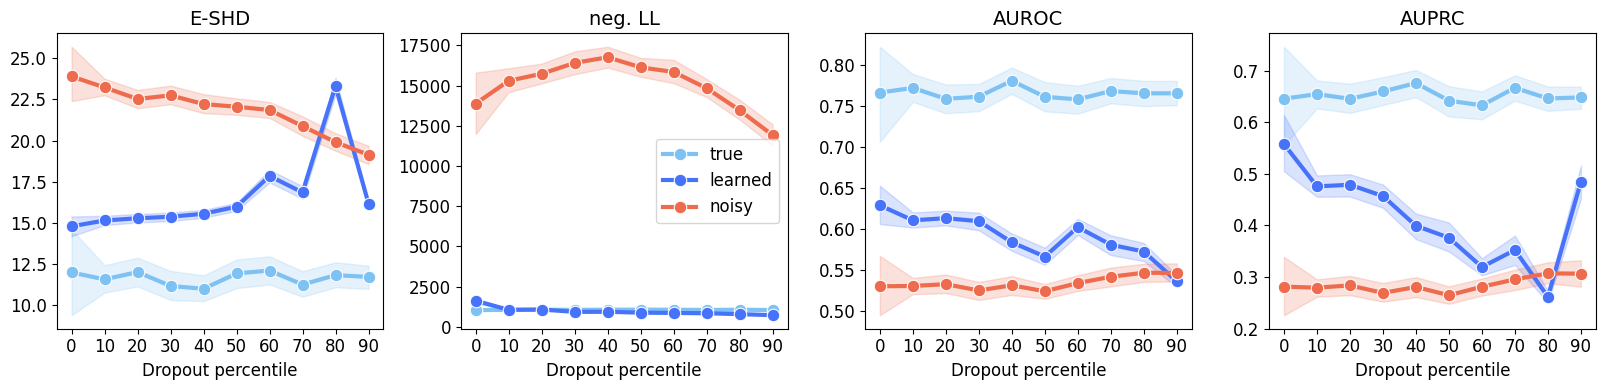

In [180]:
# dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred, df_drop90_pred]
dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred2, df_drop90_pred]
dropout_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]


metrics = ['E-SHD', 'neg. LL', 'AUROC', 'AUPRC']
methods = ['DiBS+'] 
datasets = ['true', 'learned', 'noisy']

size_medium = 12
plt.rc('axes', titlesize=size_medium+2)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)    
plt.rc('ytick', labelsize=size_medium)   
plt.rc('legend', fontsize=size_medium)

num_rows = len(methods)

fig, axes = plt.subplots(num_rows, 4, figsize=(4*4, num_rows*4))

if num_rows == 1:
    axes = [axes]

palette = {'true': '#7EC1F3', 'learned': '#4773FB', 'noisy': '#EE6C4D'}

for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        data = {'Dropout Level': [], 'Dataset': [], 'Value': []}

        for df, dropout_level in zip(dfs, dropout_levels):
            for dataset in datasets:
                col_name = f'[{dataset}] {metric} ({method})'
                values = df.filter(like=col_name).mean(axis=1)
                data['Dropout Level'].extend([dropout_level] * len(values))
                data['Dataset'].extend([dataset] * len(values))
                data['Value'].extend(values)

        plot_df = pd.DataFrame(data)
        sns.lineplot(data=plot_df, x='Dropout Level', y='Value', hue='Dataset', ax=axes[i][j], marker='o', markersize=9, linewidth=3, palette=palette, estimator='mean', errorbar=('ci', 95), n_boot=1000, err_style='band')
        axes[i][j].set_title(f'{metric}')
        axes[i][j].set_xlabel('Dropout percentile')
        axes[i][j].set_ylabel('')
        axes[i][j].set_xticks(dropout_levels)
        
        if (i == num_rows - 1 and j == 1): 
            axes[i][j].legend()
        else:
            axes[i][j].legend().remove()
        
plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d10_dropTESTpred_dibs_p_pred_prc.png', transparent=False, dpi=500)

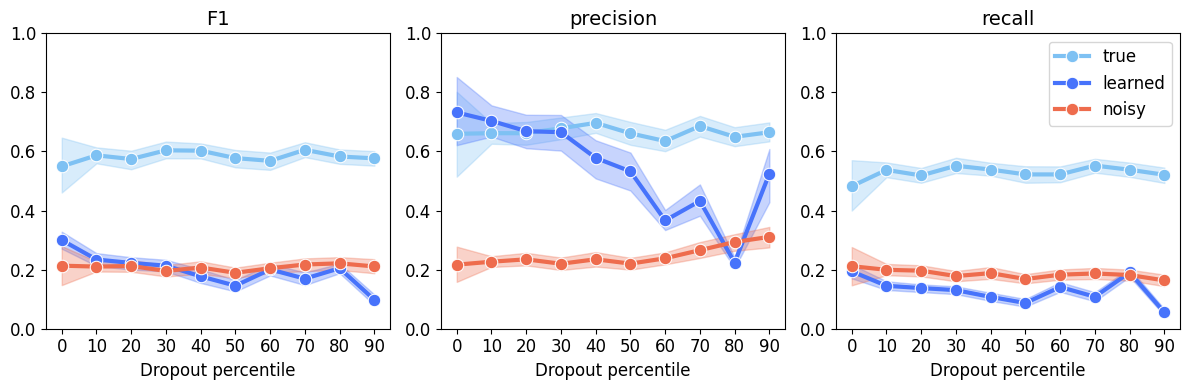

In [181]:
# dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred, df_drop90_pred]
dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred2, df_drop90_pred]
dropout_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

metrics = ['F1', 'precision', 'recall']
methods = ['DiBS+'] 
datasets = ['true', 'learned', 'noisy']

size_medium = 12
plt.rc('axes', titlesize=size_medium+2)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)   
plt.rc('ytick', labelsize=size_medium)    
plt.rc('legend', fontsize=size_medium)

num_rows = len(methods)
num_cols = len(metrics)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*4))

if num_rows == 1:
    axes = [axes]

palette = {'true': '#7EC1F3', 'learned': '#4773FB', 'noisy': '#EE6C4D'}

for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        data = {'Dropout Level': [], 'Dataset': [], 'Value': []}

        for df, dropout_level in zip(dfs, dropout_levels):
            for dataset in datasets:
                col_name = f'[{dataset}] {metric} ({method})'
                values = df.filter(like=col_name).mean(axis=1)
                data['Dropout Level'].extend([dropout_level] * len(values))
                data['Dataset'].extend([dataset] * len(values))
                data['Value'].extend(values)

        plot_df = pd.DataFrame(data)
        sns.lineplot(data=plot_df, x='Dropout Level', y='Value', hue='Dataset', ax=axes[i][j], marker='o', markersize=9, linewidth=3, palette=palette, estimator='mean', errorbar=('ci', 95), n_boot=1000, err_style='band', err_kws={'alpha': 0.3})
        axes[i][j].set_title(f'{metric}')
        axes[i][j].set_xlabel('Dropout percentile')
        axes[i][j].set_ylabel('')
        axes[i][j].set_xticks(dropout_levels)
        axes[i][j].set_ylim(0,1)
        
        if (i == num_rows - 1 and j == 2):  
            axes[i][j].legend()
        else:
            axes[i][j].legend().remove()

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d10_dropTESTpred_dibs_p_class_prc.png', transparent=False, dpi=500)

## Figure 5.8 (brighter CI bounds)

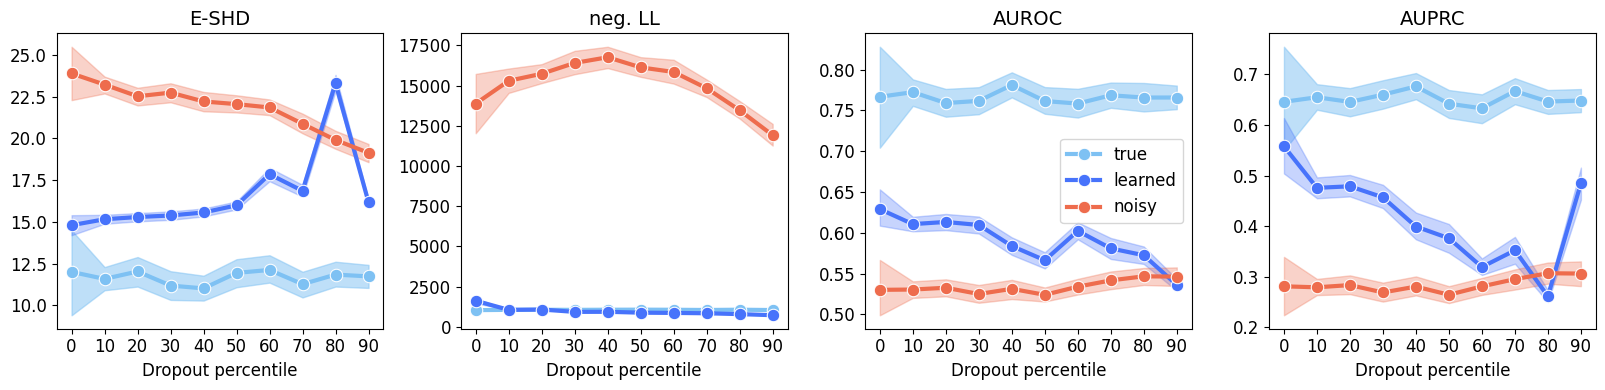

In [182]:
# dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred, df_drop90_pred]
dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred2, df_drop90_pred]
dropout_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

metrics = ['E-SHD', 'neg. LL', 'AUROC', 'AUPRC']
methods = ['DiBS+'] 
datasets = ['true', 'learned', 'noisy']

size_medium = 12
plt.rc('axes', titlesize=size_medium+2)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)   
plt.rc('ytick', labelsize=size_medium)    
plt.rc('legend', fontsize=size_medium)

num_rows = len(methods)
num_cols = len(metrics)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*4))

if num_rows == 1:
    axes = [axes]

palette = {'true': '#7EC1F3', 'learned': '#4773FB', 'noisy': '#EE6C4D'}

for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        for dataset in datasets:
            data = {'Dropout Level': [], 'Value': []}

            for df, dropout_level in zip(dfs, dropout_levels):
                col_name = f'[{dataset}] {metric} ({method})'
                values = df.filter(like=col_name).mean(axis=1)
                data['Dropout Level'].extend([dropout_level] * len(values))
                data['Value'].extend(values)

            plot_df = pd.DataFrame(data)

            if dataset == 'true':
                err_kws = {'alpha': 0.5}  
            else:
                err_kws = {'alpha': 0.3}  

            sns.lineplot(data=plot_df, x='Dropout Level', y='Value', 
                         ax=axes[i][j], marker='o', markersize=9, linewidth=3, 
                         color=palette[dataset], estimator='mean', 
                         errorbar=('ci', 95), n_boot=1000, err_style='band', 
                         err_kws=err_kws, label=dataset)

        axes[i][j].set_title(f'{metric}')
        axes[i][j].set_xlabel('Dropout percentile')
        axes[i][j].set_ylabel('')
        axes[i][j].set_xticks(dropout_levels)
        
        if (i == num_rows - 1 and j == 2):  
            axes[i][j].legend()
        else:
            axes[i][j].legend().remove()

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d10_dropTESTpred_dibs_p_pred_prc2.png', transparent=False, dpi=500)

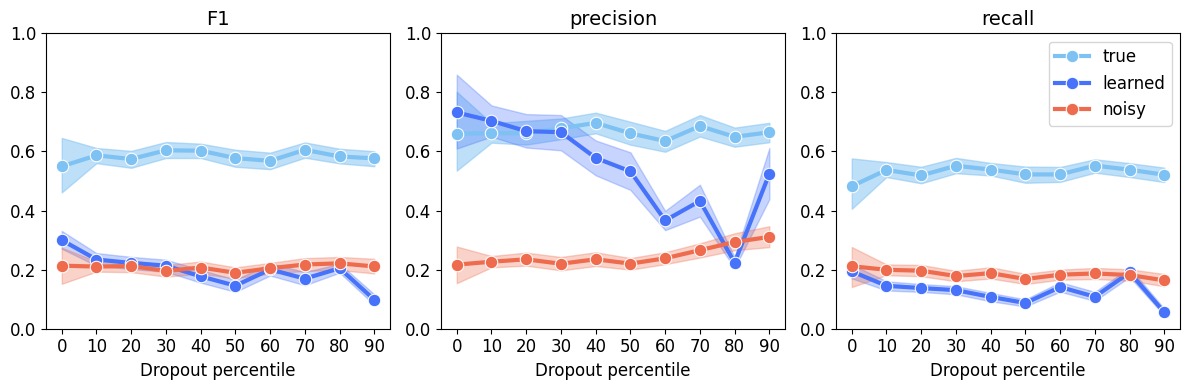

In [183]:
# dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred, df_drop90_pred]
dfs = [df_drop0_3, df_drop10_pred, df_drop20_pred, df_drop30_pred, df_drop40_pred, df_drop50_pred, df_drop60_pred, df_drop70_pred, df_drop80_pred2, df_drop90_pred]
dropout_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

metrics = ['F1', 'precision', 'recall']
methods = ['DiBS+'] 
datasets = ['true', 'learned', 'noisy']

size_medium = 12
plt.rc('axes', titlesize=size_medium+2)
plt.rc('axes', labelsize=size_medium)
plt.rc('xtick', labelsize=size_medium)   
plt.rc('ytick', labelsize=size_medium)   
plt.rc('legend', fontsize=size_medium)

num_rows = len(methods)
num_cols = len(metrics)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*4))

if num_rows == 1:
    axes = [axes]

palette = {'true': '#7EC1F3', 'learned': '#4773FB', 'noisy': '#EE6C4D'}

for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        for dataset in datasets:
            data = {'Dropout Level': [], 'Value': []}

            for df, dropout_level in zip(dfs, dropout_levels):
                col_name = f'[{dataset}] {metric} ({method})'
                values = df.filter(like=col_name).mean(axis=1)
                data['Dropout Level'].extend([dropout_level] * len(values))
                data['Value'].extend(values)

            plot_df = pd.DataFrame(data)

            if dataset == 'true':
                err_kws = {'alpha': 0.5} 
            else:
                err_kws = {'alpha': 0.3} 

            sns.lineplot(data=plot_df, x='Dropout Level', y='Value', 
                         ax=axes[i][j], marker='o', markersize=9, linewidth=3, 
                         color=palette[dataset], estimator='mean', 
                         errorbar=('ci', 95), n_boot=1000, err_style='band', 
                         err_kws=err_kws, label=dataset)

        axes[i][j].set_title(f'{metric}')
        axes[i][j].set_xlabel('Dropout percentile')
        axes[i][j].set_ylabel('')
        axes[i][j].set_xticks(dropout_levels)
        axes[i][j].set_ylim(0, 1)

        if (i == num_rows - 1 and j == 2): 
            axes[i][j].legend()
        else:
            axes[i][j].legend().remove()

plt.tight_layout()
plt.show()
# plt.savefig('results/figures/d10_dropTESTpred_dibs_p_class_prc2.png', transparent=False, dpi=500)

### on computing 95% CI for true mean in the above plots

on error metrics: https://seaborn.pydata.org/tutorial/error_bars.html

sns.lineplot documentation https://seaborn.pydata.org/generated/seaborn.lineplot.html